In [11]:
import copy

import pandas as pd
import sys
import math

sys.path.append('../Coding')
from itertools import combinations
from Algorithms import pattern_count
import time
from Algorithms import NewAlgRanking_19_20211216 as newalg
from Algorithms import NaiveAlgRanking_4_20211213 as naivealg
import numpy as np
import copy
import sys
import math
from sklearn.linear_model import LinearRegression
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

from Algorithms import NewAlgRanking_definition2_13_20220509 as newalg2
from Algorithms import NaiveAlgRanking_definition2_5_20220506 as naivealg2

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

sns.set_palette("Paired")
# sns.set_palette("deep")
sns.set_context("poster", font_scale=2)
sns.set_style("whitegrid")
# sns.palplot(sns.color_palette("deep", 10))
# sns.palplot(sns.color_palette("Paired", 9))

line_style = ['o-', 's--', '^:', '-.p']
color = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']
# plt_title = ["BlueNile", "COMPAS", "Credit Card"]
#
# label = ["PropBounds", "IterTD"]
line_width = 8
marker_size = 15
f_size = (14, 8)

In [38]:
def string2num(st):
    p = list()
    idx = 0
    item = ''
    i = ''
    for i in st:
        if i == '|':
            if item == '':
                p.append(-1)
            else:
                p.append(int(item))
                item = ''
            idx += 1
        else:
            item += i
    if i != '|':
        p.append(int(item))
    else:
        p.append(-1)
    return p


def P1DominatedByP2(P1, P2):
    length = len(P1)
    for i in range(length):
        if P1[i] == -1:
            if P2[i] != -1:
                return False
        if P1[i] != -1:
            if P2[i] != P1[i] and P2[i] != -1:
                return False
    return True

def idx_of_tuples_in_group(group, data):
    def belong_to_group(row):
        nonlocal group
        if P1DominatedByP2(row, group):
            return True
        else:
            return False
    data["in"] = data.apply(belong_to_group, axis=1)
    return data[data["in"] == True].index

def average_shapley_values_of_group(data, group, all_attributes, shap_values, output_file):
    # get all tuples in this group
    data1 = data[all_attributes].copy(deep=True)
    tuples_idx = idx_of_tuples_in_group(group, data1).to_list()
    if len(tuples_idx) == 0:
        output_file.write("\ngroup {} size {}\n".format(group, len(tuples_idx)))
        print("group {} size {}".format(group, len(tuples_idx)))
    else:
        # print(tuples_idx)
        # for id in tuples_idx:
        #     print(id, shap_values.values[id][-1])
        avg = np.average(shap_values.values[tuples_idx], axis=0)
        output_file.write("\ngroup {} size {}\n".format(group, len(tuples_idx)))
        output_file.write(str(avg))
        print("group {} size {}".format(group, len(tuples_idx)))
        print(avg)

def idx_of_tuples_in_group_w_attribute(group, data, att, value):
    def belong_to_group(row):
        nonlocal group
        if P1DominatedByP2(row, group):
            if row[att] == value:
                return True
            else:
                return False
        else:
            return False
    data["in"] = data.apply(belong_to_group, axis=1)
    idx = data[data["in"] == True].index
    data.drop(columns=["in"], axis=1, inplace=True)
    return idx


def shapley_values_att_value_seperated(data, group, all_attributes, shap_values, output_file):
    # get all tuples in this group
    data1 = data[all_attributes].copy(deep=True)
    att_idx = 0
    for att in all_attributes:
        for v in range(int(data1.describe()[att]["min"]), int(data1.describe()[att]["max"]) + 1):
            tuples_idx = idx_of_tuples_in_group_w_attribute(group, data1, att, v).to_list()
            if len(tuples_idx) == 0:
                output_file.write("group {} att {} = {} size {}\n".format(group, att, v, len(tuples_idx)))
                print("group {} att {} = {} size {}".format(group, att, v, len(tuples_idx)))
            else:
                values_of_group = shap_values.values[tuples_idx]
                avg = np.average(values_of_group, axis=0)
                print("group {} att {} = {} size {}\n avg {}".format(group, att, v, len(tuples_idx), avg))
                output_file.write("group {} att {} = {} size {} avg {}\n".format(group, att, v, len(tuples_idx), avg[att_idx]))
        att_idx += 1

def tuples_in_group(g, data, selected_attributes):
    tuple_idx = idx_of_tuples_in_group(g, data[selected_attributes].copy(deep=True))
    tuples = data.iloc[tuple_idx]
    return tuples

def tuples_not_in_group(g, data, selected_attributes):
    tuple_idx = idx_of_tuples_in_group(g, data[selected_attributes].copy(deep=True))
    return data.drop(tuple_idx)

def check_another_group_global_bounds(g, data, selected_attributes, thc, Lowerbounds, k):
    size_whole_data = len(tuples_in_group(g, data, selected_attributes))
    if size_whole_data < thc:
        print("group g size too small", size_whole_data)
        return False
    size_topk = len(tuples_in_group(g, data[:k], selected_attributes))
    if size_topk < Lowerbounds[0]:
        print("group g doesn't have enough representation in top k", size_topk)
        return False
    return True


def check_another_group_prop_bounds(g, data, selected_attributes, thc, alpha, k):
    size_whole_data = len(tuples_in_group(g, data, selected_attributes))
    if size_whole_data < thc:
        print("group g size too small", size_whole_data)
        return False
    size_topk = len(tuples_in_group(g, data[:k], selected_attributes))
    lowerbound = alpha * size_whole_data * k / len(data)
    print(size_whole_data, size_topk, lowerbound)
    if size_topk < lowerbound:
        print("group g doesn't have enough representation in top k", size_topk)
        return False
    return True

def plot_distribution_number(ranked_data, attribute, group, another_group, k):
    x_list = ranked_data[attribute].unique()
    x_list.sort()
    tuples = tuples_in_group(group, ranked_data, selected_attributes)
    s = tuples[attribute].value_counts().sort_index()
    group_value_dis = [s[i] if i in s else 0 for i in x_list]
    s = ranked_data[attribute].value_counts().sort_index()
    whole_data_dis = [s[i] if i in s else 0 for i in x_list]
    s = tuples_not_in_group(group, ranked_data, selected_attributes)[attribute].value_counts().sort_index()
    other_data_dis = [s[i] if i in s else 0 for i in x_list]
    s = tuples_in_group(another_group, ranked_data, selected_attributes)[attribute].value_counts().sort_index()
    total = sum(s)
    another_group_dis = [s[i] if i in s else 0 for i in x_list]


    s = ranked_data[:k][attribute].value_counts().sort_index()
    topkdis = [s[i] if i in s else 0 for i in x_list]

    index = np.arange(len(x_list))
    bar_width = 0.2

    fig, ax = plt.subplots(1, 1, figsize=(20, 8))

    index = np.arange(len(x_list))
    plt.bar(index, group_value_dis, bar_width, color=color[0], label="group")
    plt.bar(index + bar_width, whole_data_dis, bar_width,  color=color[2], label="whole data")
    plt.bar(index + bar_width * 2, other_data_dis, bar_width,  color=color[4], label="other data")
    plt.bar(index + bar_width * 3, another_group_dis, bar_width,  color=color[6], label="non-problematic group")
    plt.bar(index + bar_width * 4, topkdis, bar_width,  color=color[8], label="topk")
    # plt.xticks(index + bar_width, x_list)
    # plt.xticks(index, x_list)

    plt.ylabel('number of tuples')
    plt.xlabel('value of attribute ' + attribute)
    # plt.yscale('log')
    plt.legend(loc='best', fontsize=25)

    plt.tight_layout()
    # plt.savefig("adult_time.png", bbox_inches='tight')
    plt.show()

def plot_distribution_ratio(ranked_data, attribute, group, another_group, k):
    x_list = ranked_data[attribute].unique()
    x_list.sort()
    tuples = tuples_in_group(group, ranked_data, selected_attributes)
    s = tuples[attribute].value_counts().sort_index()
    total = sum(s)
    group_value_dis = [s[i]/total if i in s else 0 for i in x_list]
    s = ranked_data[attribute].value_counts().sort_index()
    total = sum(s)
    whole_data_dis = [s[i]/total if i in s else 0 for i in x_list]
    s = tuples_not_in_group(group, ranked_data, selected_attributes)[attribute].value_counts().sort_index()
    total = sum(s)
    other_data_dis = [s[i]/total if i in s else 0 for i in x_list]
    s = tuples_in_group(another_group, ranked_data, selected_attributes)[attribute].value_counts().sort_index()
    total = sum(s)
    another_group_dis = [s[i]/total if i in s else 0 for i in x_list]
    bar_width = 0.20

    s = ranked_data[:k][attribute].value_counts().sort_index()
    total = sum(s)
    topkdis = [s[i]/total if i in s else 0 for i in x_list]
    fig, ax = plt.subplots(1, 1, figsize=(20, 8))

    index = np.arange(len(x_list))
    plt.bar(index, group_value_dis, bar_width, color=color[0], label="group")
    plt.bar(index + bar_width, whole_data_dis, bar_width,  color=color[2], label="whole data")
    plt.bar(index + bar_width * 2, other_data_dis, bar_width,  color=color[4], label="other data")
    plt.bar(index + bar_width * 3, another_group_dis, bar_width,  color=color[6], label="non-problematic group")
    plt.bar(index + bar_width * 4, topkdis, bar_width,  color=color[8], label="topk")
    # plt.xticks(index + bar_width, x_list)
    print(x_list)
    # plt.xticks(range(x_list[0], x_list[-1]+1))
    plt.xticks(index, x_list)
    plt.ylabel('ratio')
    plt.xlabel('value of attribute '+attribute)
    # plt.yscale('log')
    plt.legend(loc='best', fontsize=25)

    plt.tight_layout()
    # plt.savefig("adult_time.png", bbox_inches='tight')
    plt.show()



# student data

In [27]:

all_attributes = ['school_C', 'sex_C', 'age_C', 'address_C', 'famsize_C', 'Pstatus_C', 'Medu_C',
                  'Fedu_C', 'Mjob_C', 'Fjob_C', 'reason_C', 'guardian_C', 'traveltime_C', 'studytime_C',
                  'failures_C', 'schoolsup_C', 'famsup_C', 'paid_C', 'activities_C', 'nursery_C', 'higher_C',
                  'internet_C', 'romantic_C', 'famrel_C', 'freetime_C', 'goout_C', 'Dalc_C', 'Walc_C',
                  'health_C', 'absences_C', 'G1_C', 'G2_C', 'G3_C']


all_attributes_original = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu',
                  'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
                  'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher',
                  'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc',
                  'health', 'absences', 'G1', 'G2', 'G3']


original_data_file = r"../../../InputData/StudentDataset/ForRanking_1/student-mat_cat_ranked.csv"

ranked_data = pd.read_csv(original_data_file, index_col=False)


# 16 att

In [14]:
selected_attributes = all_attributes[:16]

k = 50
k_min = k
k_max = k
thc = 50
Lowerbounds = [20]
time_limit = 5*60
result_global_bounds, num_patterns_visited1_, t1_ \
    = newalg.GraphTraverse(
    ranked_data[selected_attributes].copy(deep=True), selected_attributes, thc,
    Lowerbounds,
    k_min, k_max, time_limit)
groups_global_bounds = result_global_bounds[0]
for g in groups_global_bounds:
    print(g)


good group [0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
good group [-1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
good group [-1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
good group [-1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
good group [-1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
good group [-1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
good group [-1, -1, -1, -1, -1, -1, 4, -1, -1, -1, -1, -1, -1, -1, -1, -1]
good group [-1, -1, -1, -1, -1, -1, -1, -1, -1, 4, -1, -1, -1, -1, -1, -1]
good group [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1]
good group [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1]
good group [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1]
good group [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1]
good group [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1]
good group [0, 0, -1, -1,

In [15]:
selected_attributes = all_attributes[:16]

alpha = 0.8
k = 50
k_min = k
k_max = k
thc = 50
time_limit = 5*60
result_prop_bounds, num_patterns_visited1_, t1_ \
            = newalg2.GraphTraverse(
            ranked_data[selected_attributes], selected_attributes, thc,
            alpha,
            k_min, k_max, time_limit)
groups_prop_bounds = [string2num(k) for k in result_prop_bounds[0]]
for g in groups_prop_bounds:
    print(g)


time for k_min = 4.449122905731201
finish kmin
[-1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, 0, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, 3, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, 4, -1, -1, -1, -1, -1, -1, -1]
[-1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, 1, -1, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, 4, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, 1, 0, -1, -1, -1, -1, -1, -1, -1, 3, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -

In [16]:

x = ranked_data[all_attributes]
y = ranked_data['rank']

# with sklearn
model = LinearRegression()
model.fit(x, y)
print("Model coefficients:\n")
for i in range(x.shape[1]):
    print(x.columns[i], "=", model.coef_[i].round(5))
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, x)
shap_values = explainer(x)
shap_values


Model coefficients:

school_C = 13.62283
sex_C = 3.74994
age_C = 21.58114
address_C = 9.59259
famsize_C = -2.53632
Pstatus_C = 6.69229
Medu_C = -3.16792
Fedu_C = -1.79844
Mjob_C = -1.71096
Fjob_C = -1.47305
reason_C = -0.0908
guardian_C = 1.23539
traveltime_C = -1.59712
studytime_C = 0.46849
failures_C = -5.80891
schoolsup_C = -7.64857
famsup_C = -3.48639
paid_C = 3.10652
activities_C = 4.29685
nursery_C = -1.37875
higher_C = 1.03296
internet_C = 0.54819
romantic_C = -3.61323
famrel_C = -3.55531
freetime_C = 0.22307
goout_C = 4.11919
Dalc_C = 1.28626
Walc_C = -1.04685
health_C = 1.747
absences_C = 22.40992
G1_C = -26.17014
G2_C = -22.57083
G3_C = -91.37035


Permutation explainer: 396it [00:13,  9.48it/s]                         


.values =
array([[  -2.72456602,   -1.94996825,   -1.51067972, ...,  -38.20840228,
         -32.50199032, -130.65960066],
       [  -2.72456602,   -1.94996825,   -1.51067972, ...,  -38.20840228,
         -32.50199032, -130.65960066],
       [  -2.72456602,   -1.94996825,   -1.51067972, ...,  -38.20840228,
         -32.50199032, -130.65960066],
       ...,
       [  10.89826409,   -1.94996825,   20.07045909, ...,   14.13187482,
          35.21048952,  143.45144968],
       [  10.89826409,    1.79997069,   20.07045909, ...,   14.13187482,
          35.21048952,  143.45144968],
       [  10.89826409,    1.79997069,   -1.51067972, ...,   14.13187482,
          35.21048952,  143.45144968]])

.base_values =
array([193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 19

In [22]:
# for the whole dataset
output_path = r'student_shap_.txt'
output_file = open(output_path, "w")
output_file.write(", ".join(all_attributes))
output_file.write("\n")

# for g in groups_global_bounds:
#     average_shapley_values_of_group(ranked_data, g, selected_attributes, shap_values, output_file)
g = groups_global_bounds[0]
for g in groups_global_bounds:
    tuples_idx = idx_of_tuples_in_group(g, ranked_data[selected_attributes].copy(deep=True)).to_list()
    # print(g, tuples_idx)
    average_shapley_values_of_group(ranked_data[:k], g, selected_attributes, shap_values, output_file)


group [-1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1] size 18
[-1.21091823e+00  1.79997069e+00 -1.51067972e+00 -3.19752976e-01
  2.36722898e-01 -4.31280890e-01 -1.29180820e+00 -1.27888944e-01
  5.89330688e-01  6.18680880e-01  1.80589788e-02 -1.68836301e-01
  4.02829878e-01  2.53505189e-01  1.24568796e+00 -5.69393896e-01
  1.82067181e-01 -6.21303754e-02  9.93050328e-01  1.77705042e-01
 -3.09887569e-02 -2.13183164e-02 -4.97822440e-01 -4.10835572e-01
 -9.96393802e-02 -6.22455042e-01 -4.93067077e-01  3.15218528e-01
 -1.10255171e+00 -2.24099232e-01 -3.09389194e+01 -2.62323163e+01
 -1.20507340e+02]
group [-1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1] size 8
[-1.02171226e+00 -5.43741147e-01 -1.51067972e+00  7.67407143e+00
  6.59442359e-01  8.69997658e-01 -2.39178112e+00 -8.27281607e-01
  2.56644009e-01  4.34549666e-01 -5.90195676e-03 -4.26208710e-01
 -1.51726672e-01  3.18573256e-01  1.56840505e+00 -9.94314714e-01
 -1.56887677e-01  3.26184471e-01  5.15622286e-0


shapley value of G3 is obviously higher than others


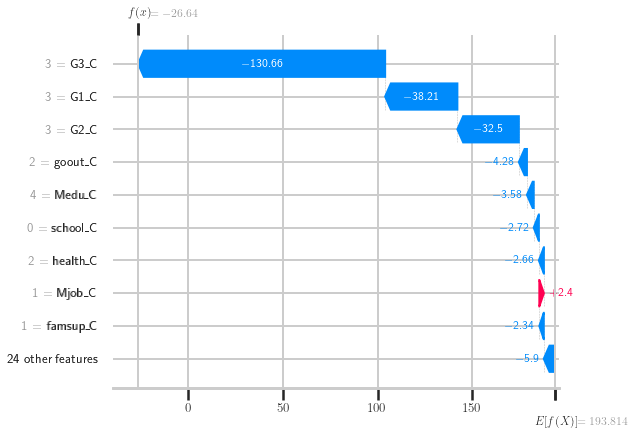

In [23]:
shap.plots.waterfall(shap_values[0])

True


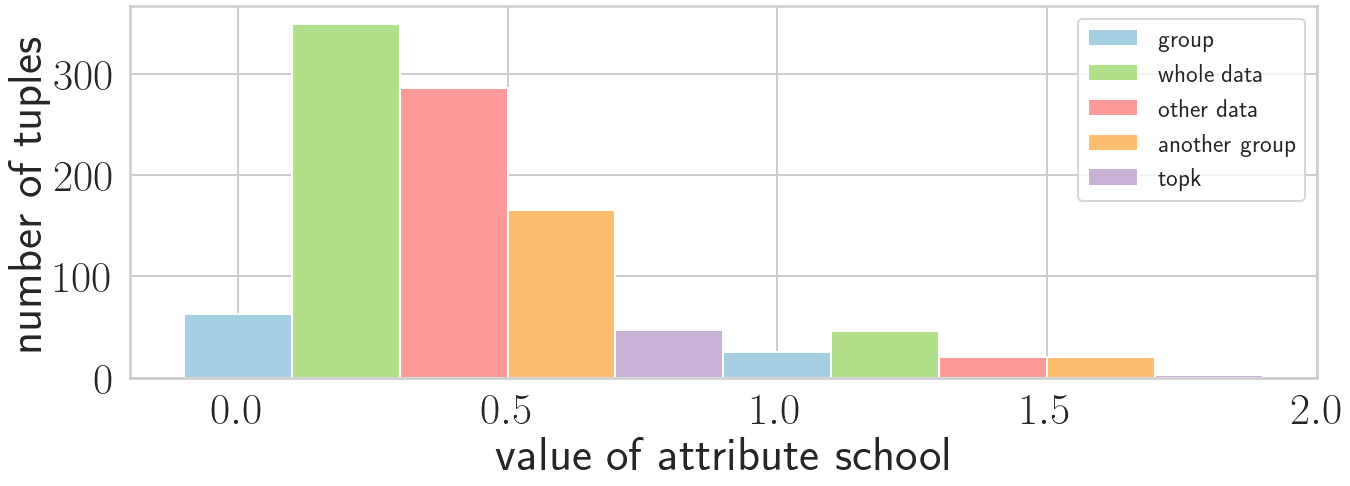

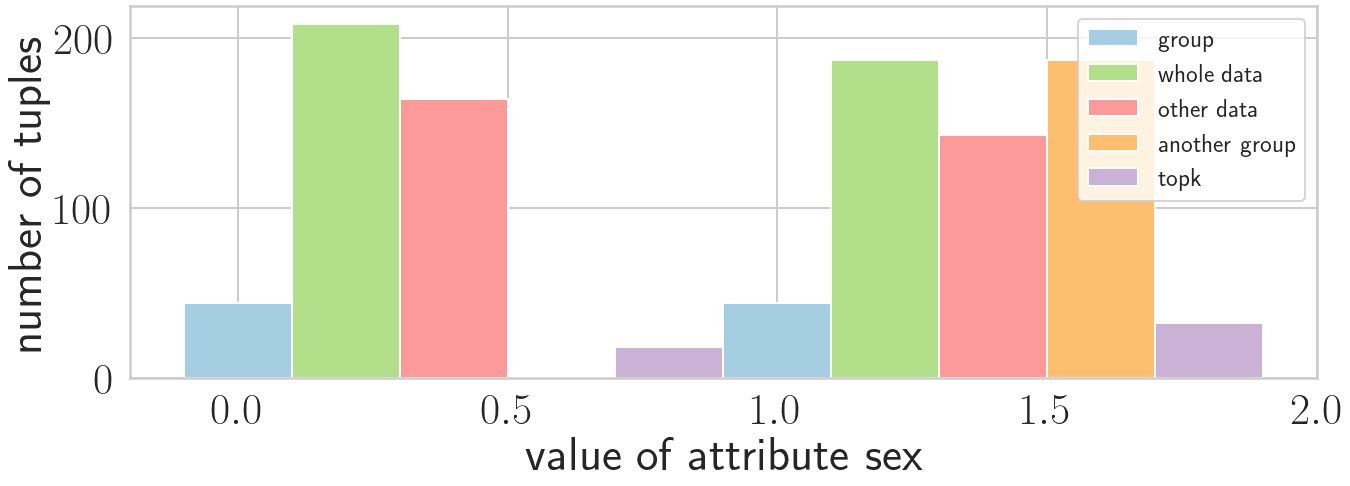

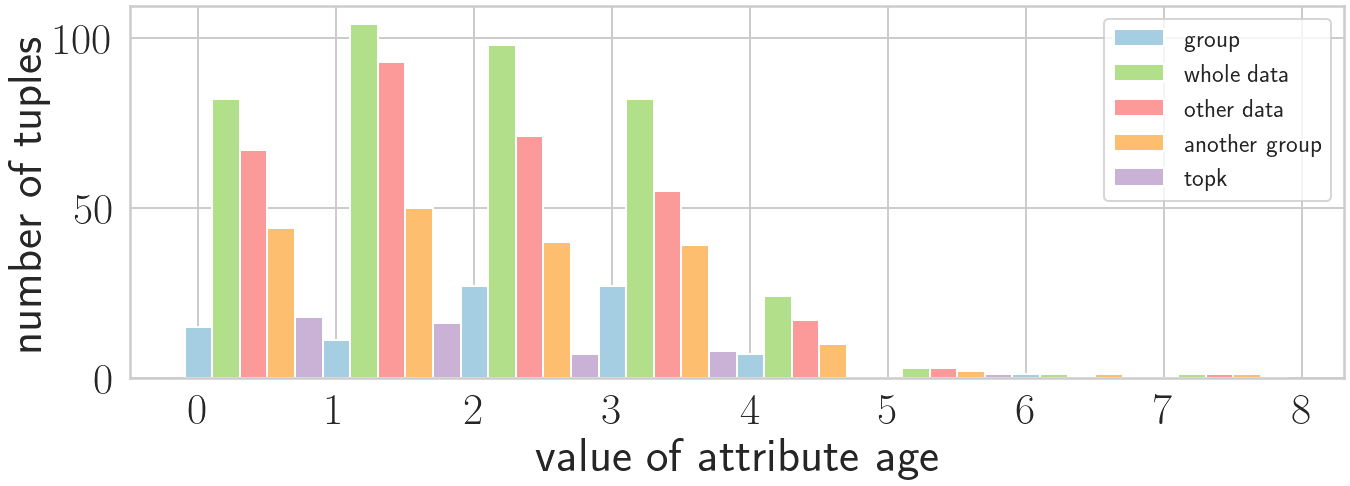

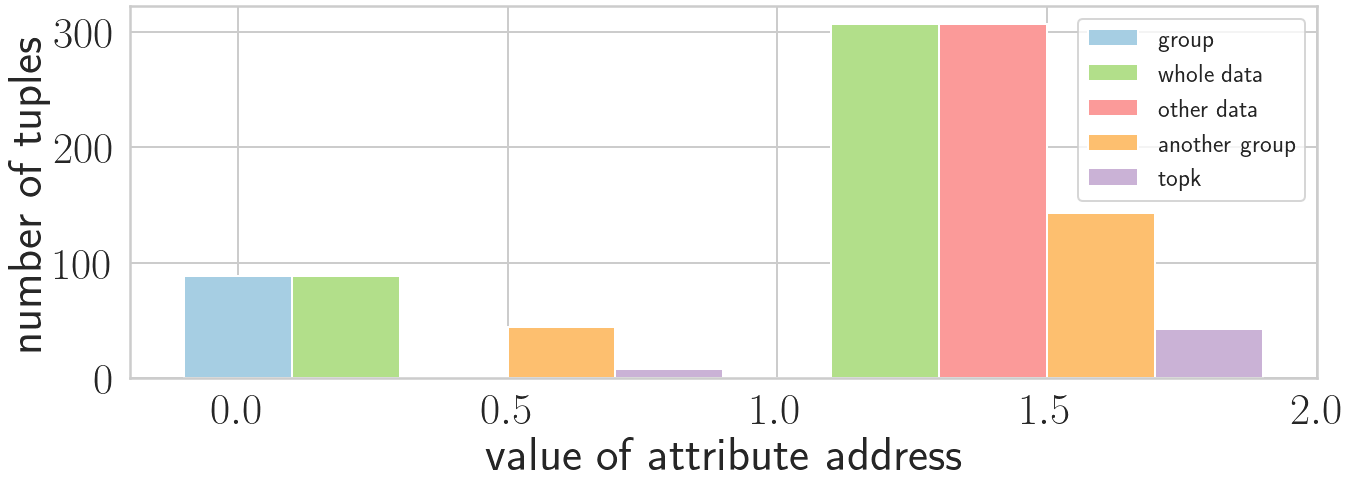

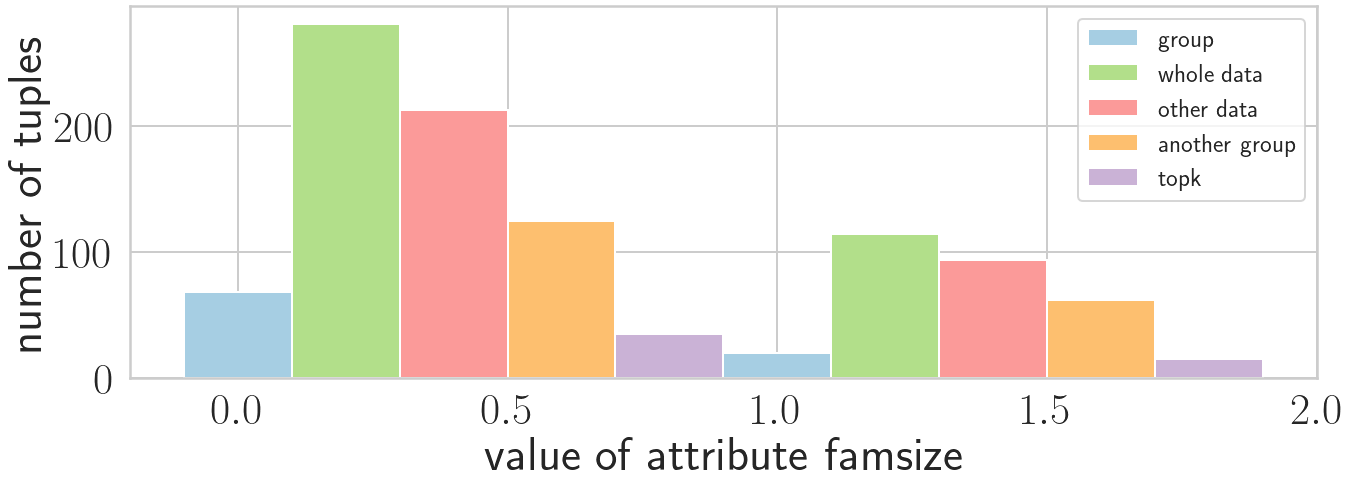

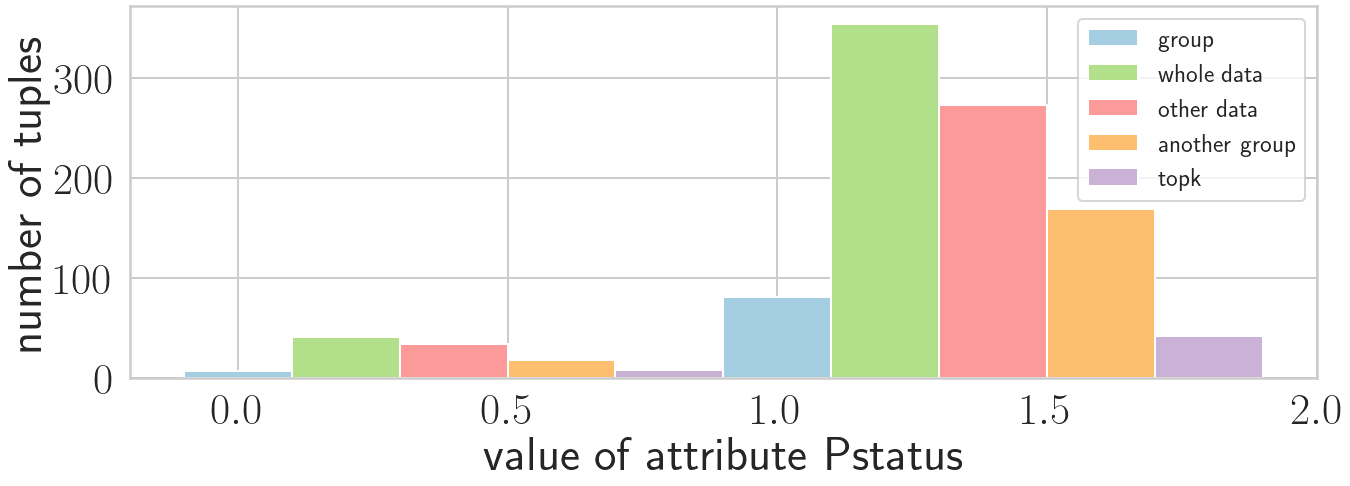

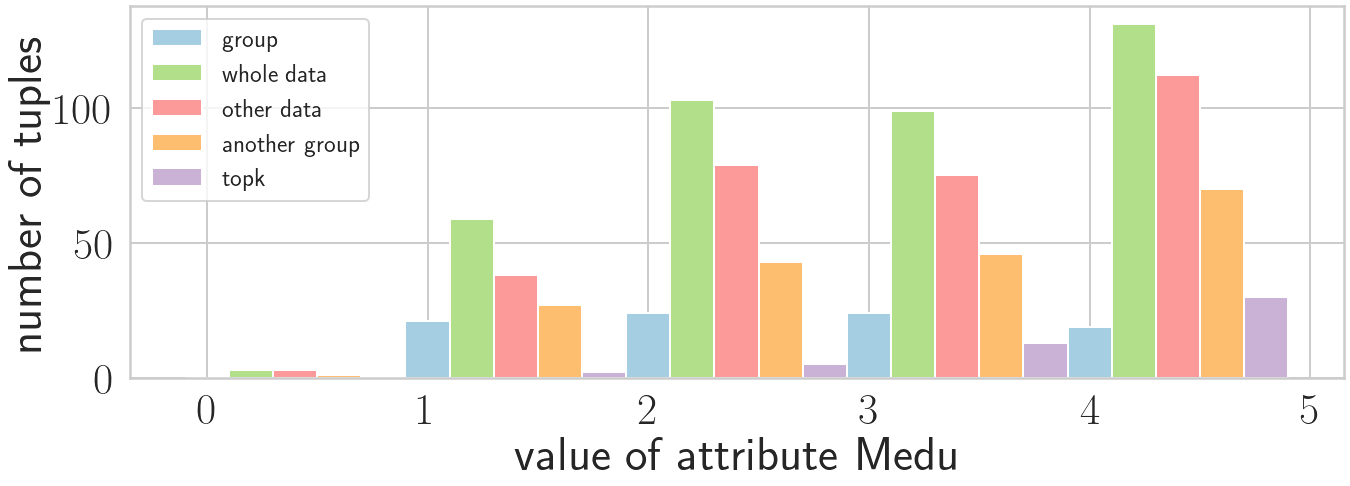

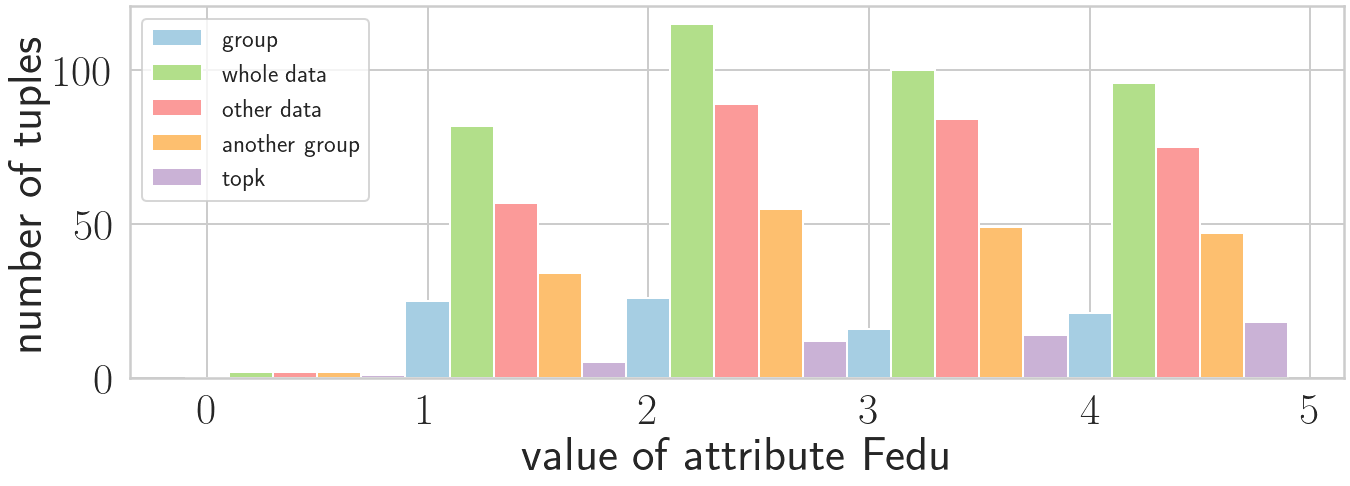

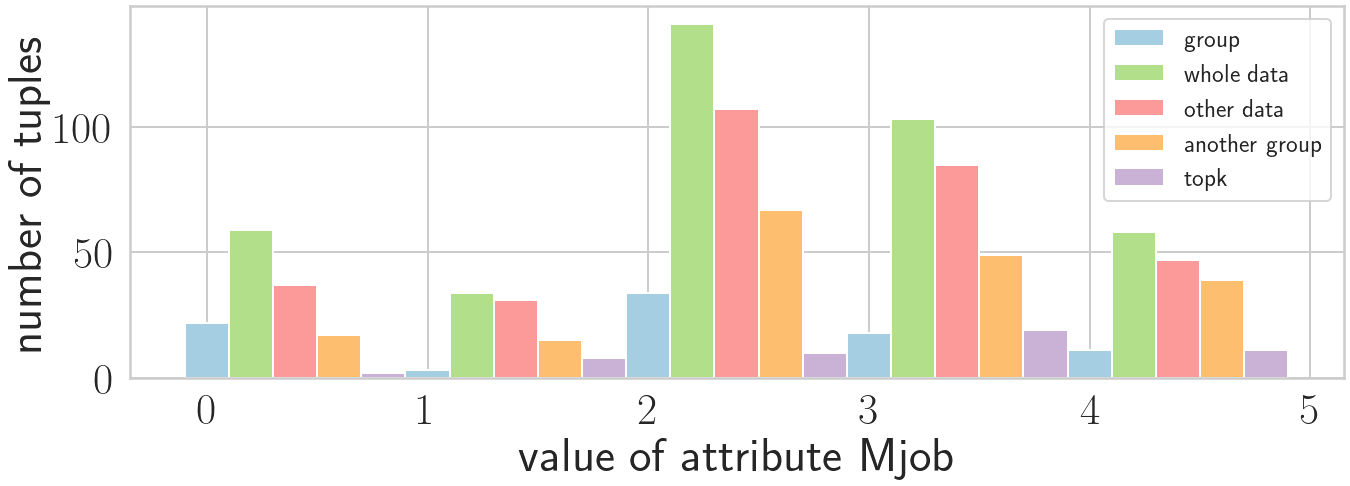

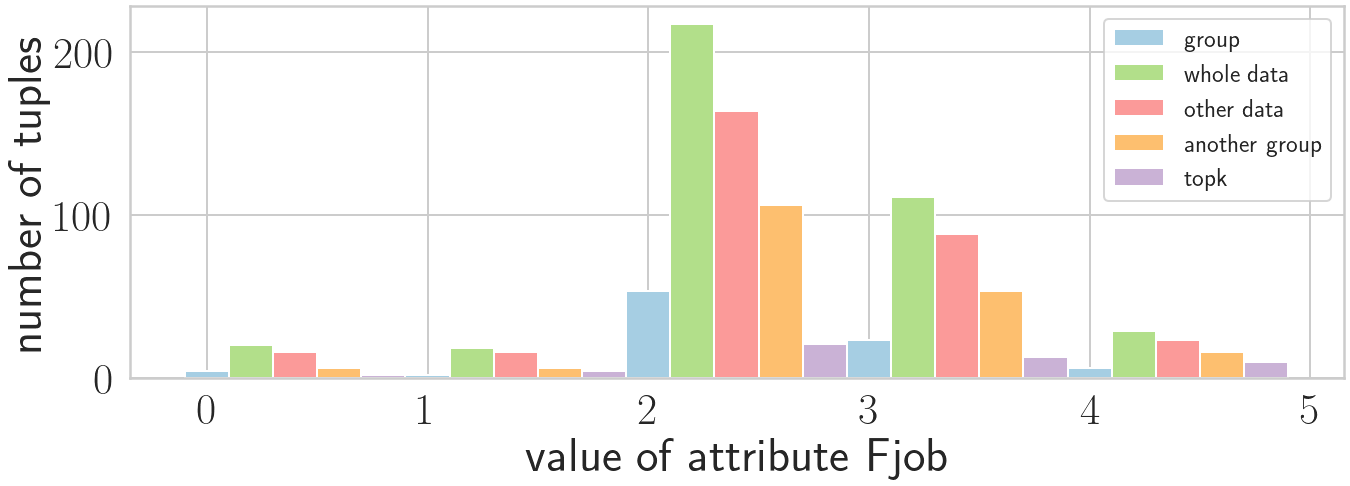

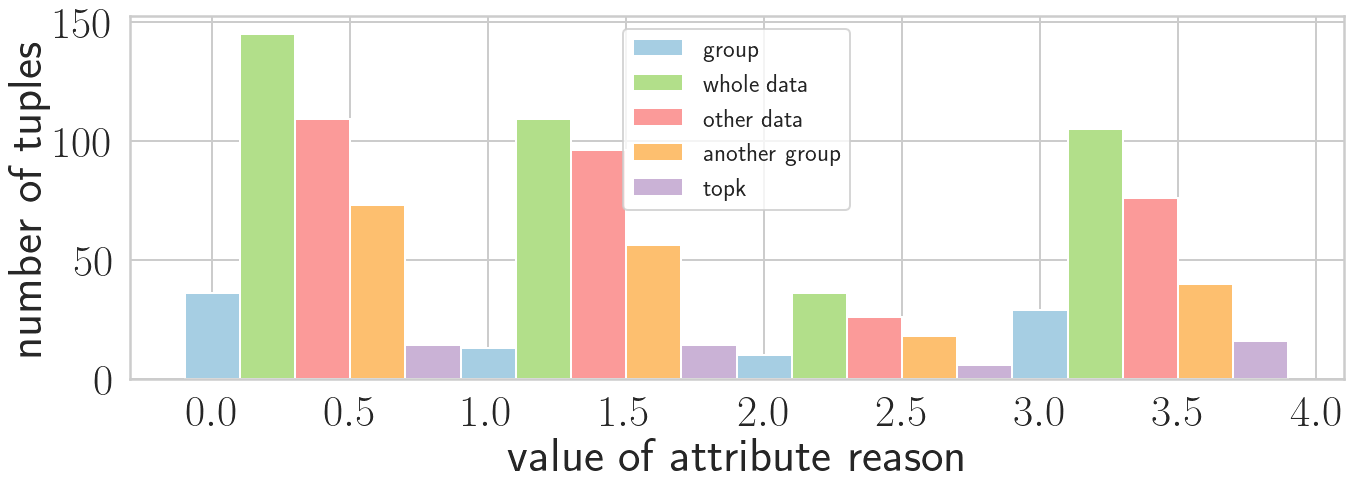

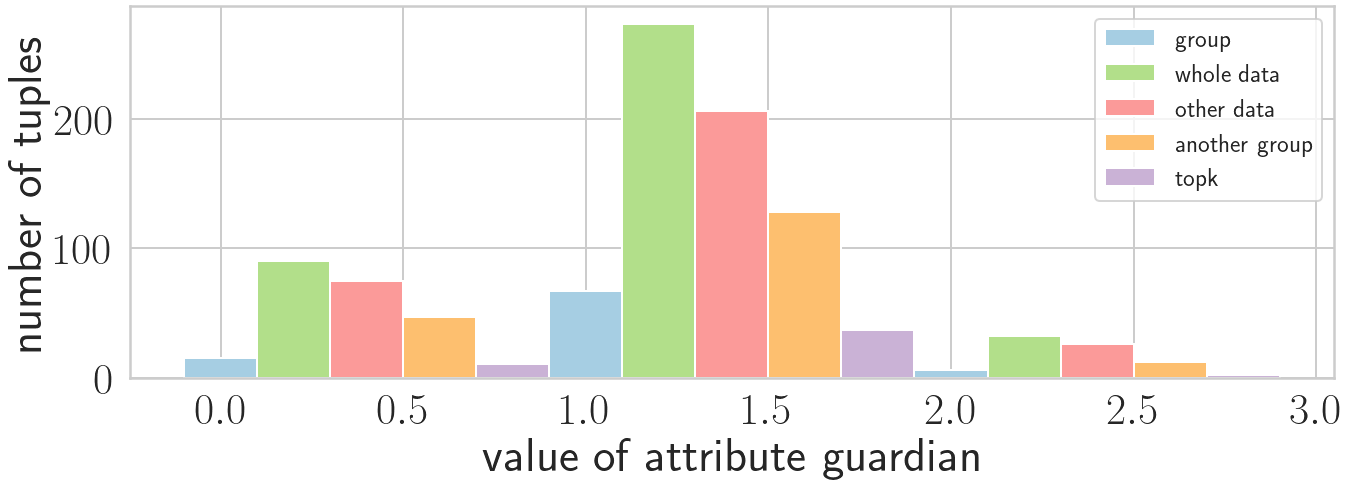

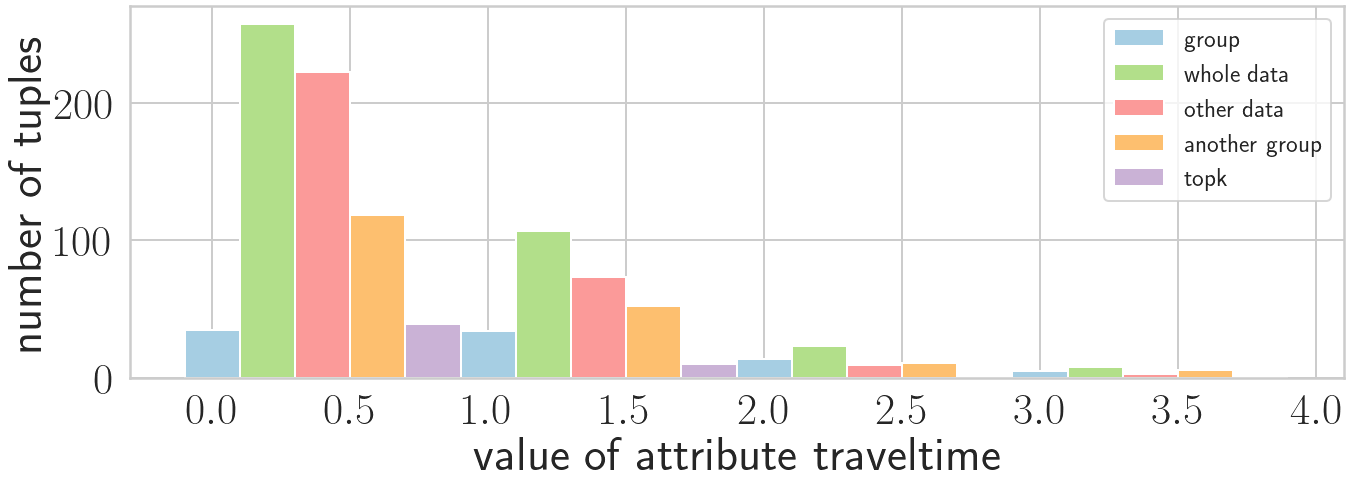

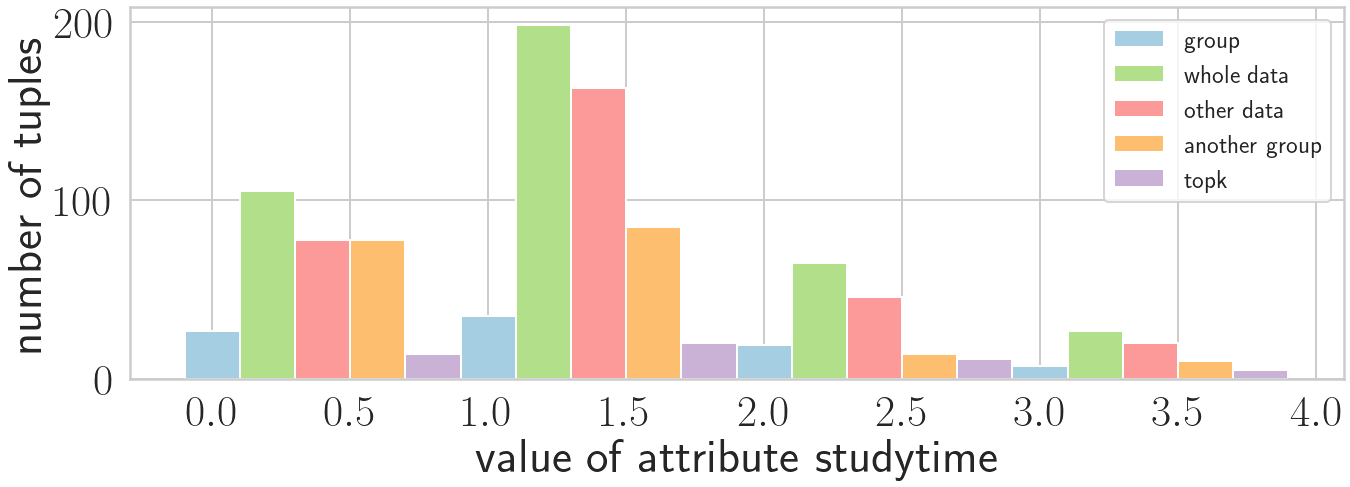

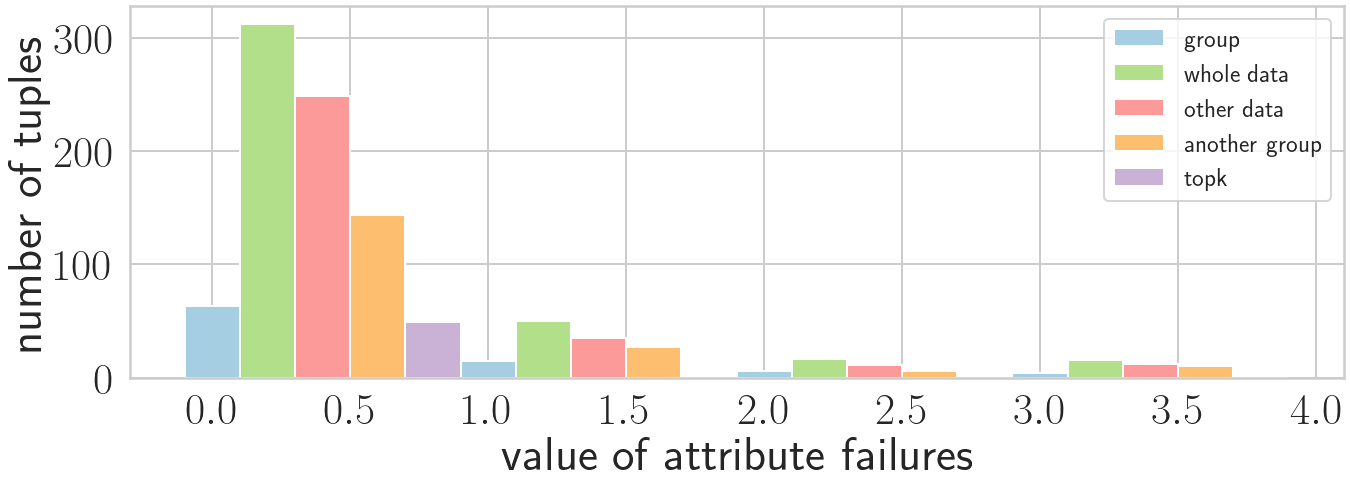

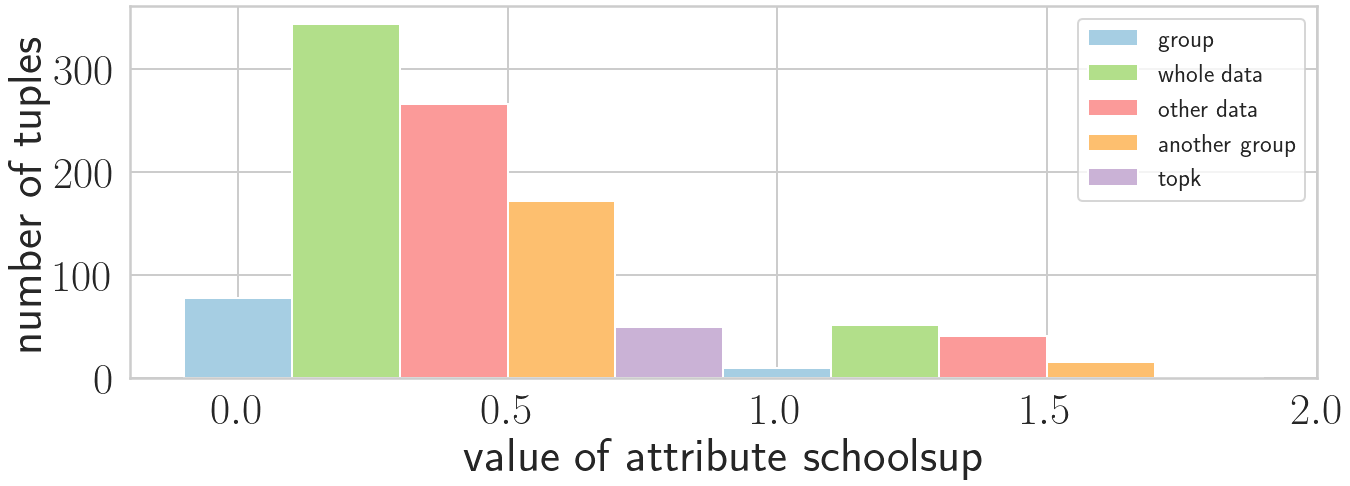

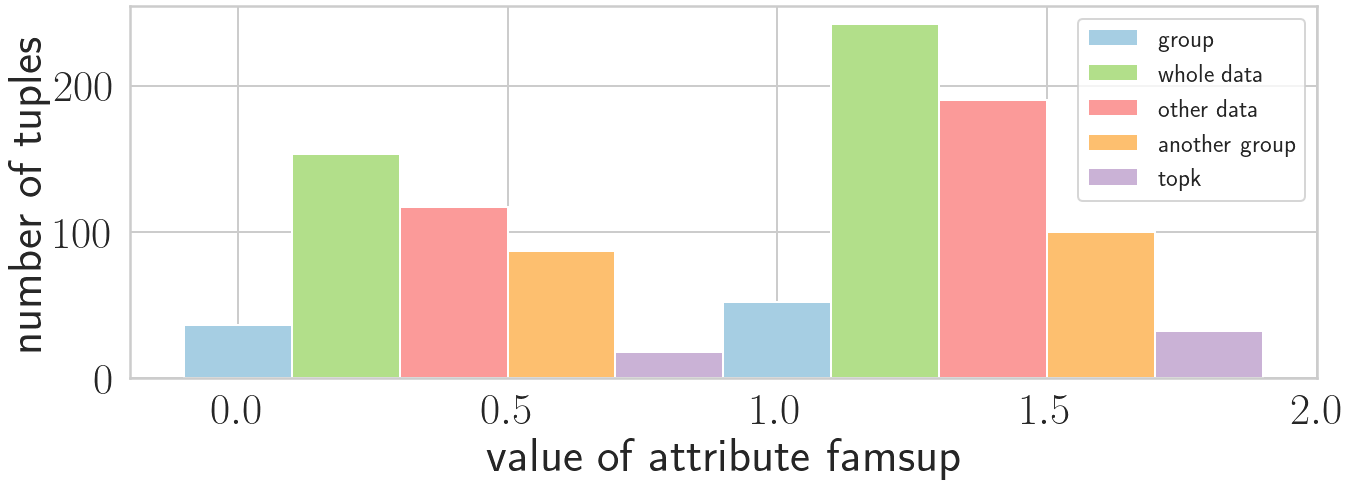

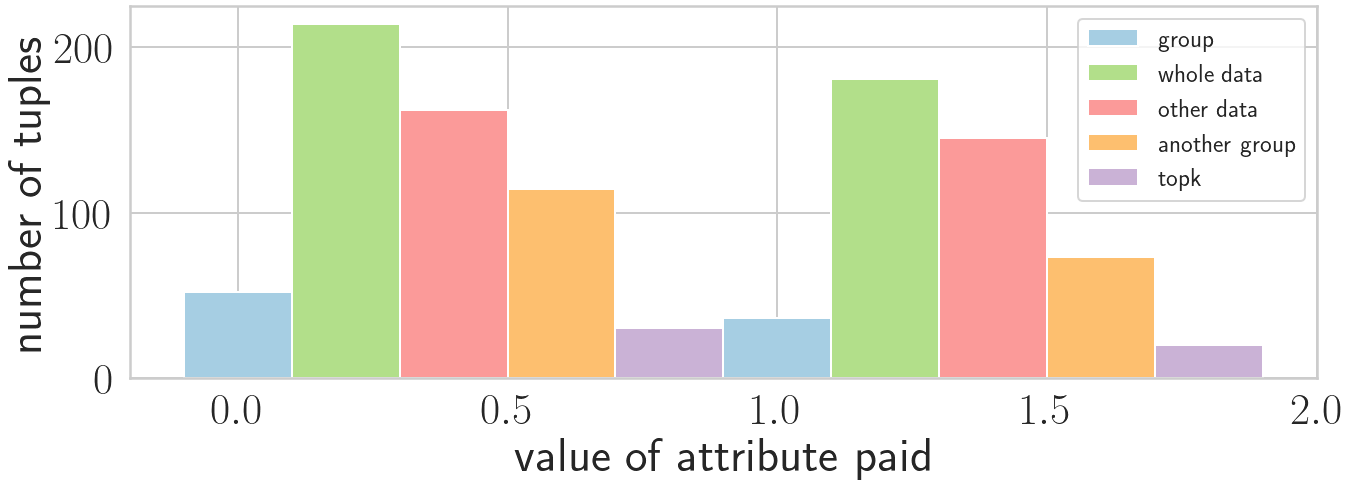

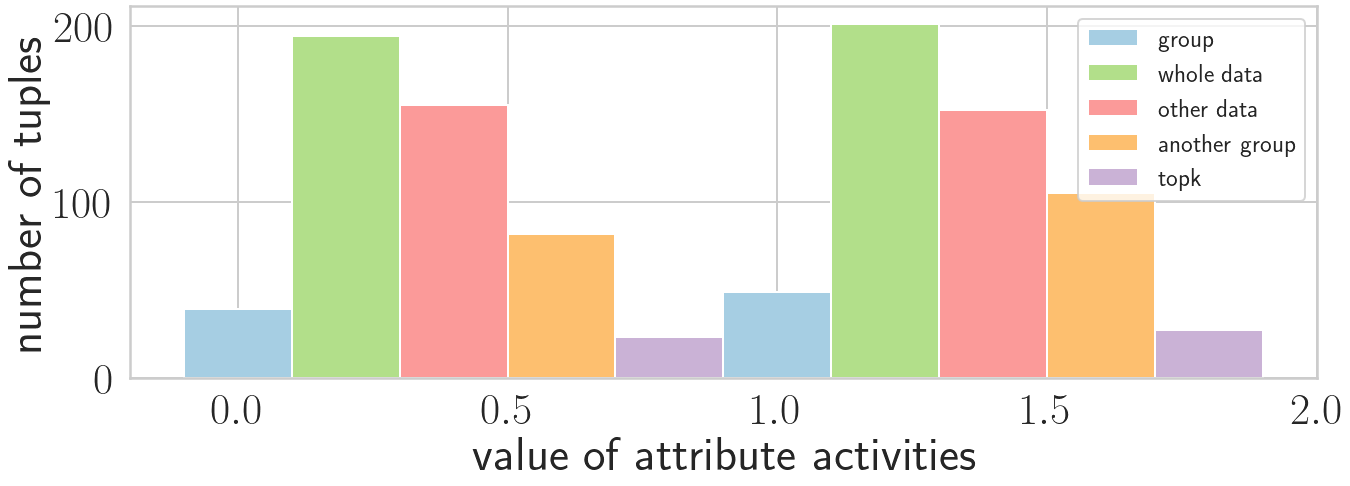

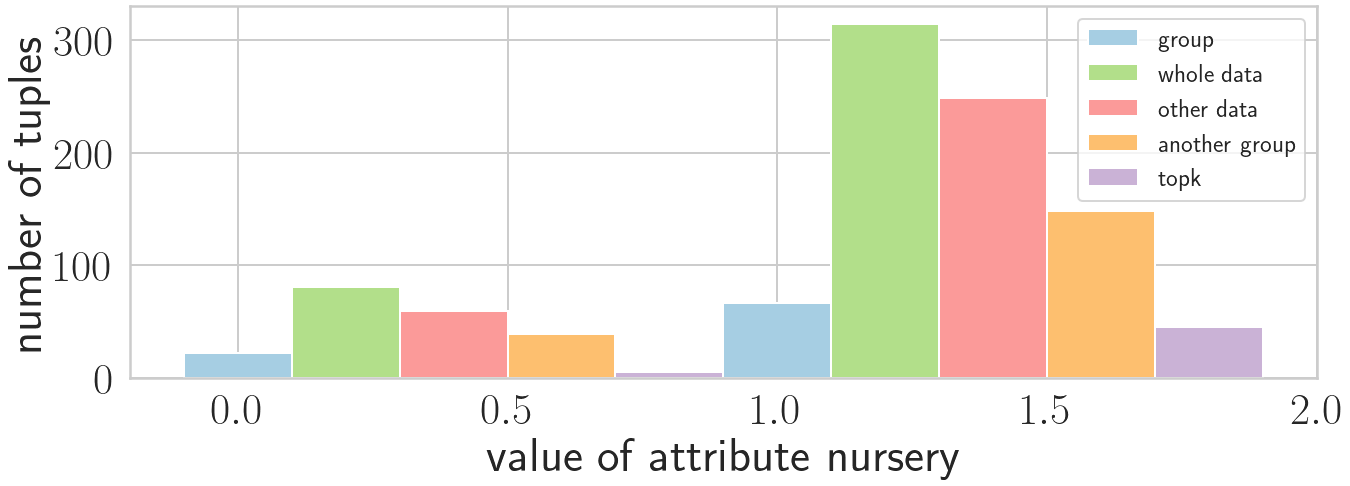

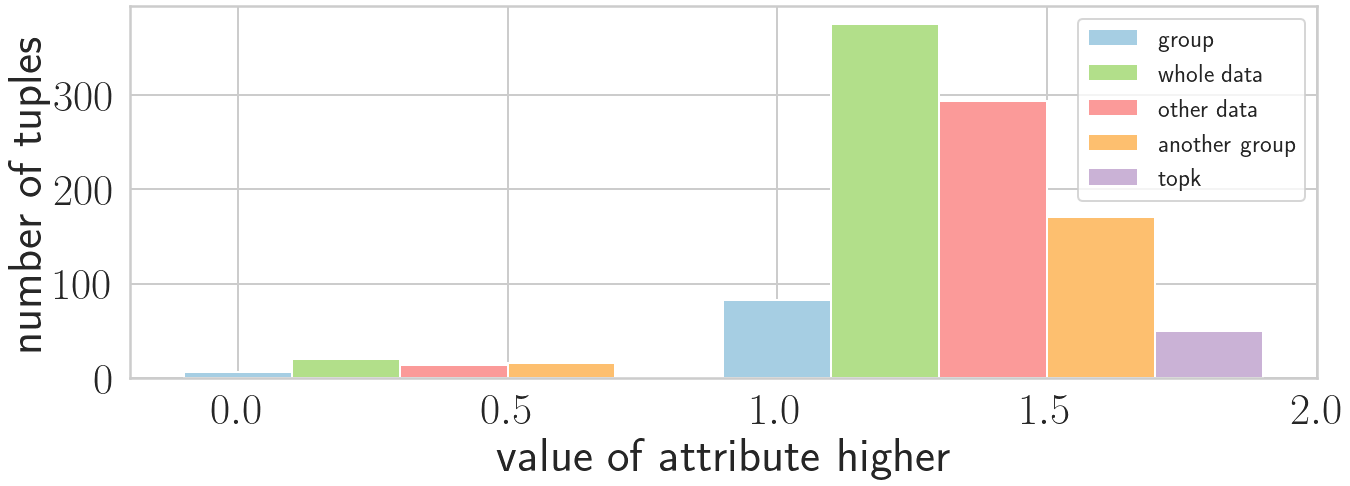

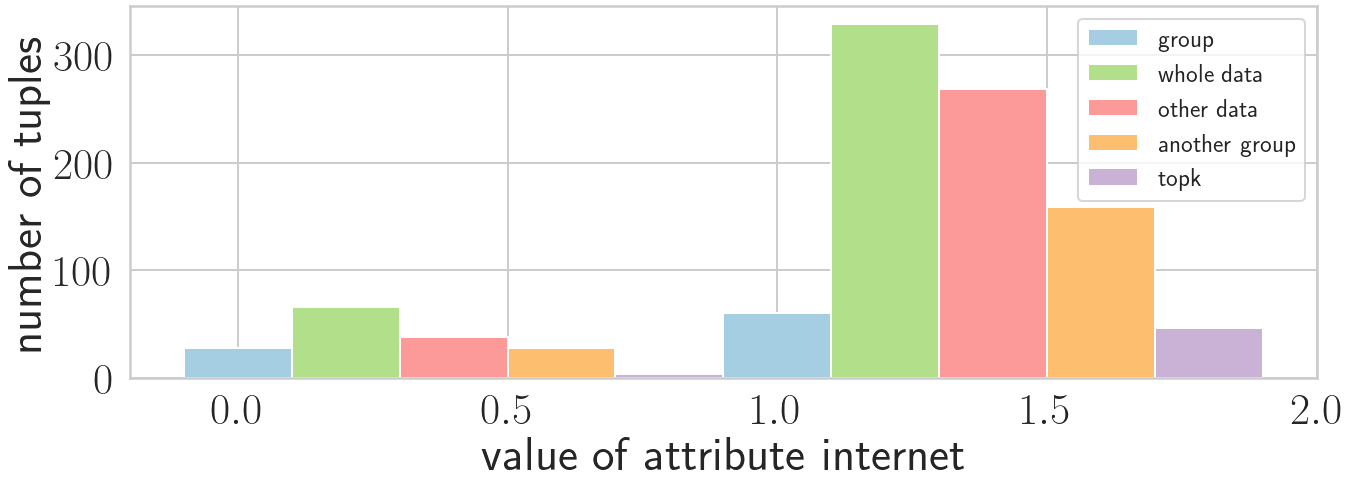

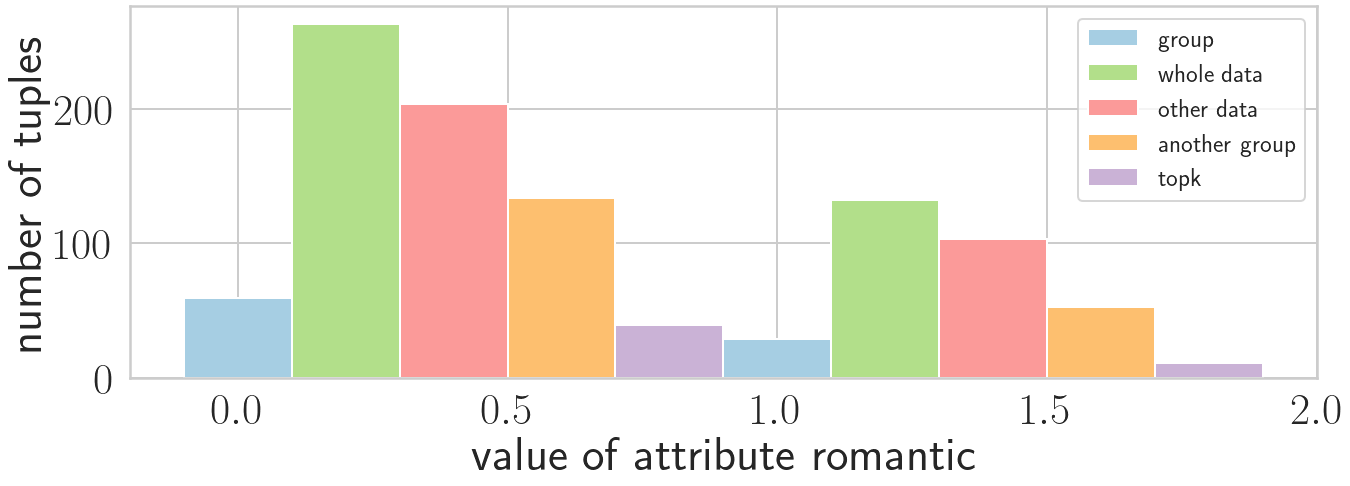

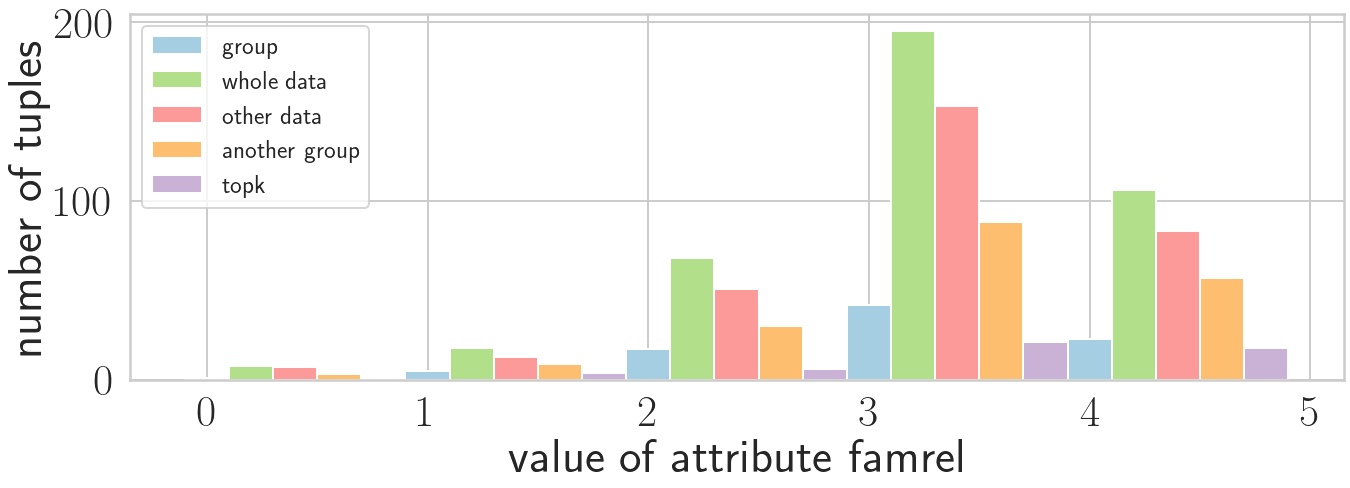

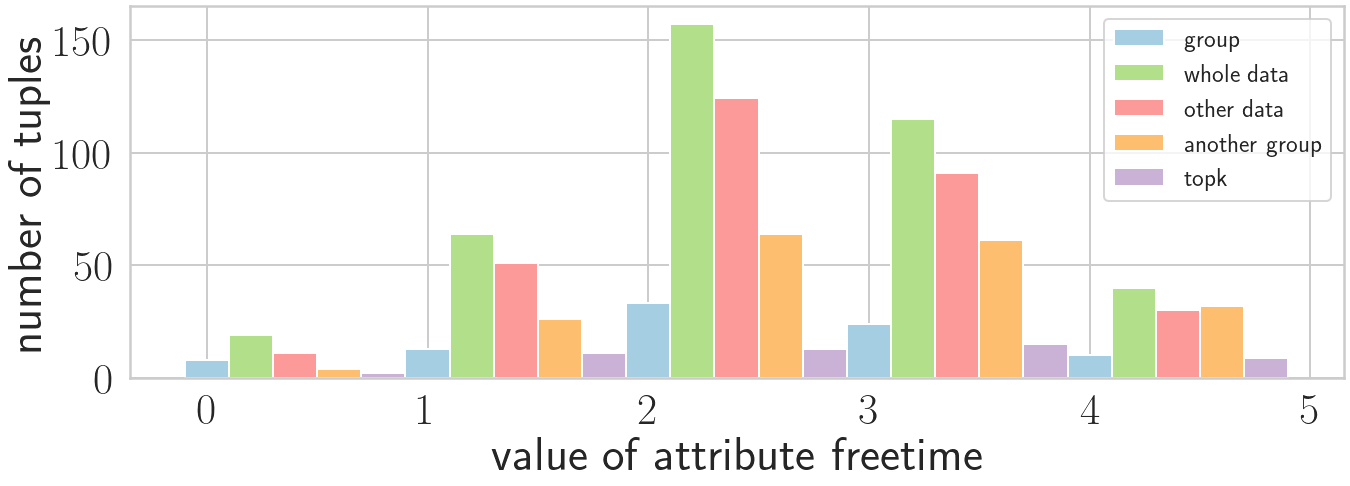

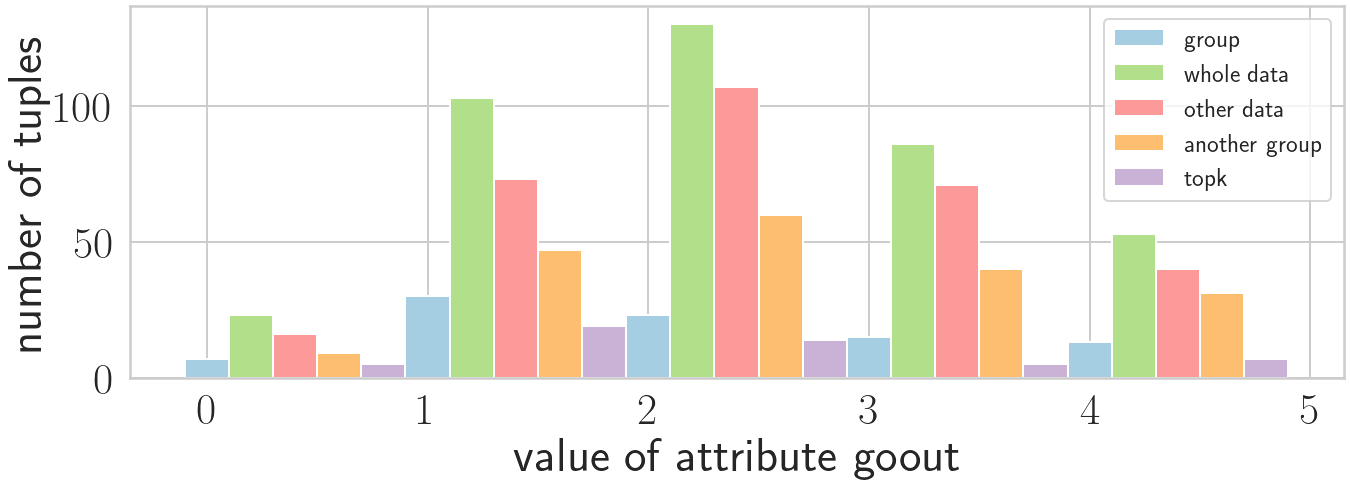

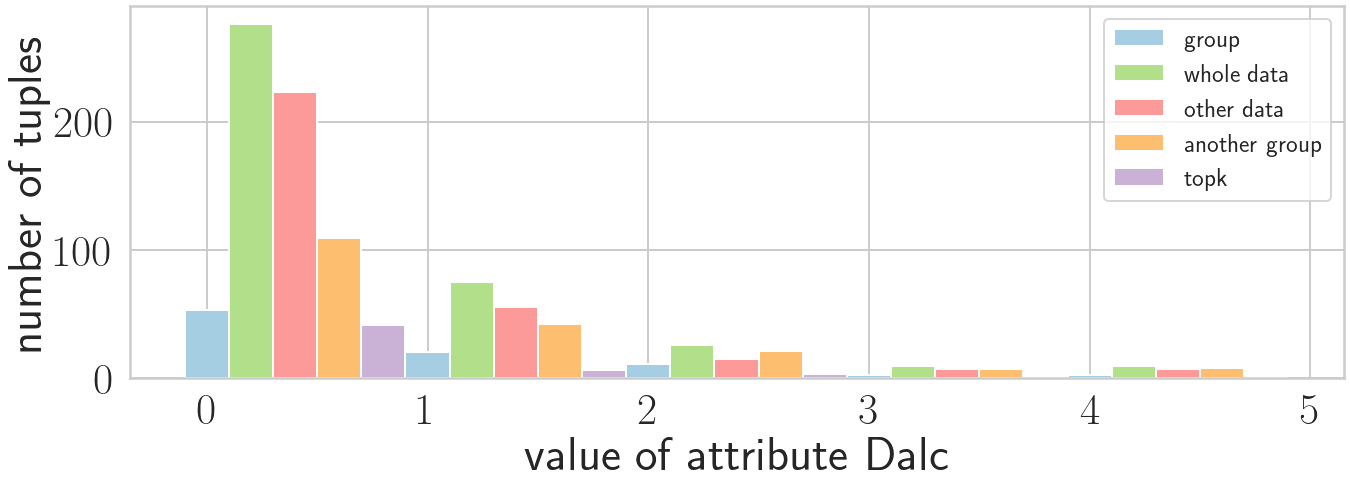

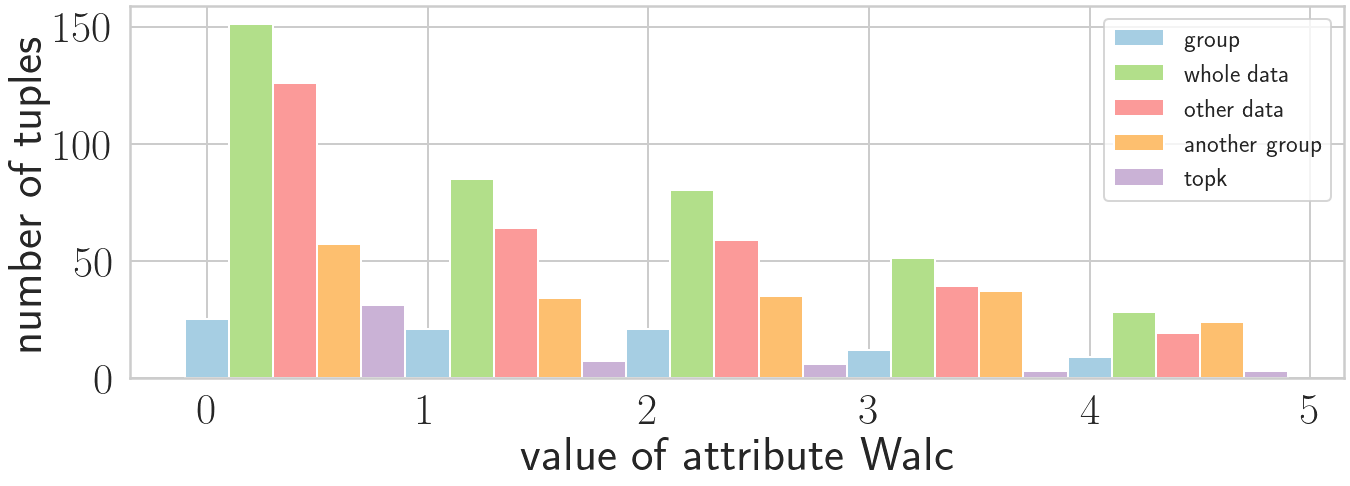

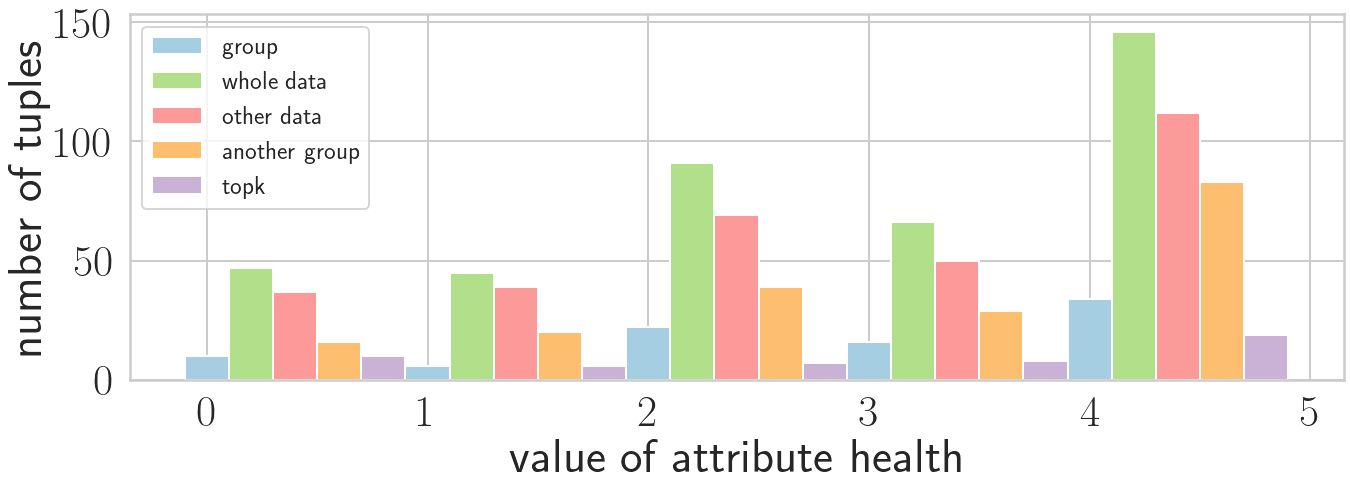

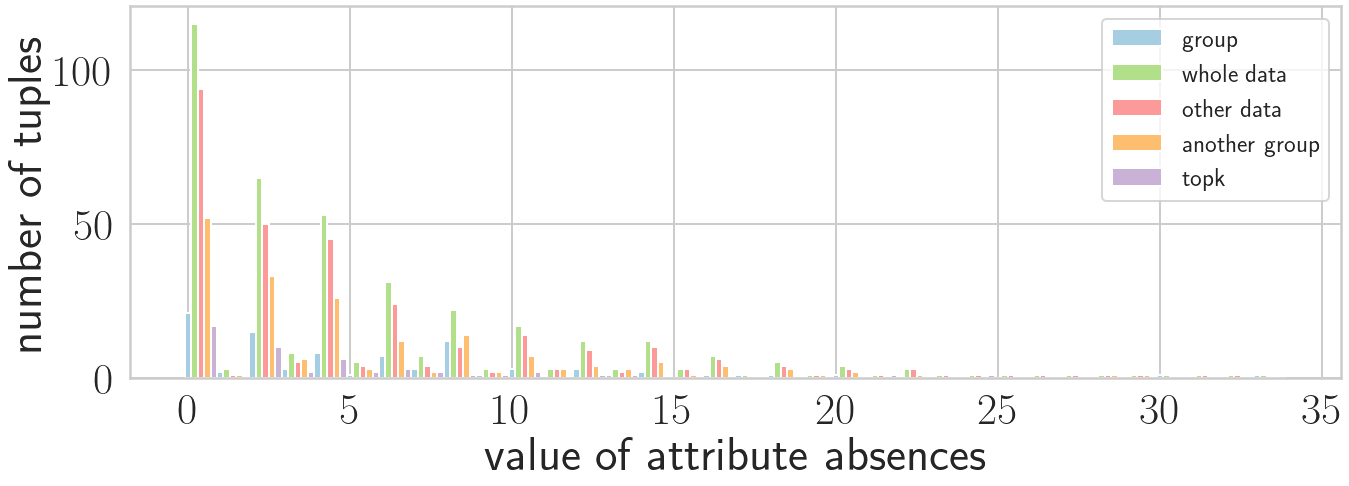

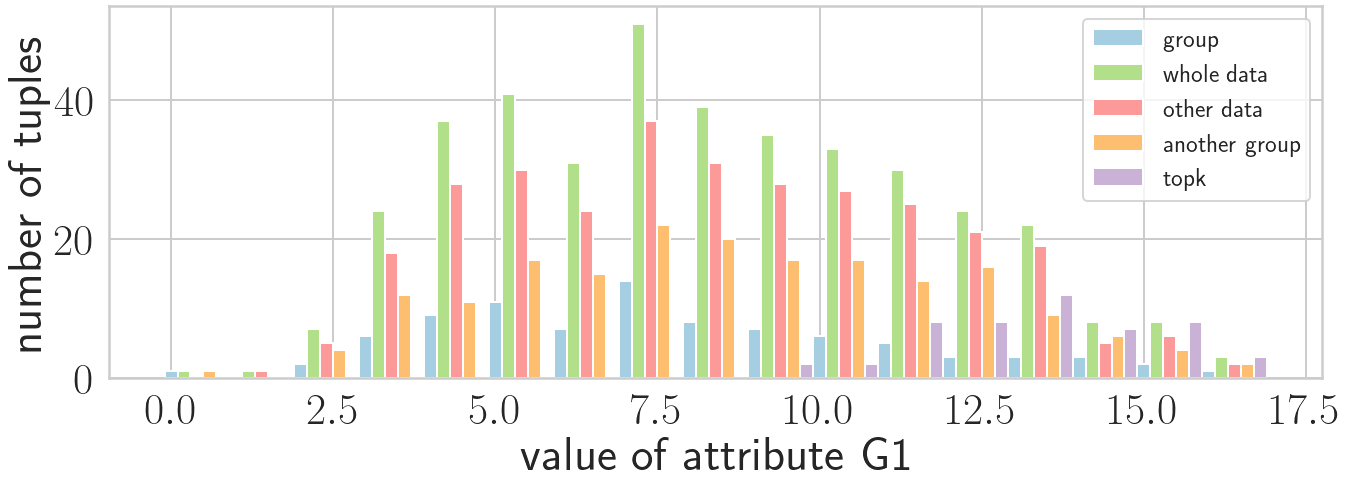

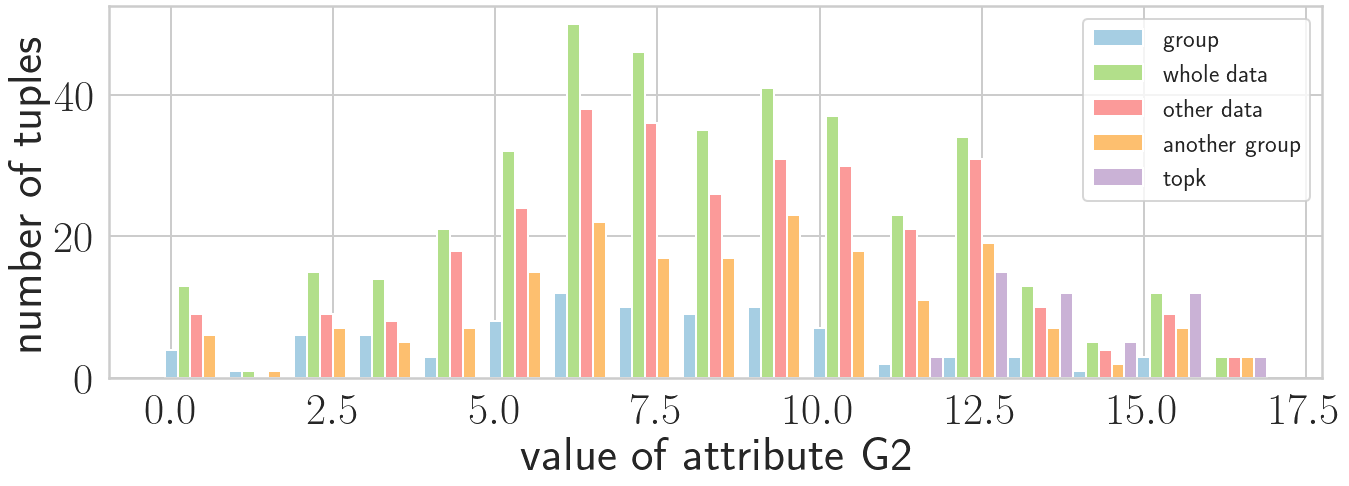

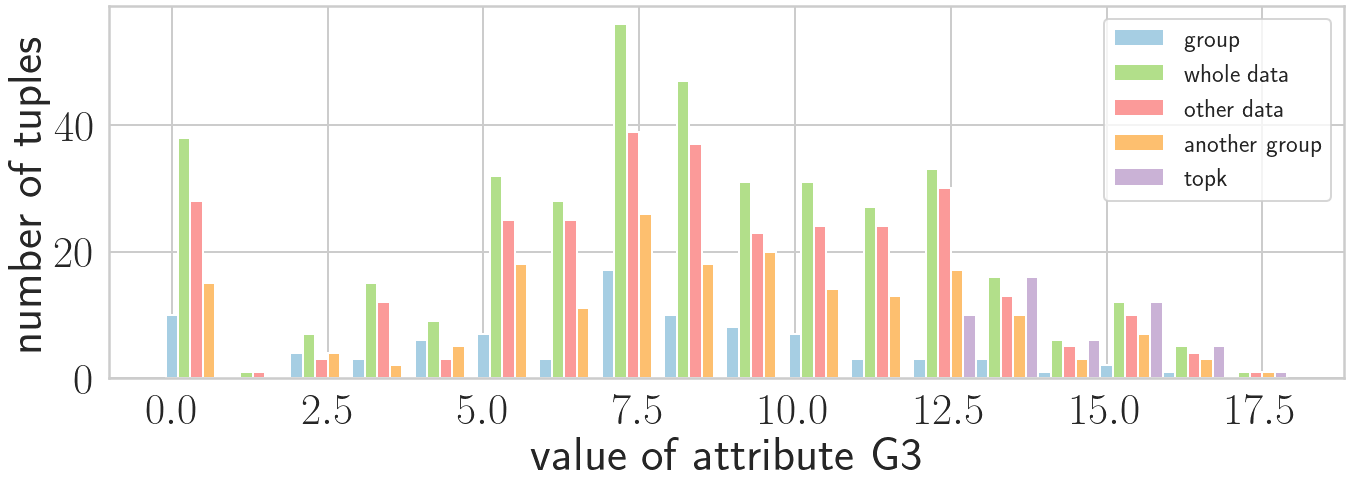

In [28]:
another_group = [-1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
print(check_another_group_global_bounds(another_group, ranked_data, selected_attributes, thc, Lowerbounds, k))
for att in all_attributes_original:
    plot_distribution_number(ranked_data, att, groups_global_bounds[1], another_group, k)


True
['GP' 'MS']


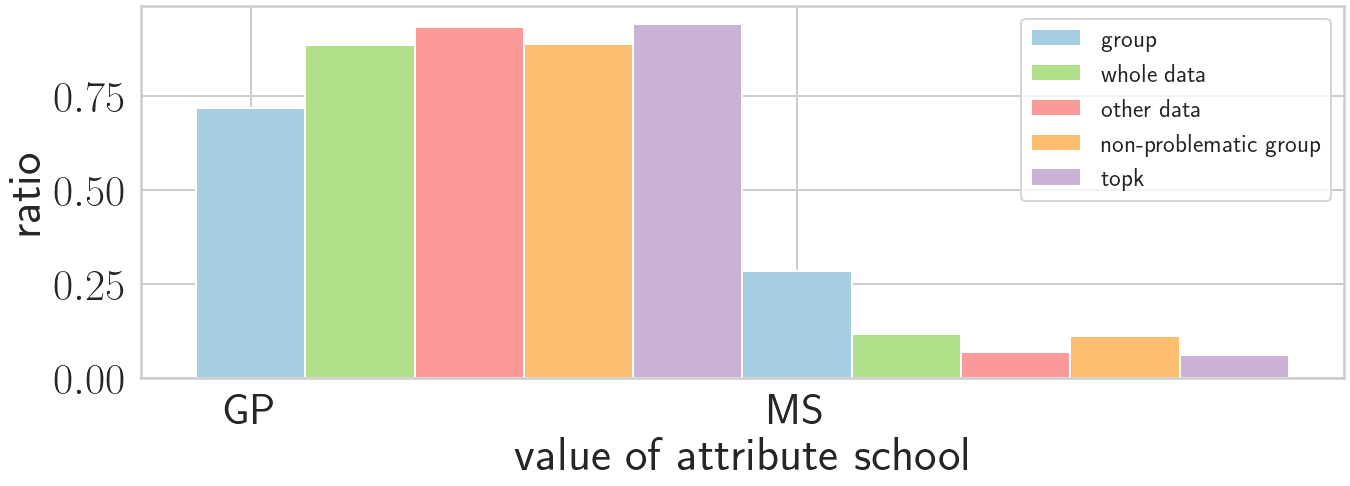

['F' 'M']


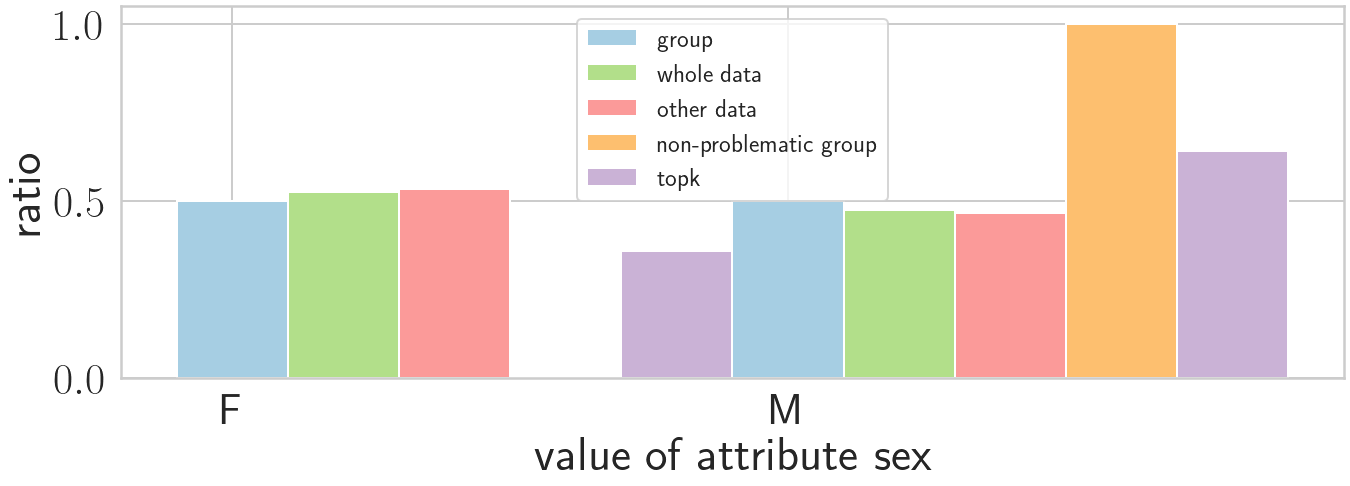

[15 16 17 18 19 20 21 22]


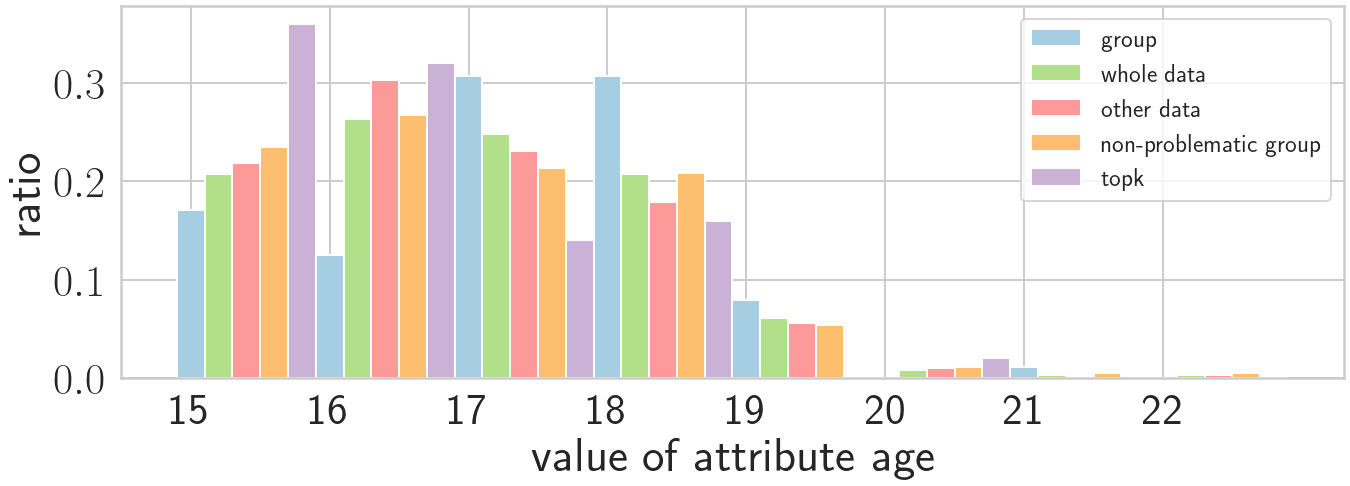

['R' 'U']


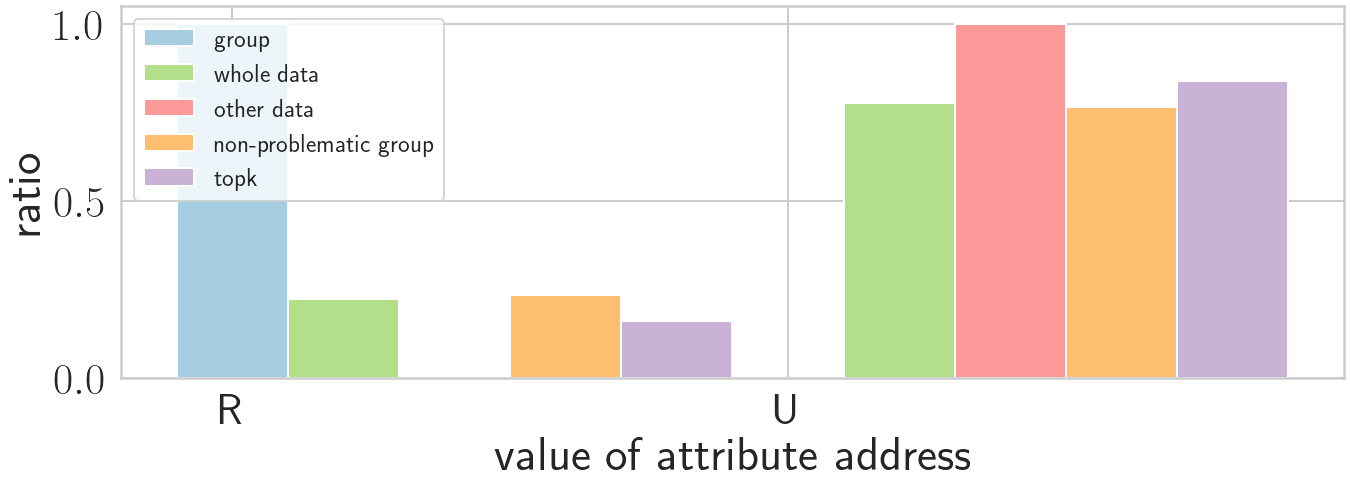

['GT3' 'LE3']


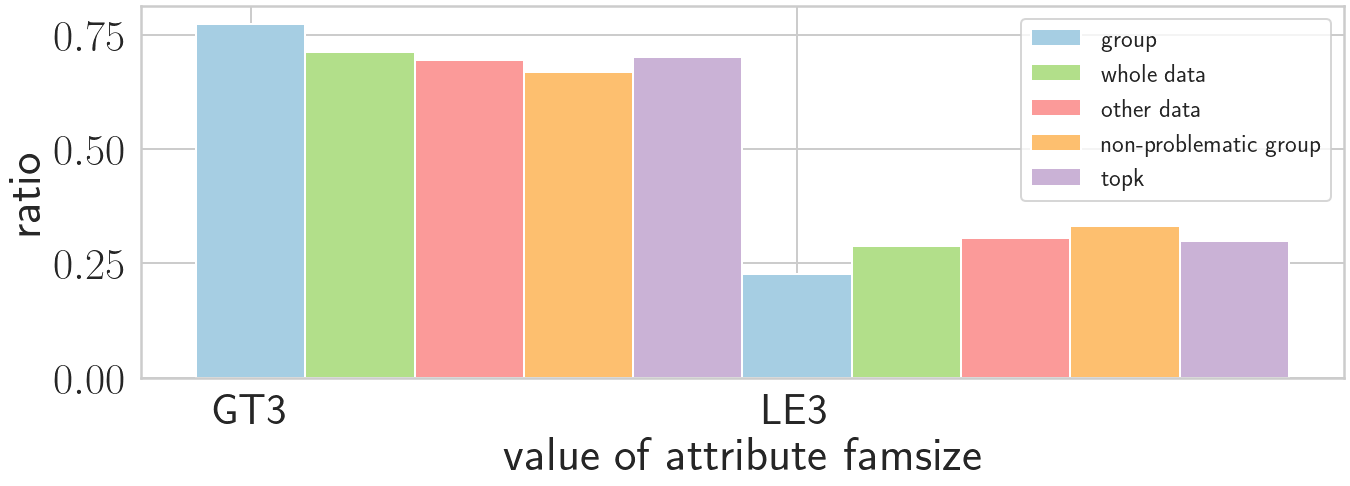

['A' 'T']


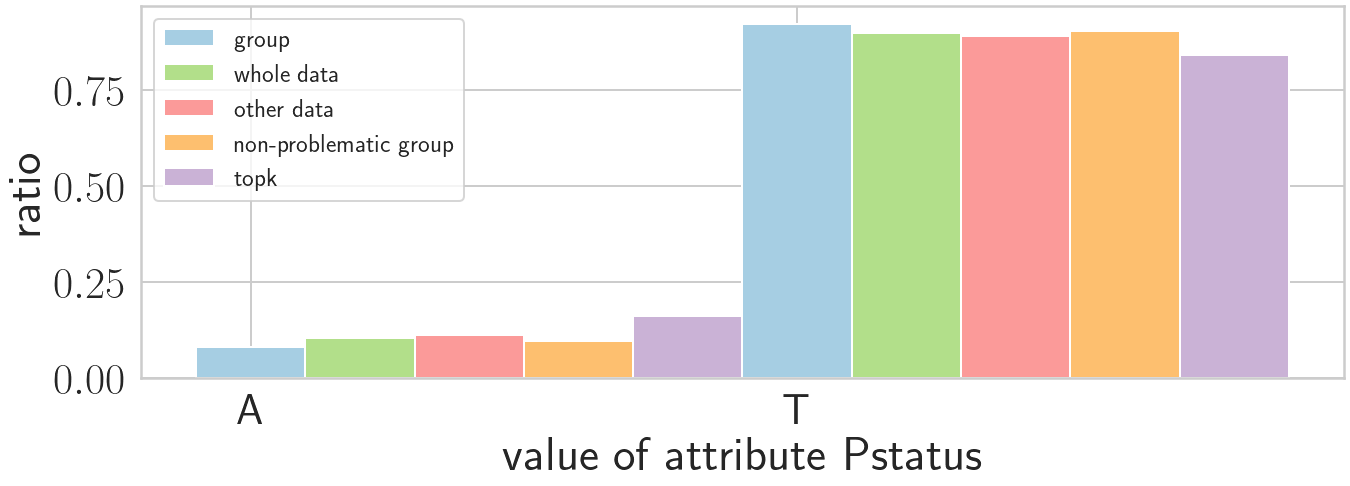

[0 1 2 3 4]


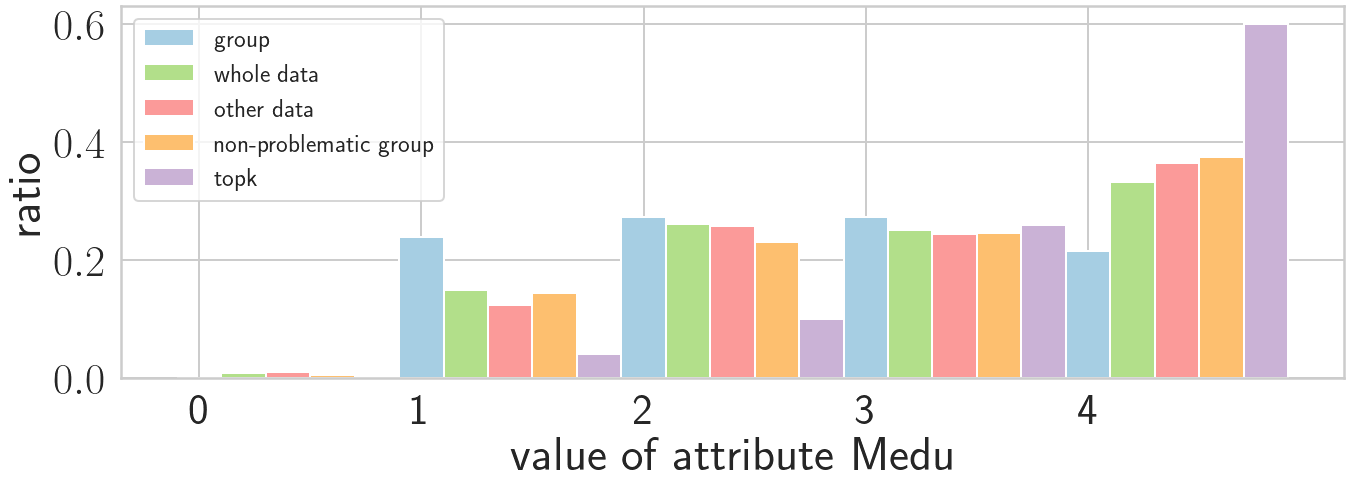

[0 1 2 3 4]


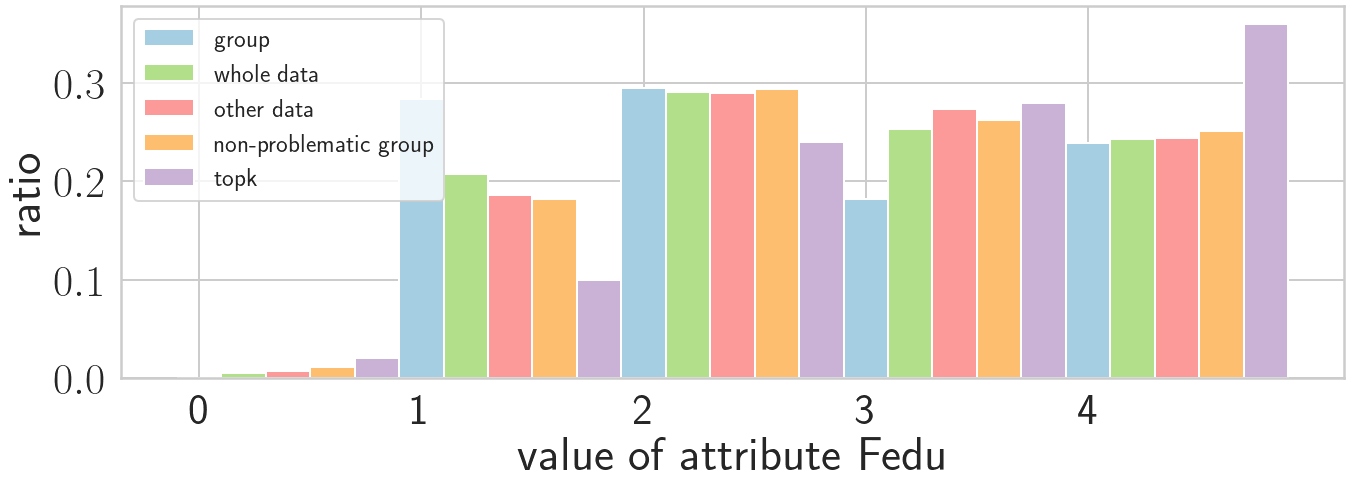

['at_home' 'health' 'other' 'services' 'teacher']


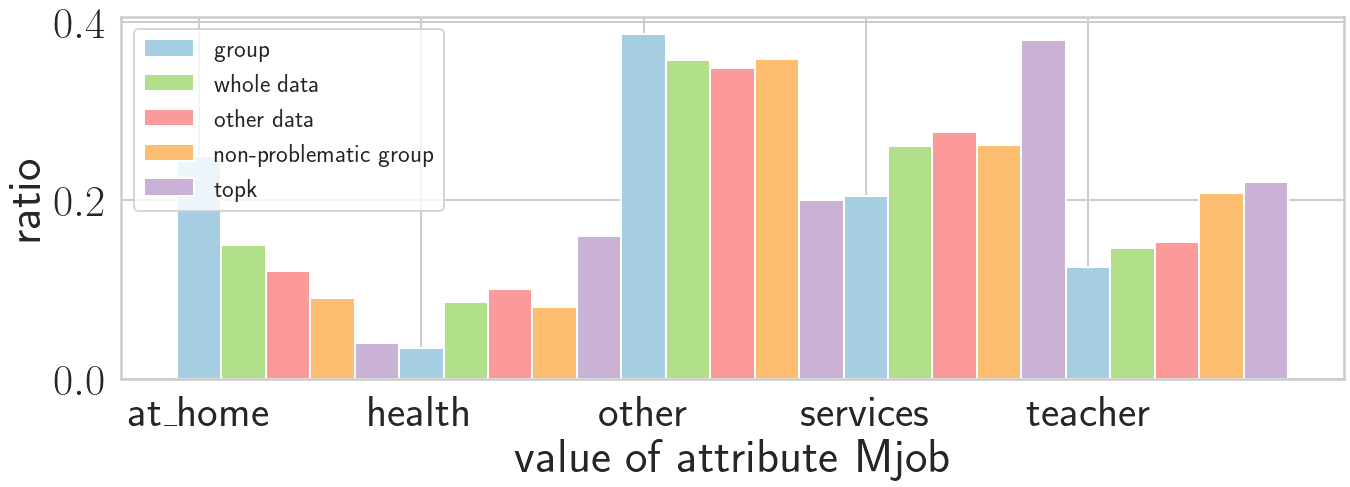

['at_home' 'health' 'other' 'services' 'teacher']


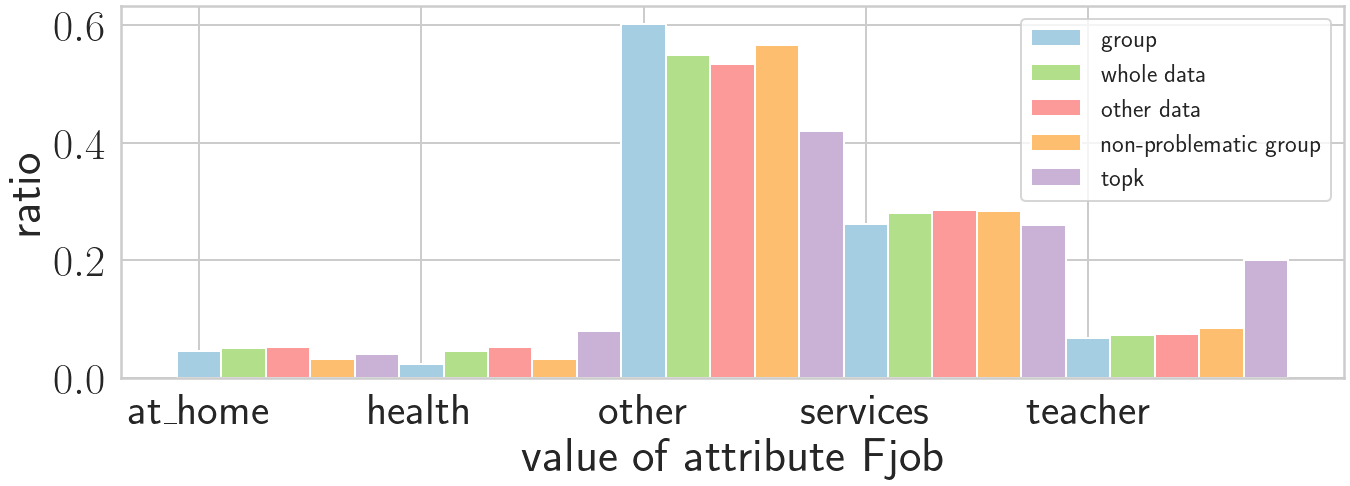

['course' 'home' 'other' 'reputation']


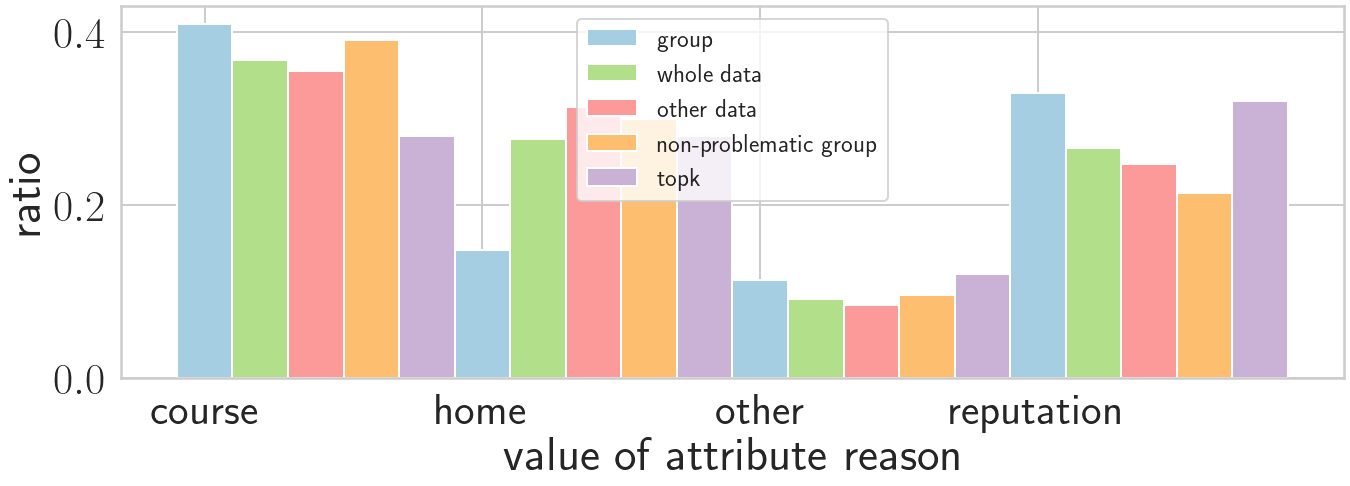

['father' 'mother' 'other']


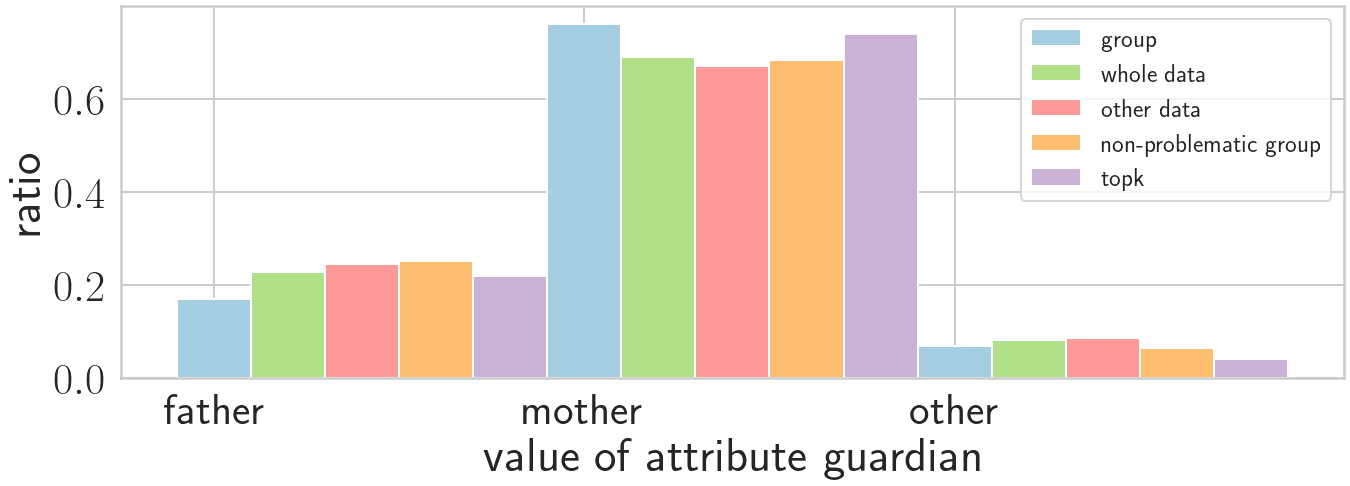

[1 2 3 4]


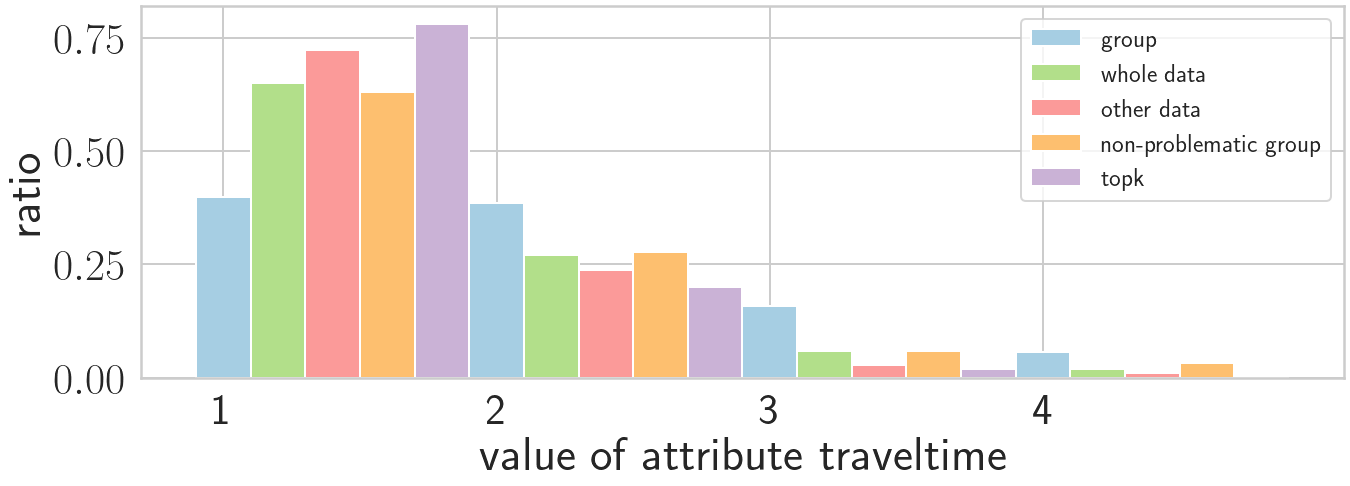

[1 2 3 4]


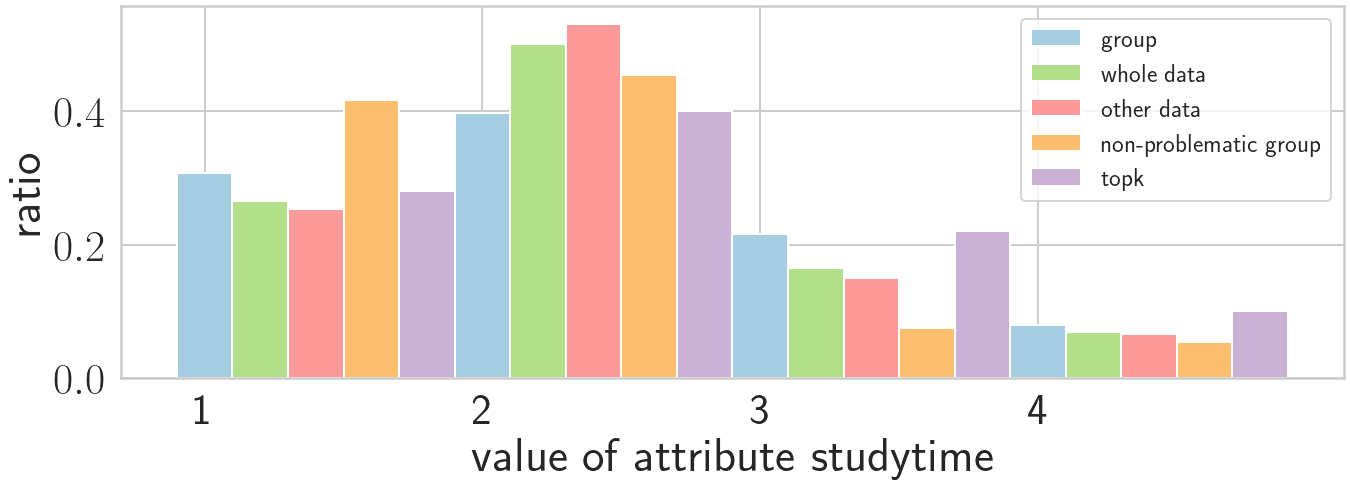

[0 1 2 3]


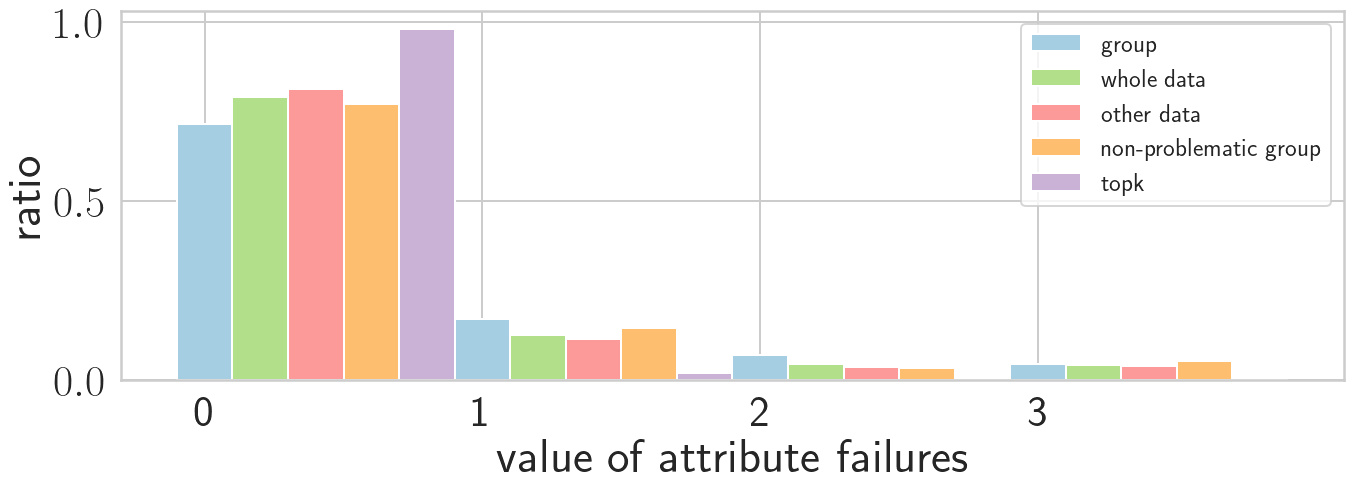

['no' 'yes']


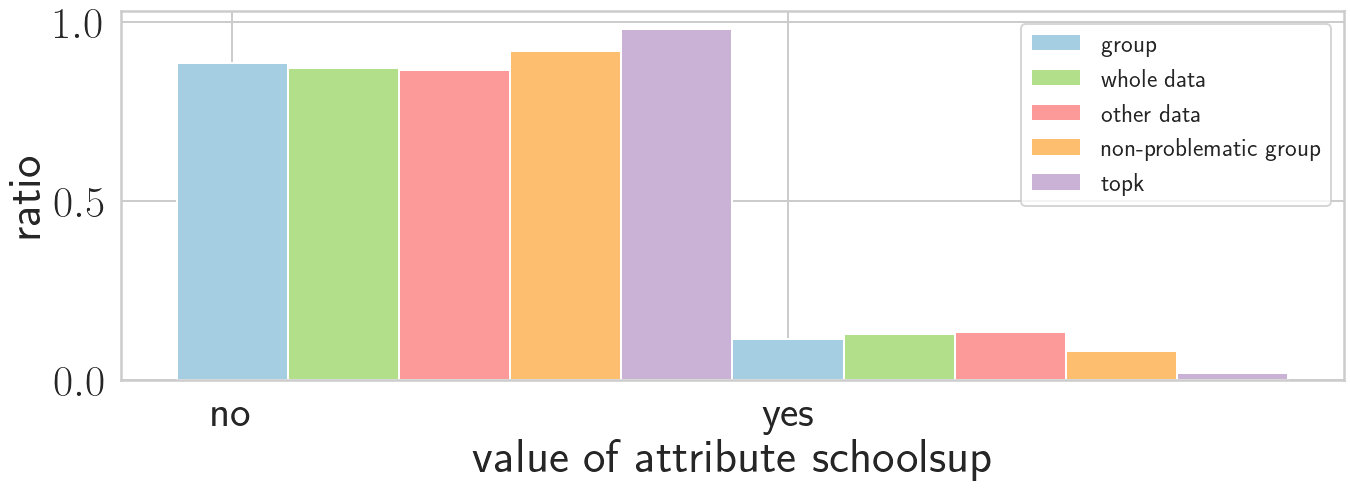

['no' 'yes']


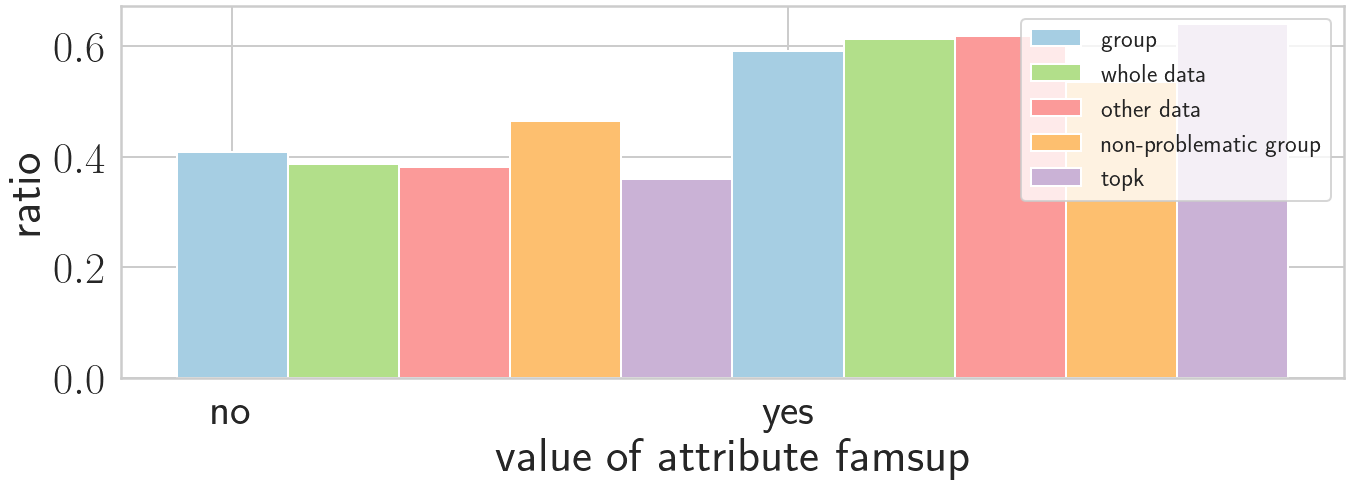

['no' 'yes']


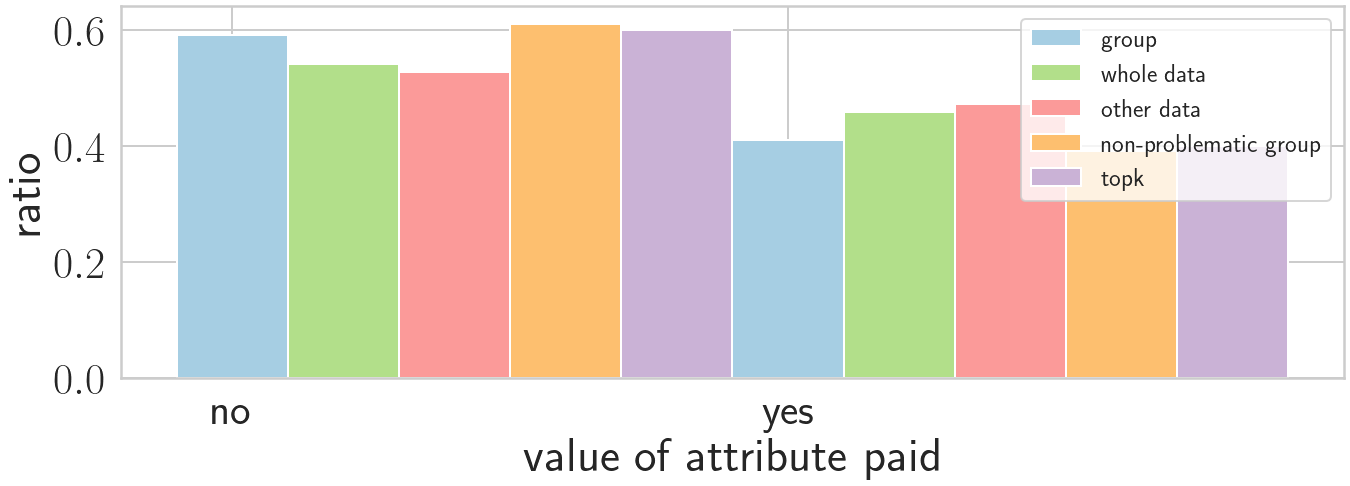

['no' 'yes']


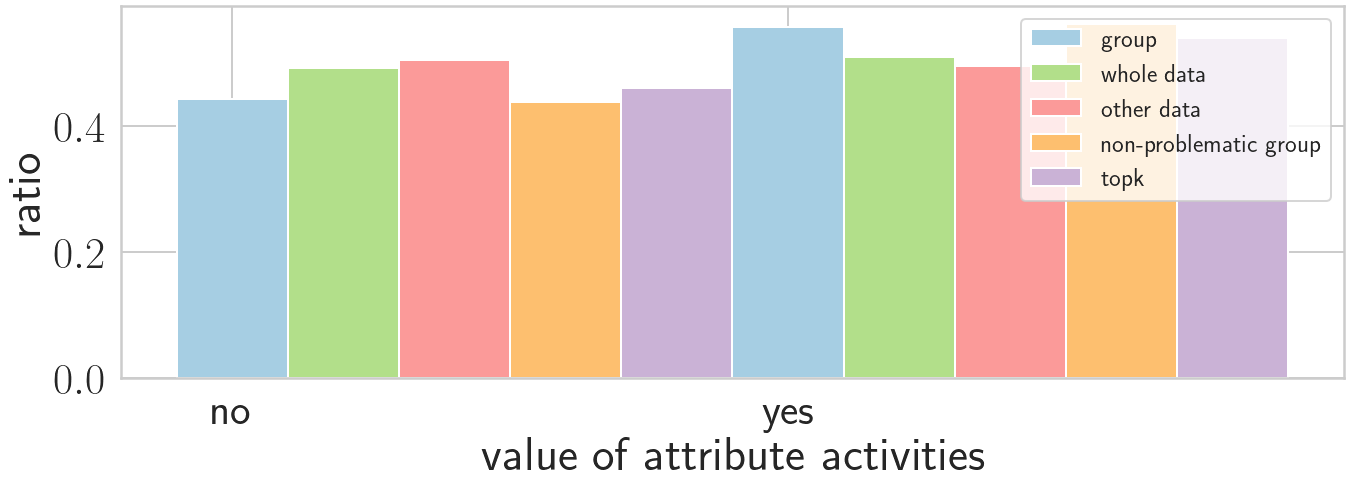

['no' 'yes']


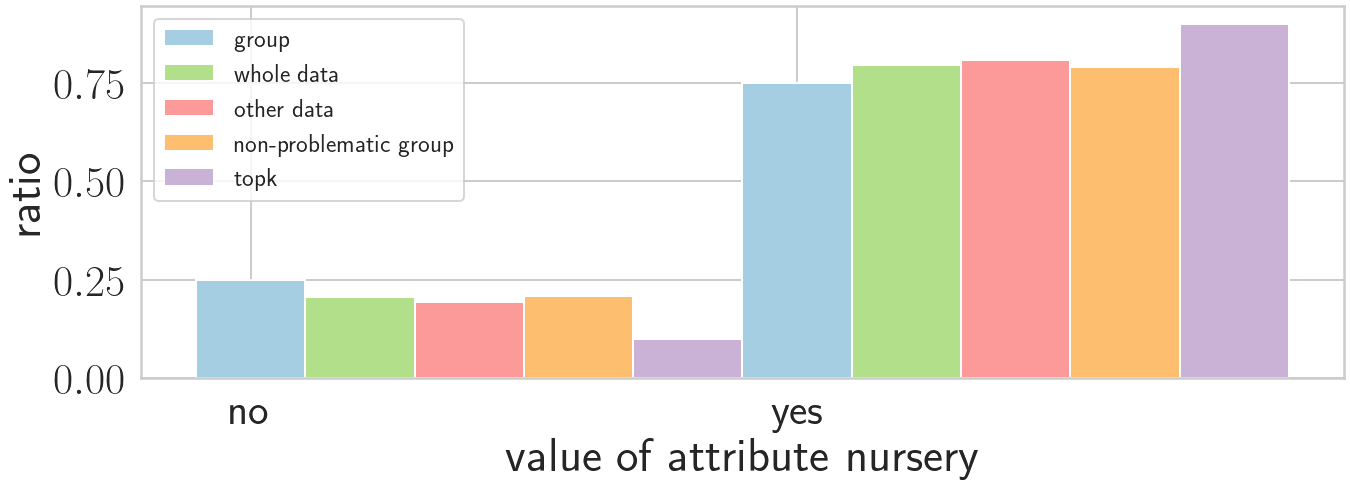

['no' 'yes']


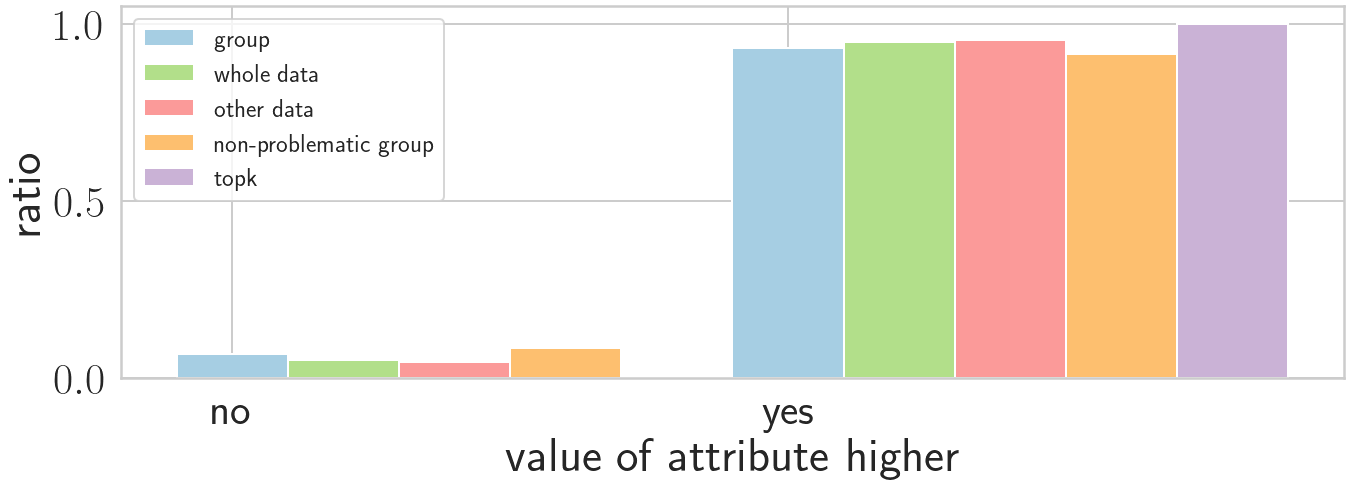

['no' 'yes']


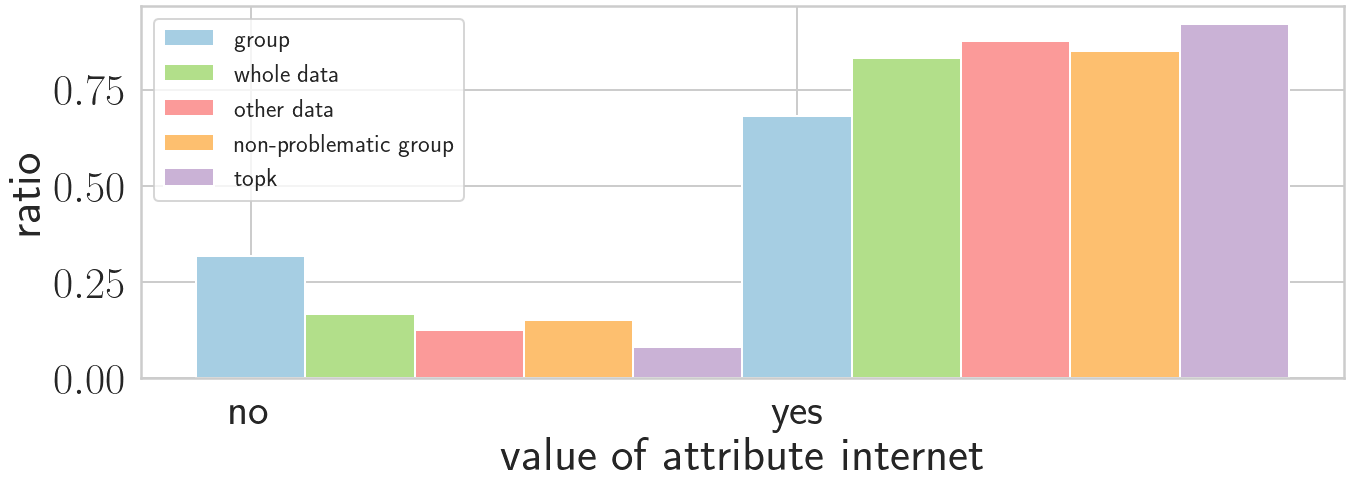

['no' 'yes']


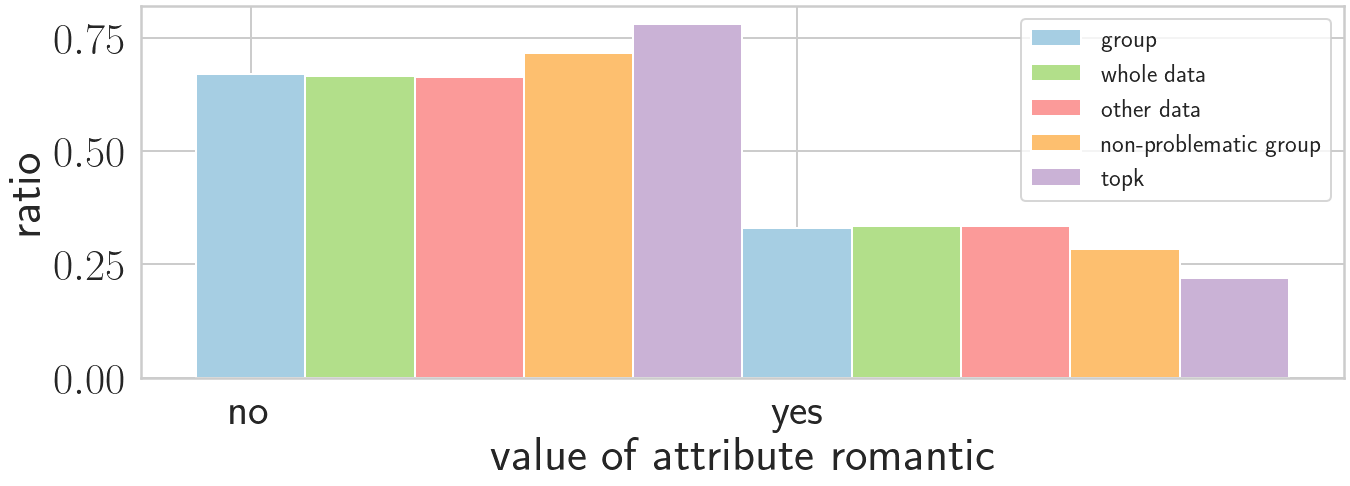

[1 2 3 4 5]


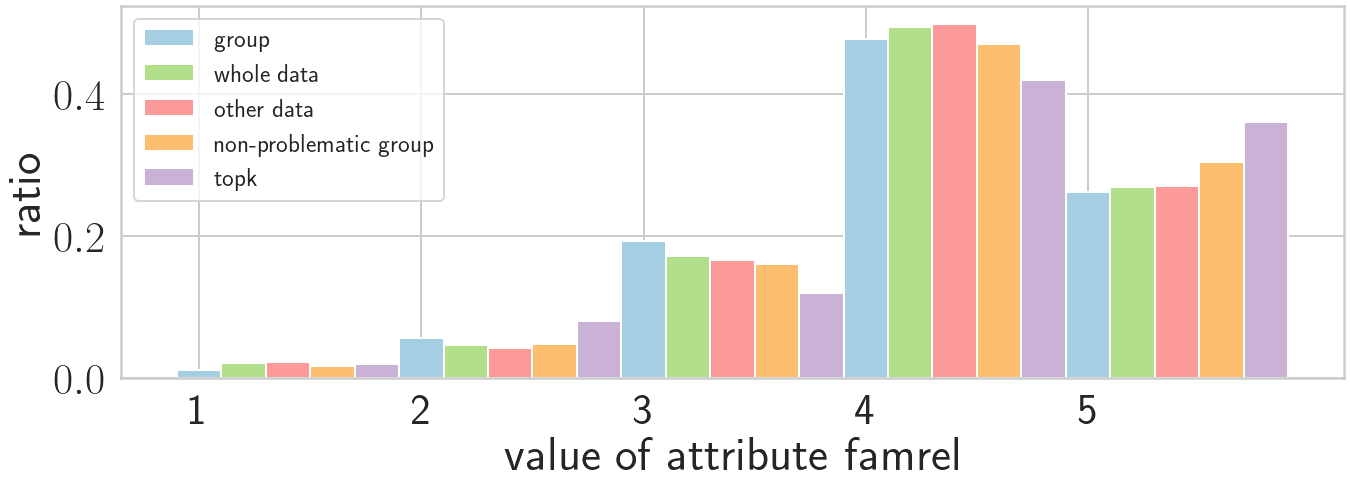

[1 2 3 4 5]


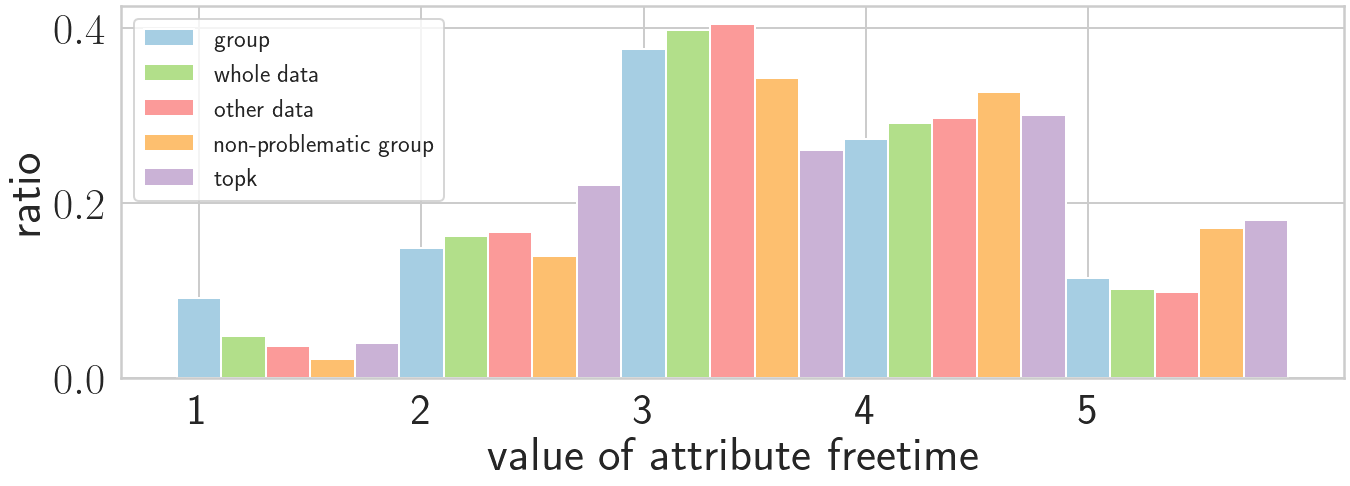

[1 2 3 4 5]


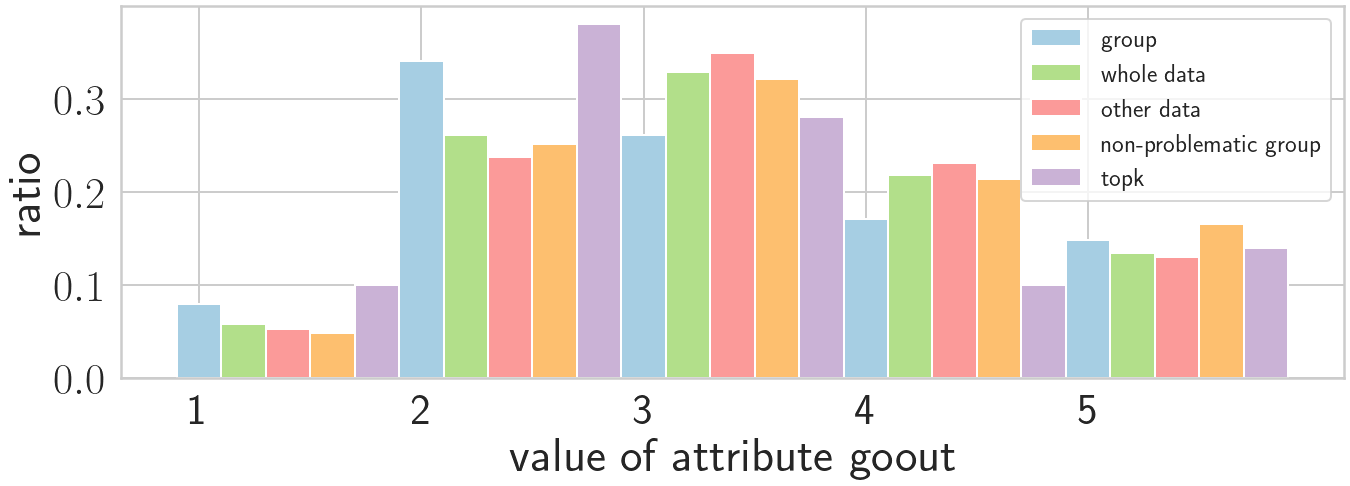

[1 2 3 4 5]


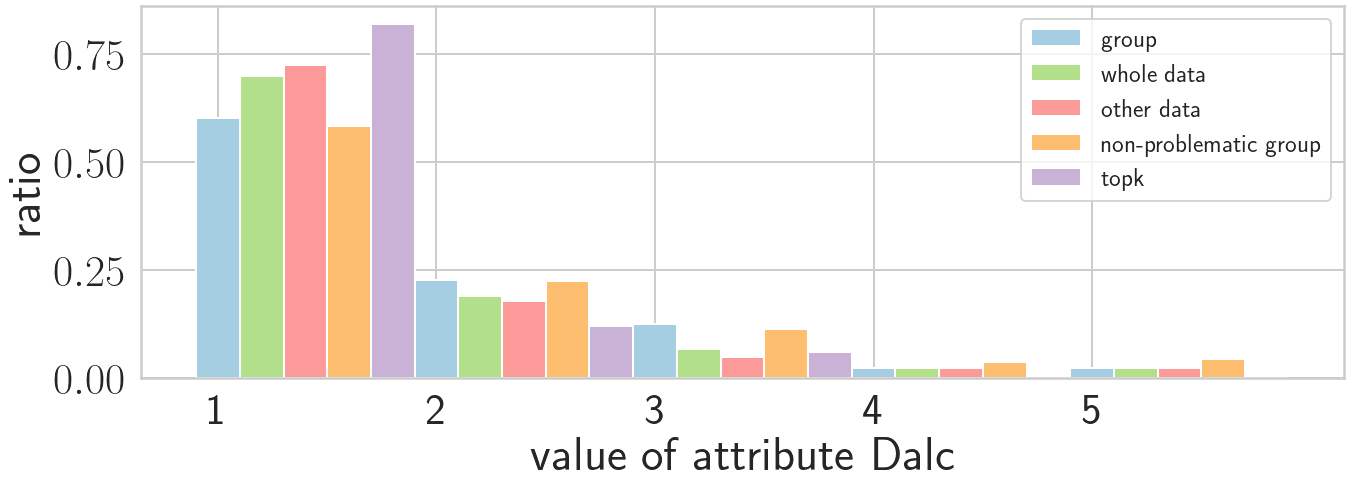

[1 2 3 4 5]


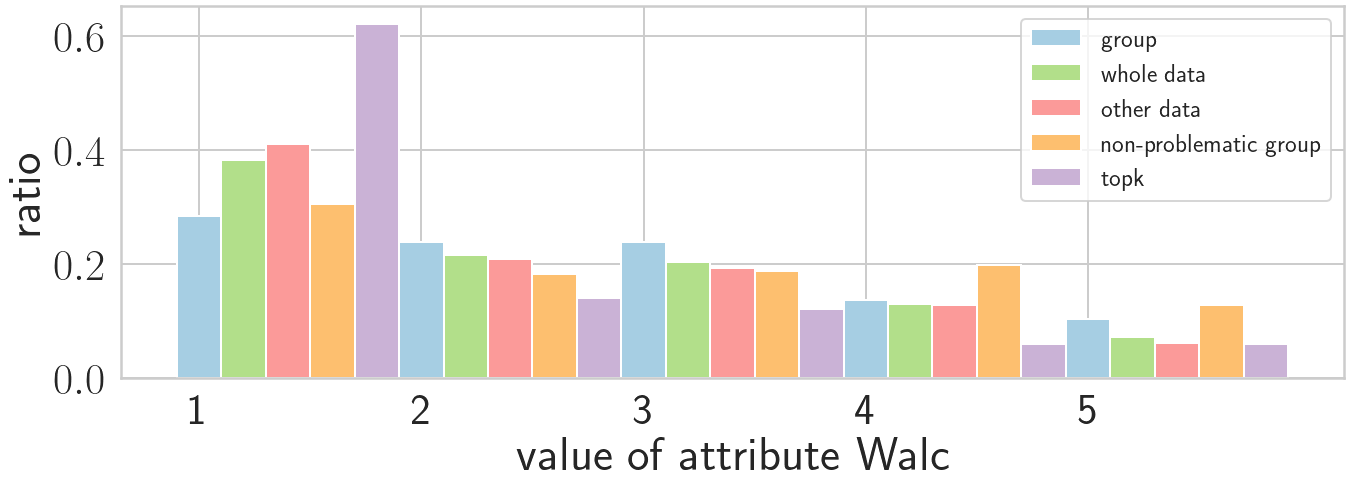

[1 2 3 4 5]


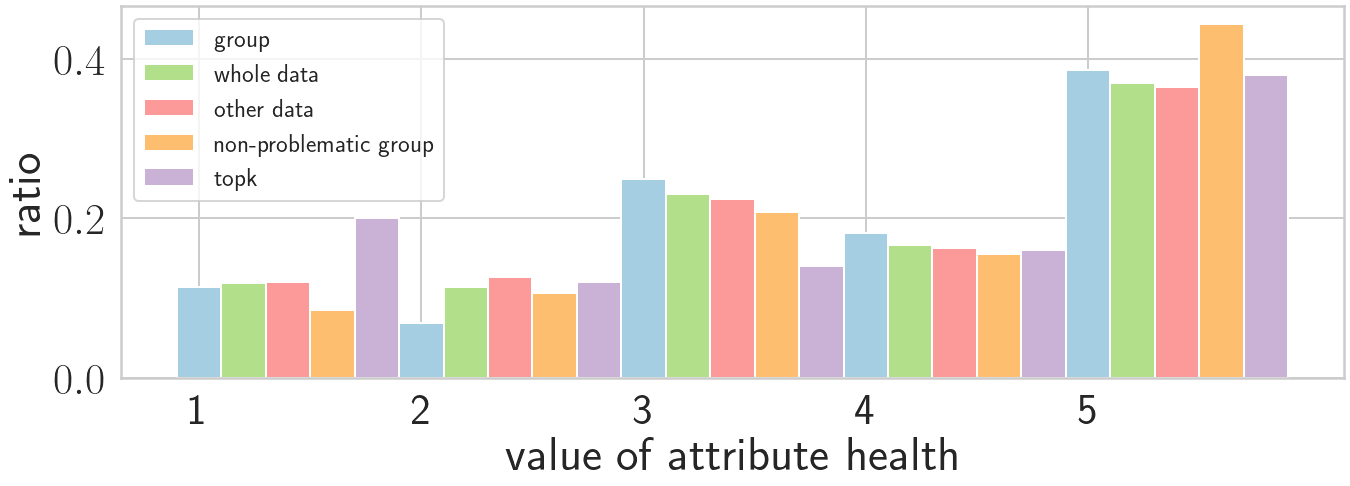

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 28 30 38 40 54 56 75]


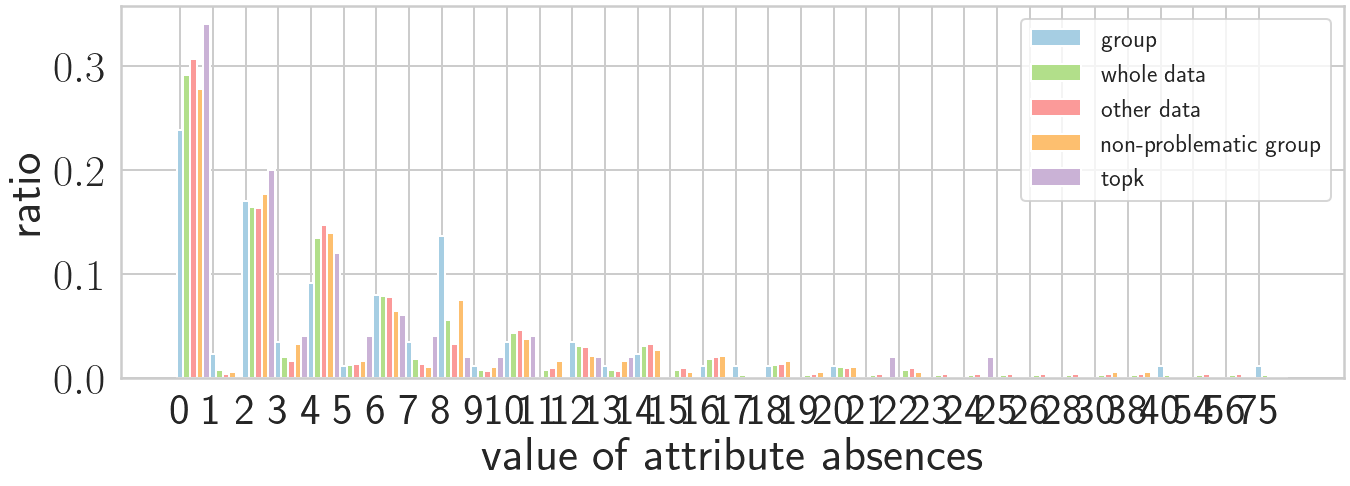

[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


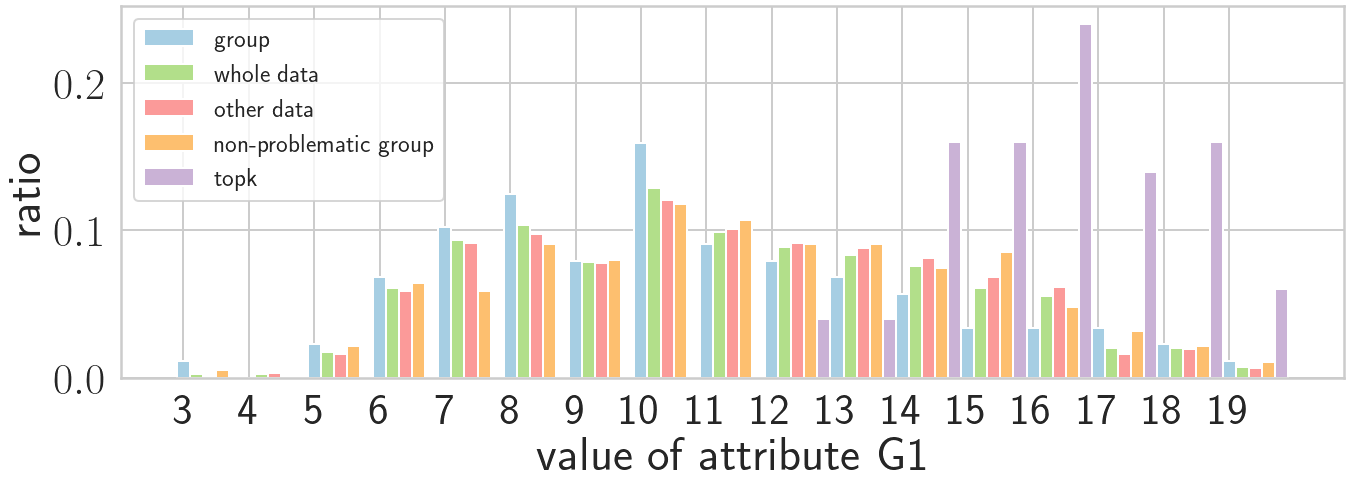

[ 0  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


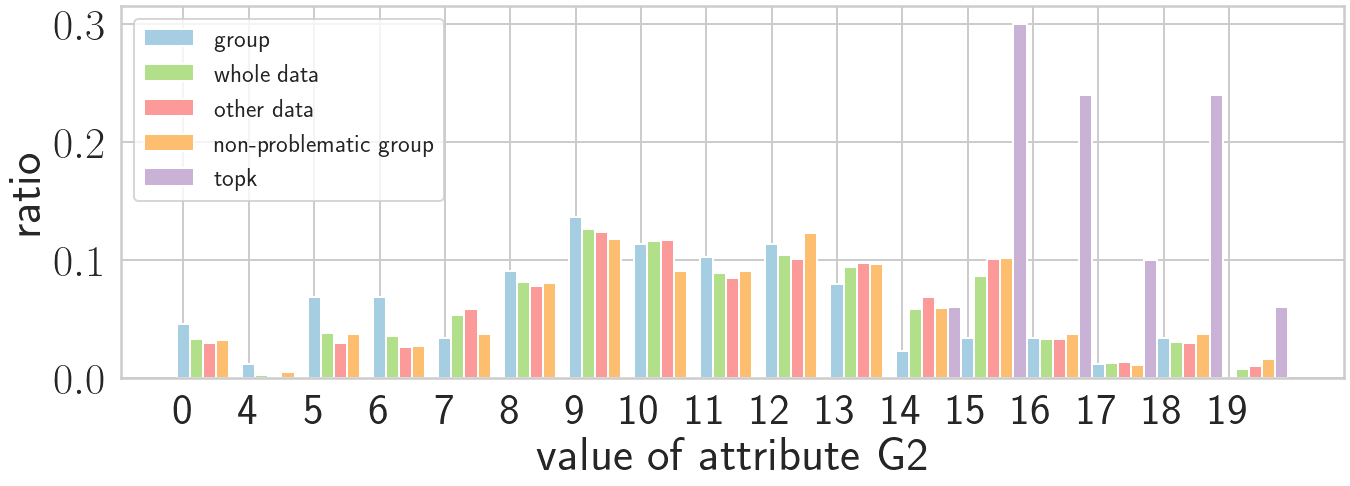

[ 0  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


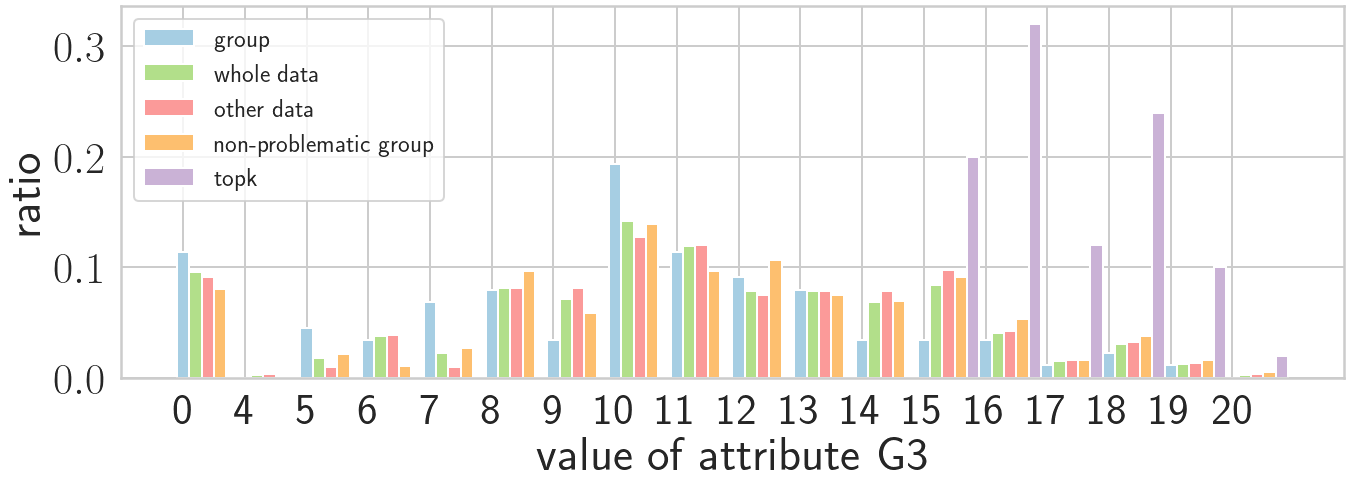

In [39]:
another_group = [-1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
print(check_another_group_global_bounds(another_group, ranked_data, selected_attributes, thc, Lowerbounds, k))
for att in all_attributes_original:
    plot_distribution_ratio(ranked_data, att, groups_global_bounds[1], another_group, k)


395 50 40.0
True
['GP' 'MS']


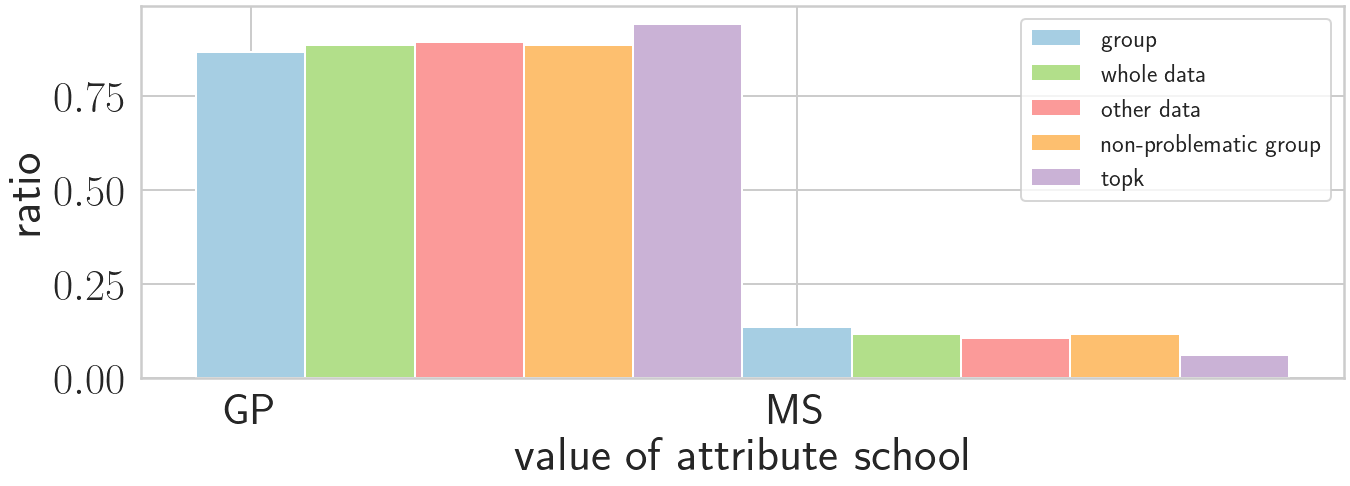

['F' 'M']


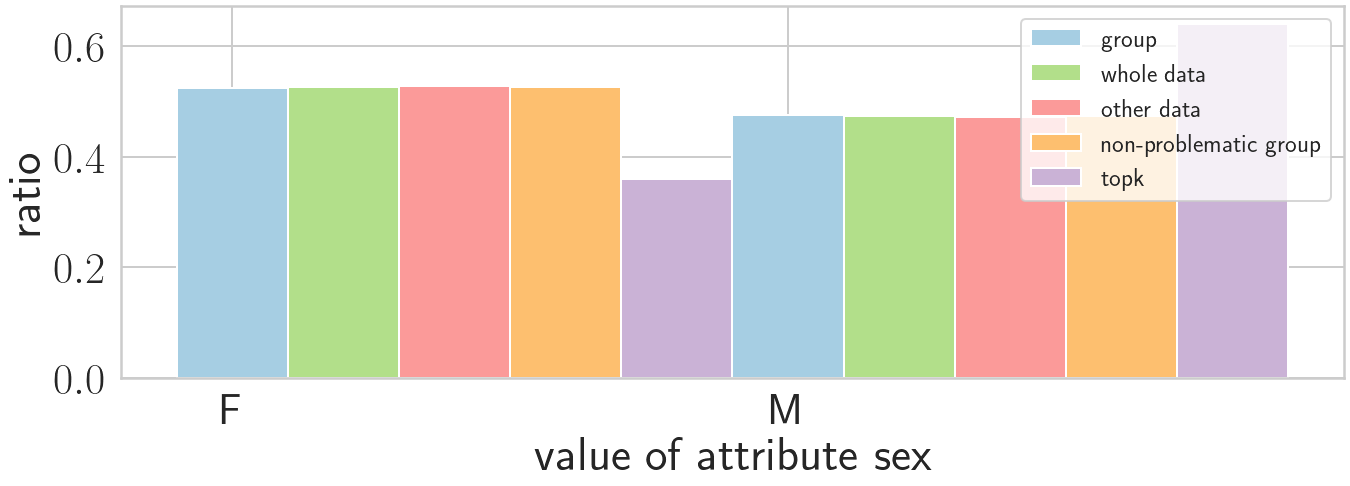

[15 16 17 18 19 20 21 22]


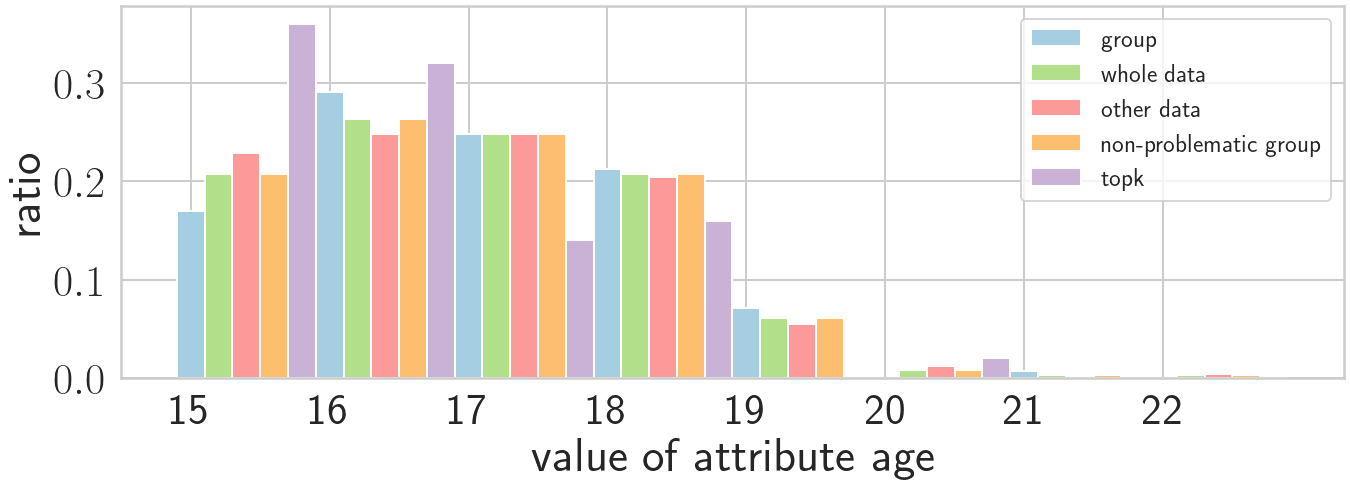

['R' 'U']


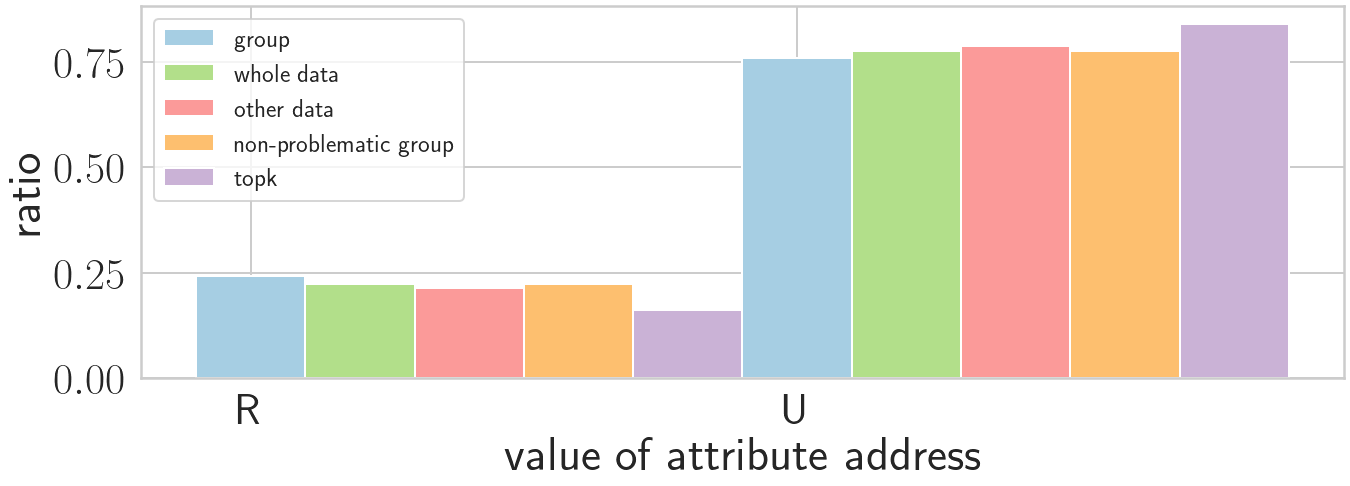

['GT3' 'LE3']


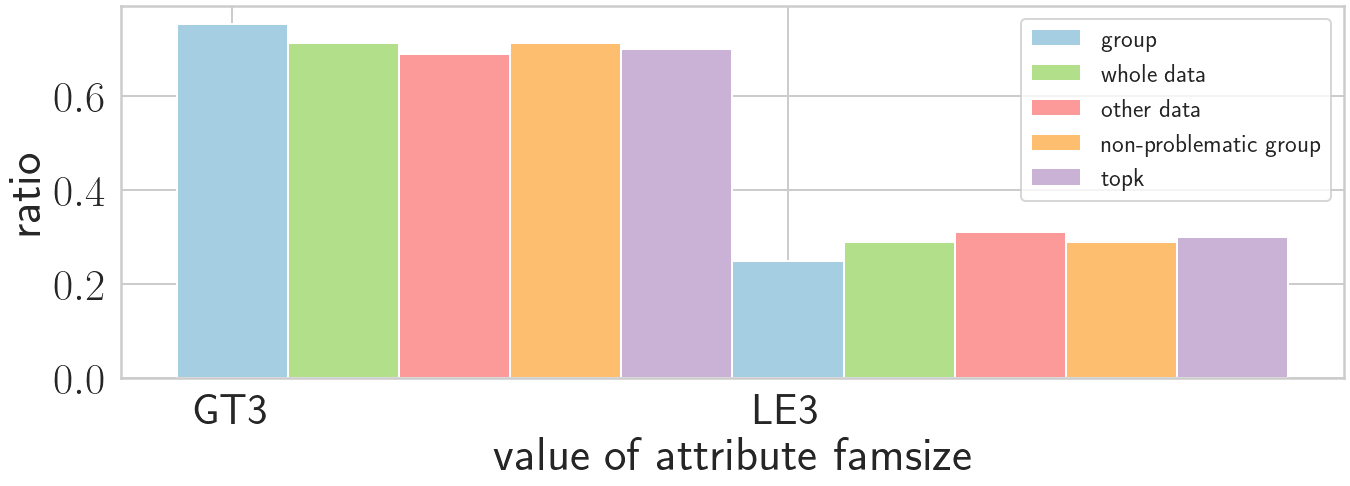

['A' 'T']


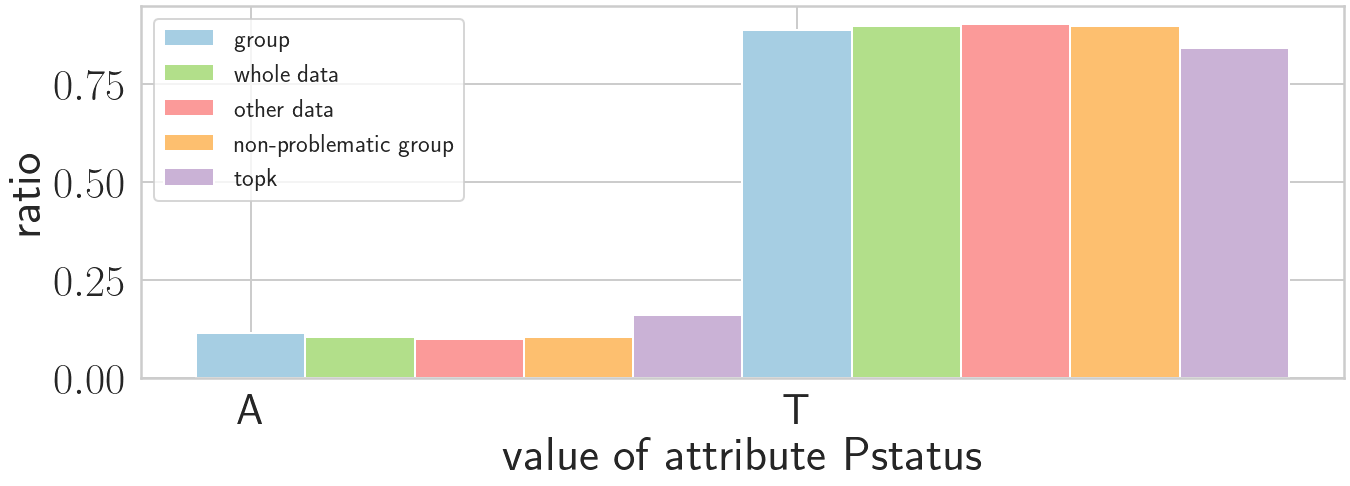

[0 1 2 3 4]


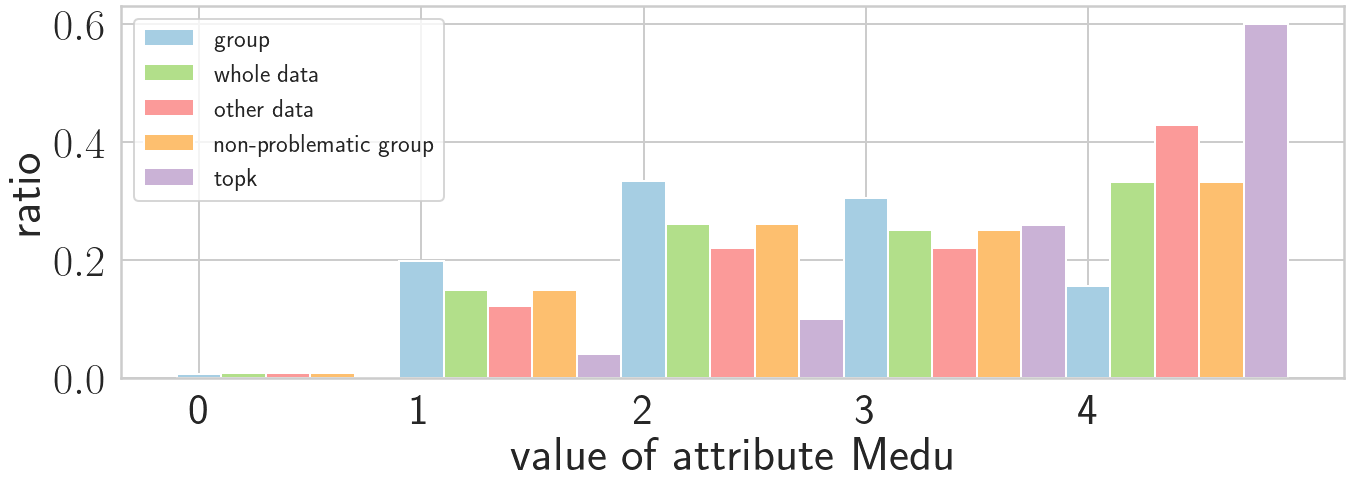

[0 1 2 3 4]


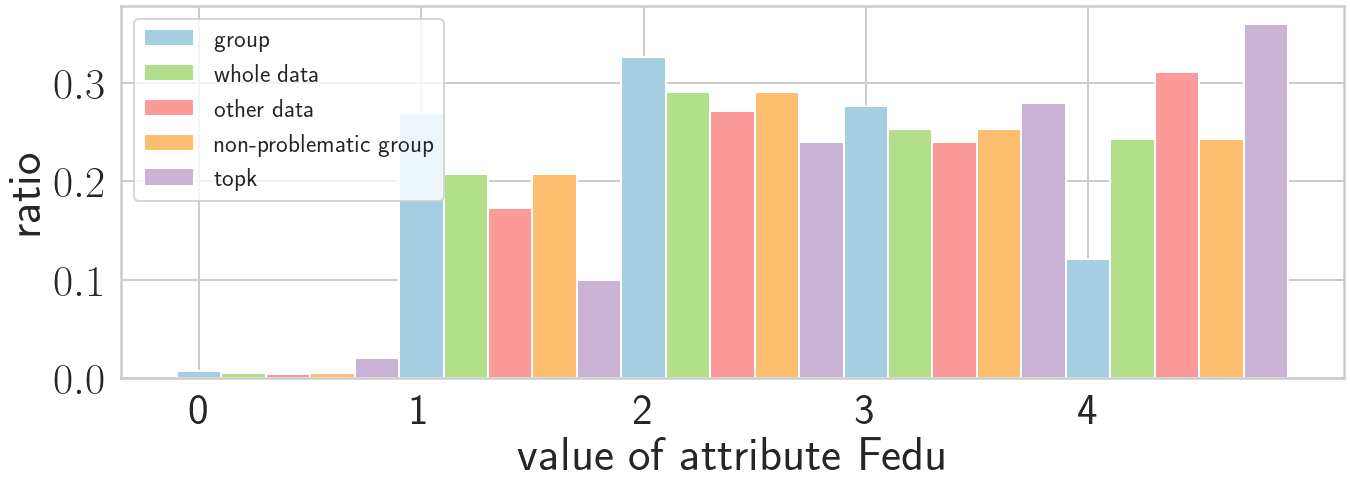

['at_home' 'health' 'other' 'services' 'teacher']


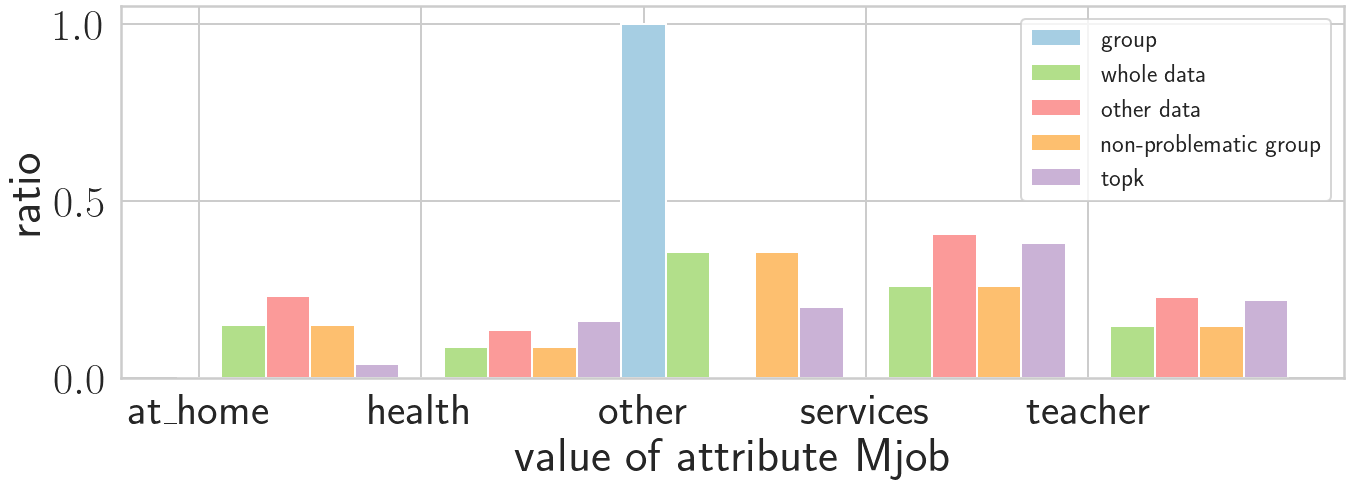

['at_home' 'health' 'other' 'services' 'teacher']


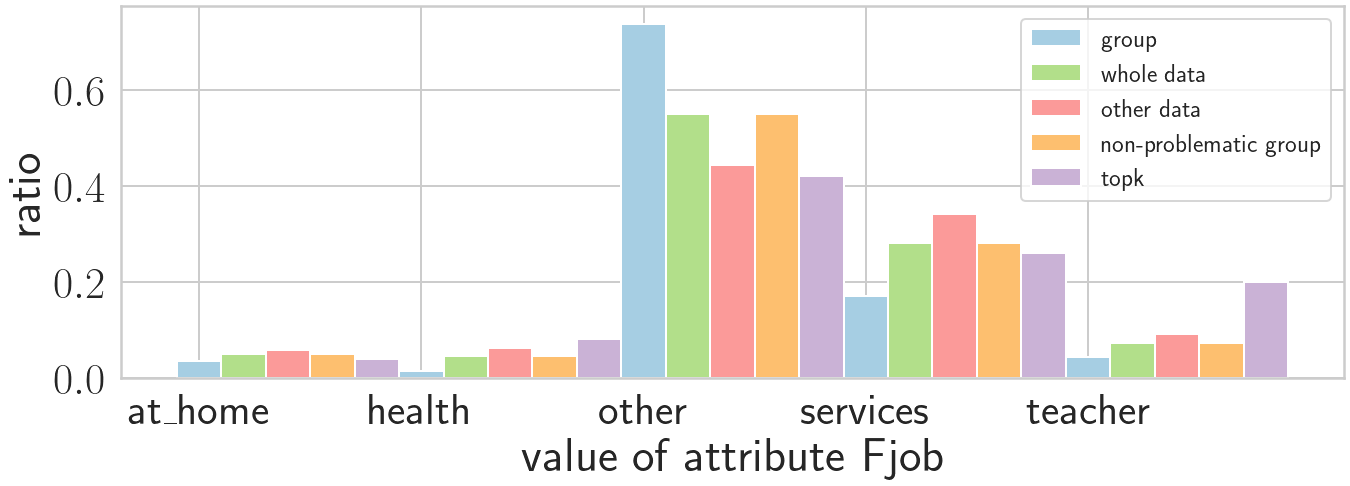

['course' 'home' 'other' 'reputation']


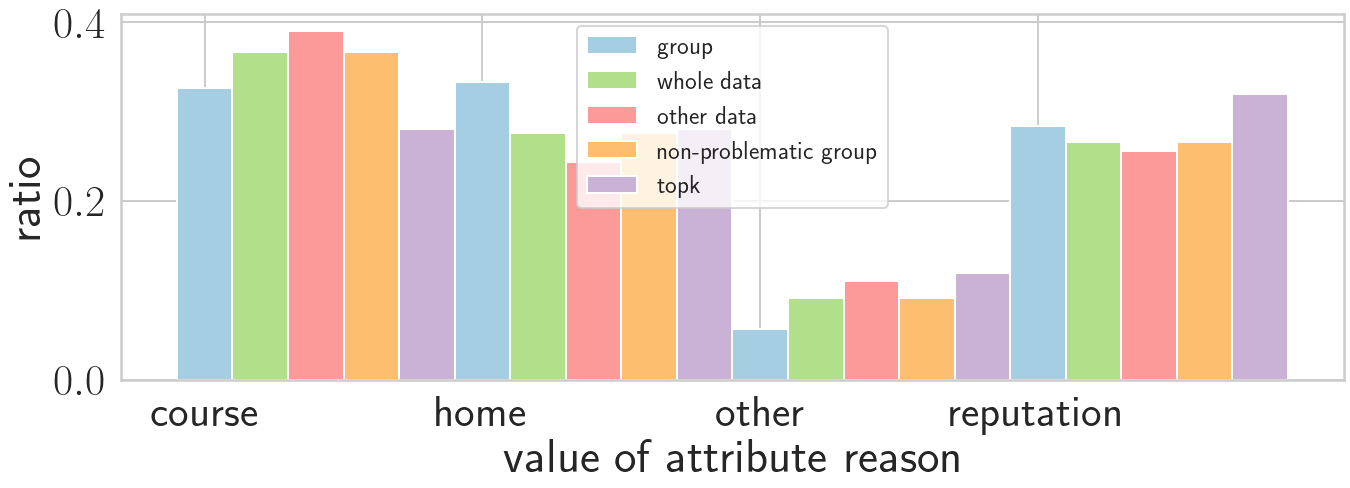

['father' 'mother' 'other']


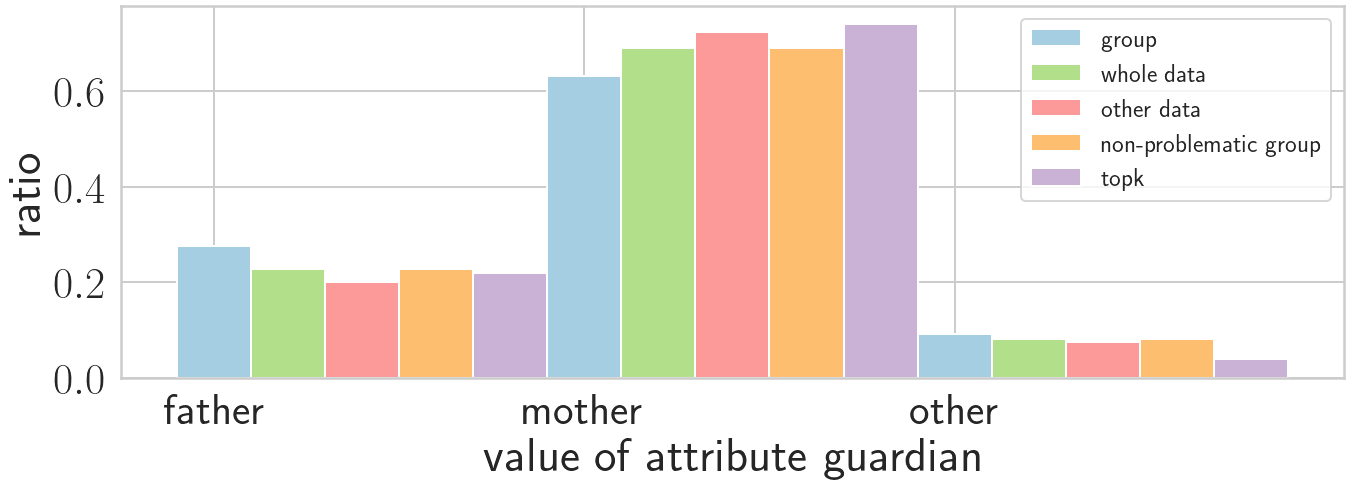

[1 2 3 4]


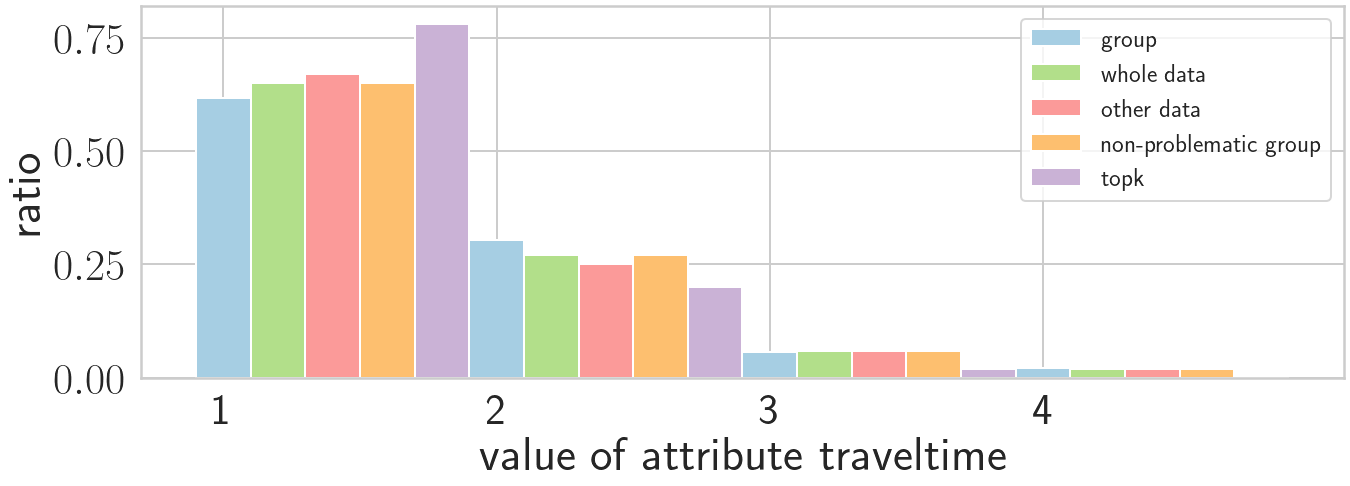

[1 2 3 4]


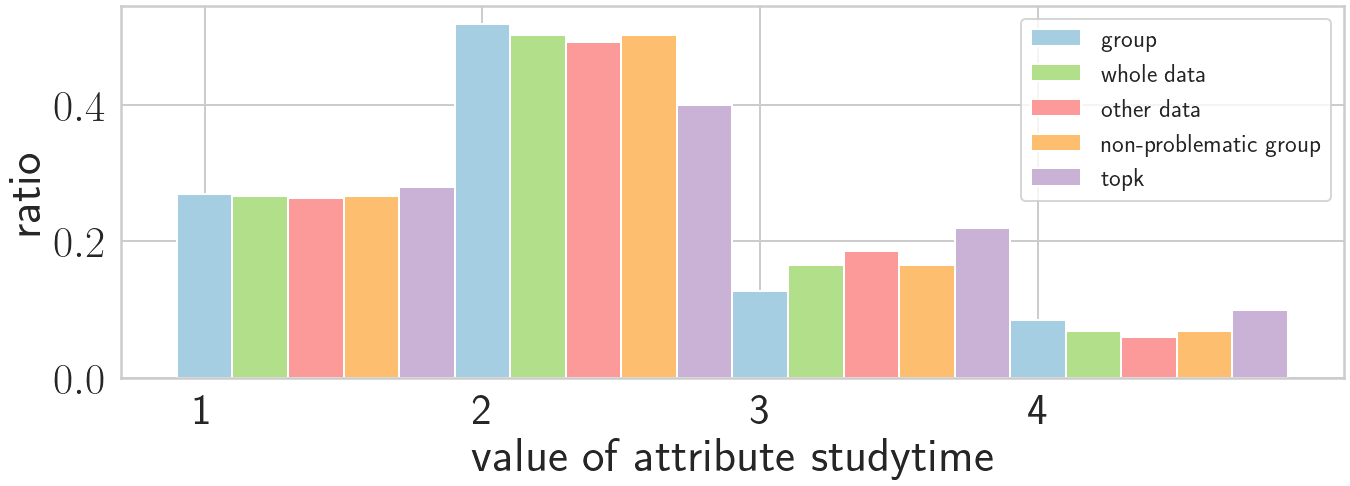

[0 1 2 3]


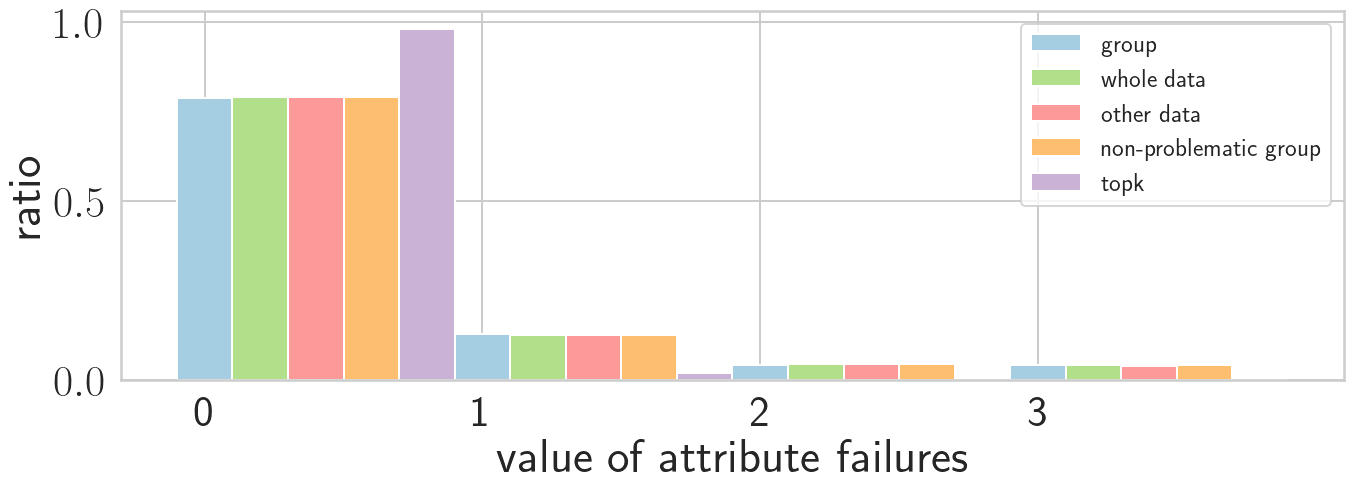

['no' 'yes']


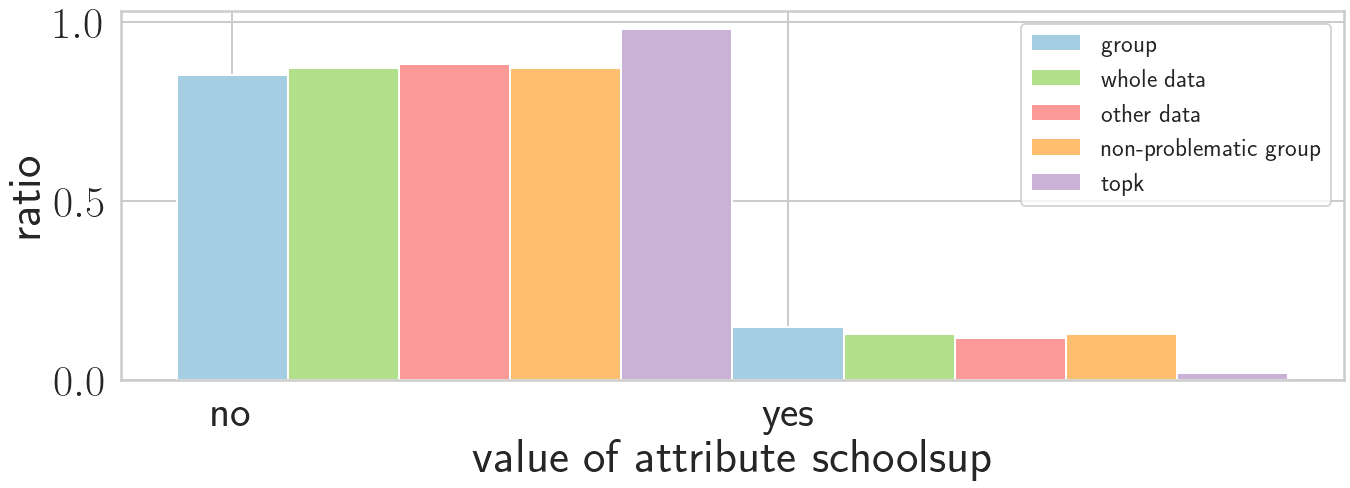

['no' 'yes']


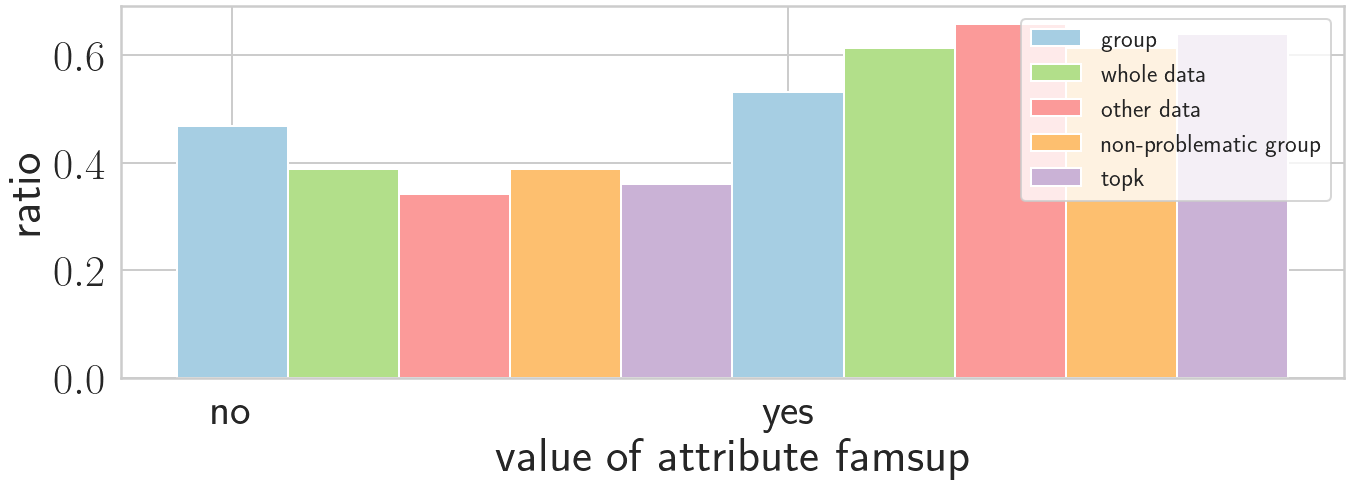

['no' 'yes']


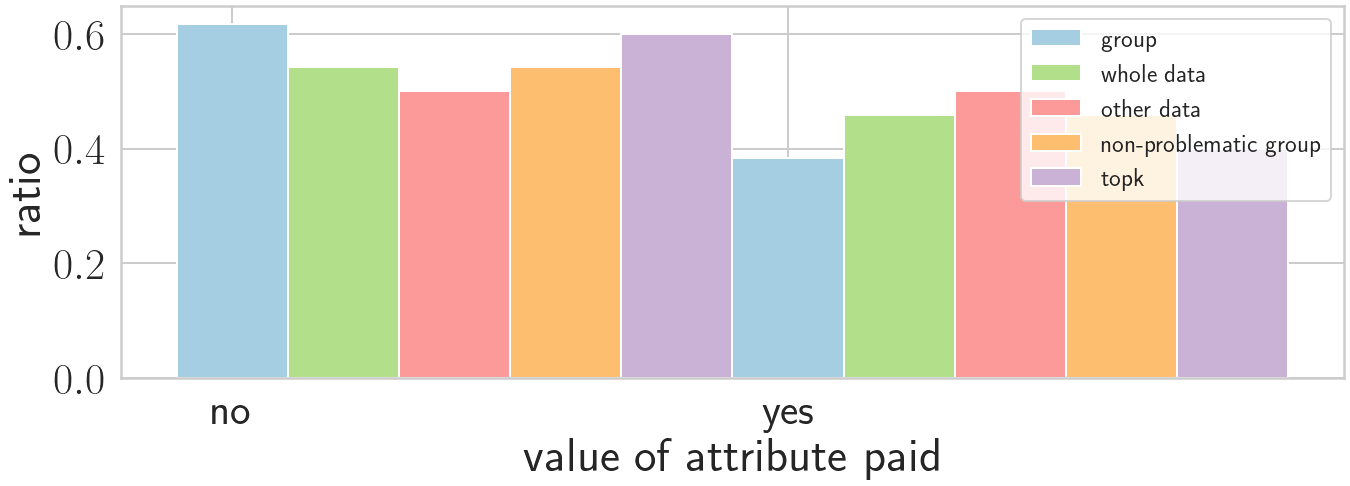

['no' 'yes']


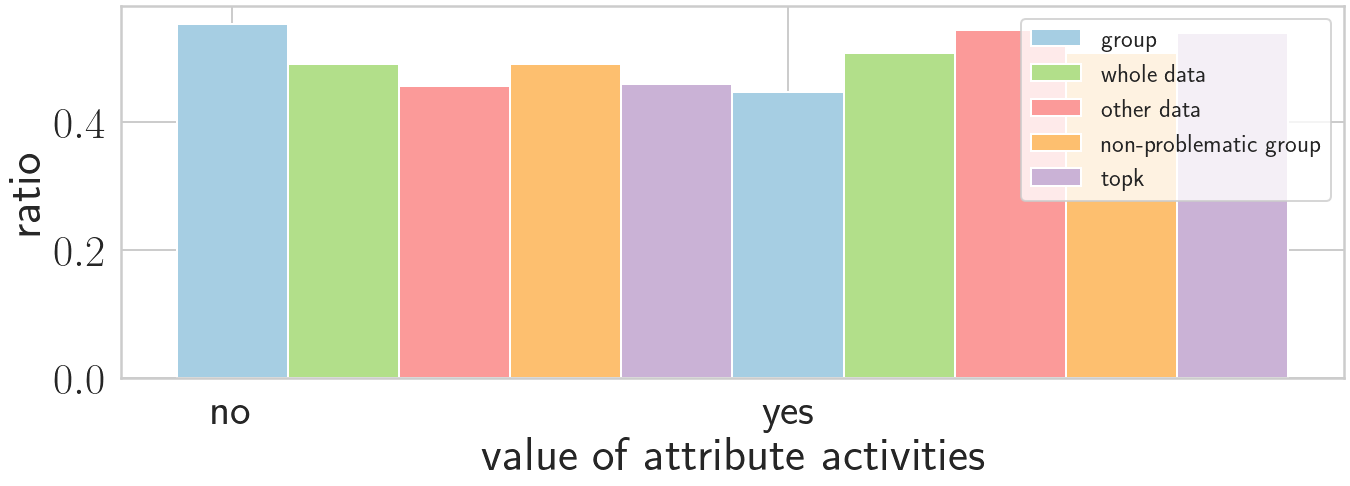

['no' 'yes']


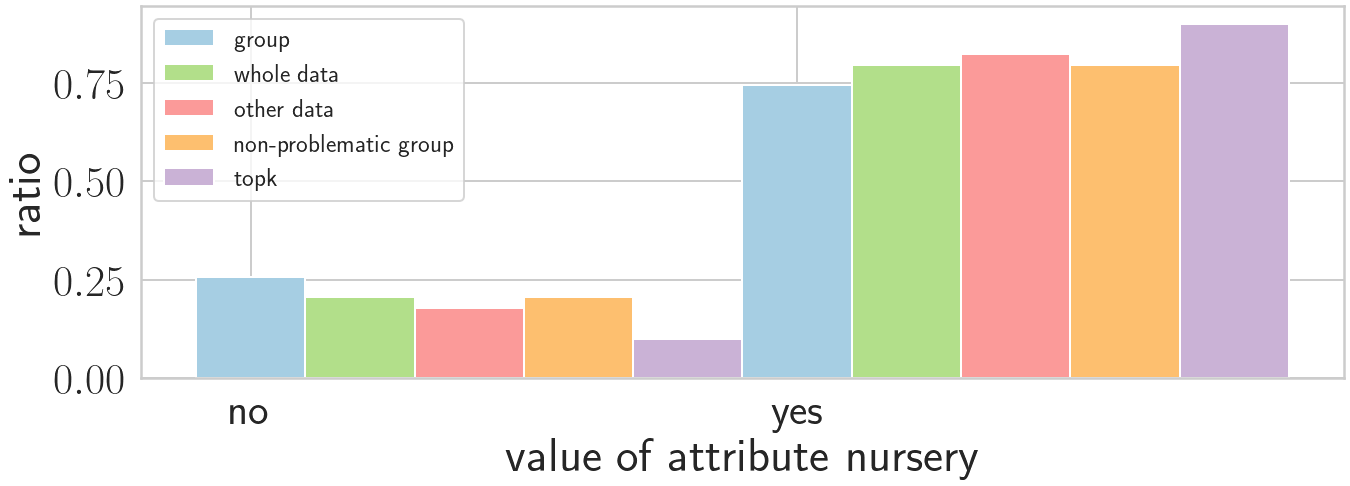

['no' 'yes']


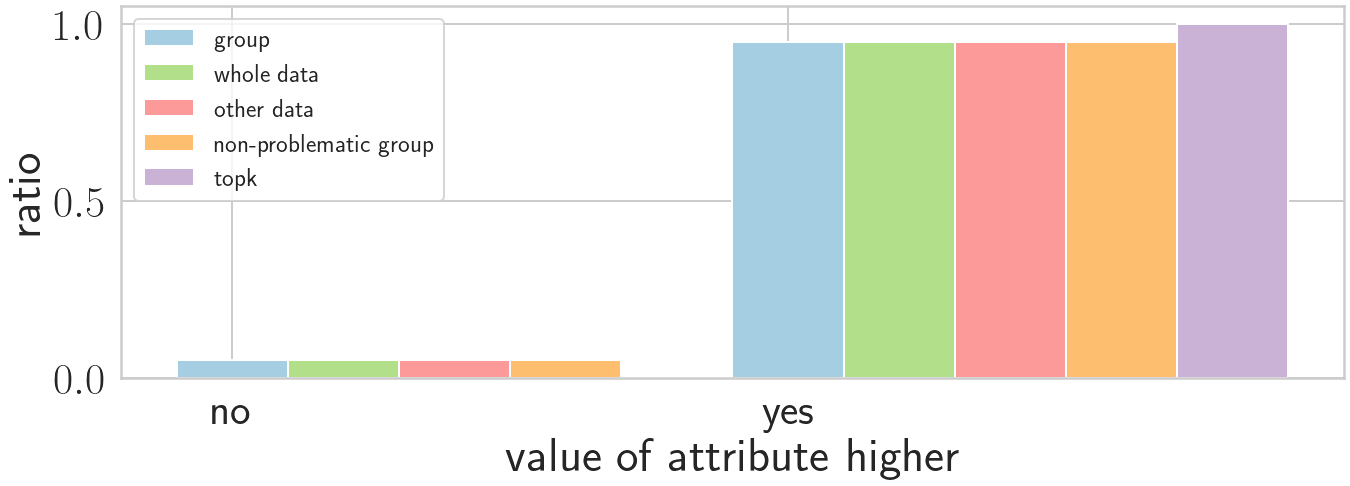

['no' 'yes']


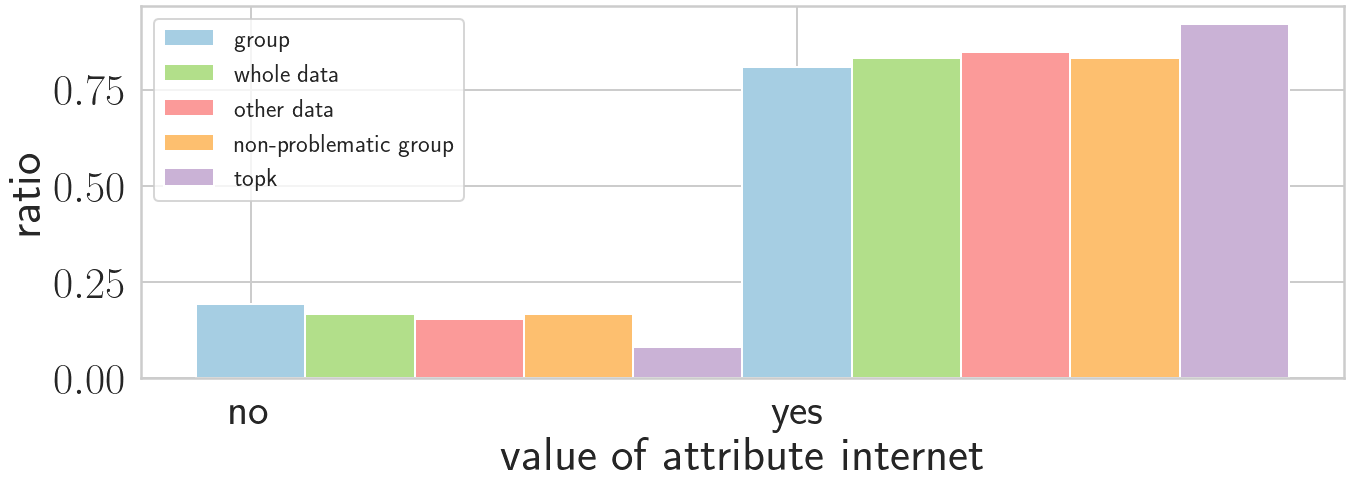

['no' 'yes']


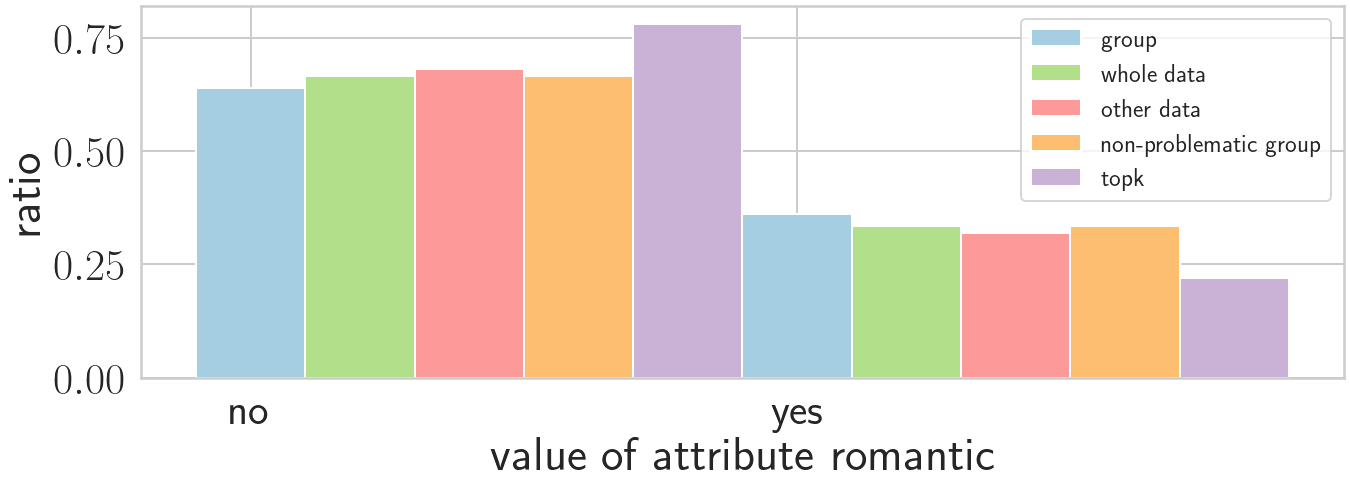

[1 2 3 4 5]


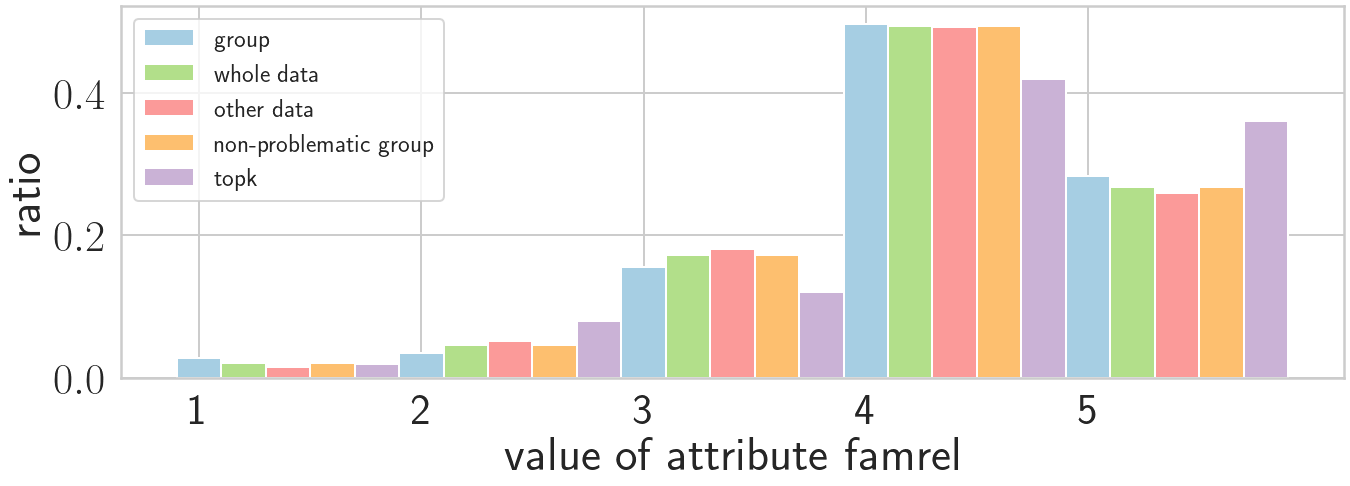

[1 2 3 4 5]


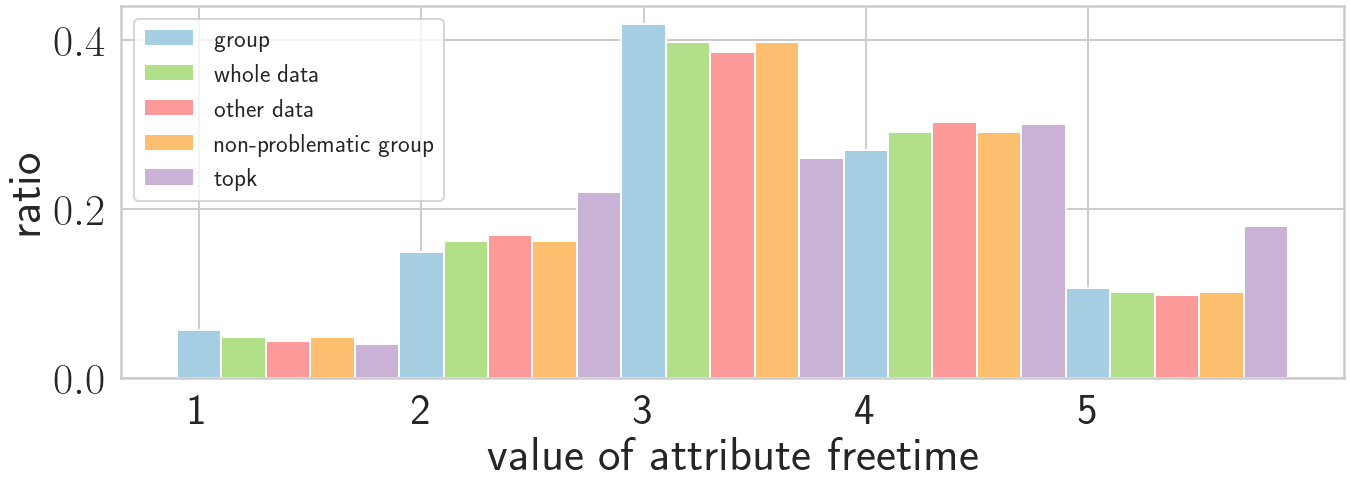

[1 2 3 4 5]


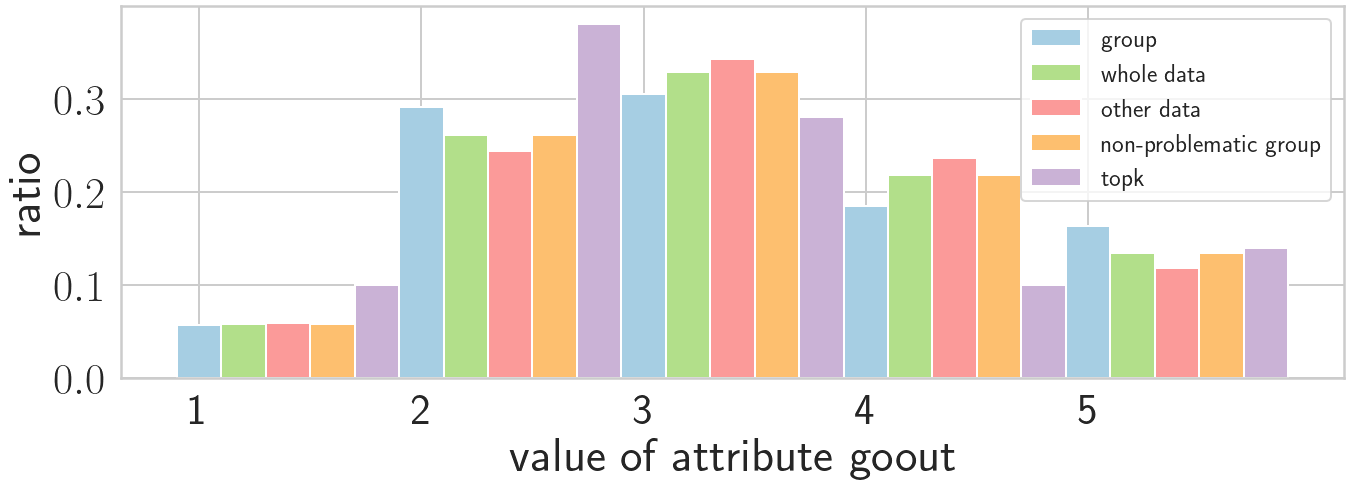

[1 2 3 4 5]


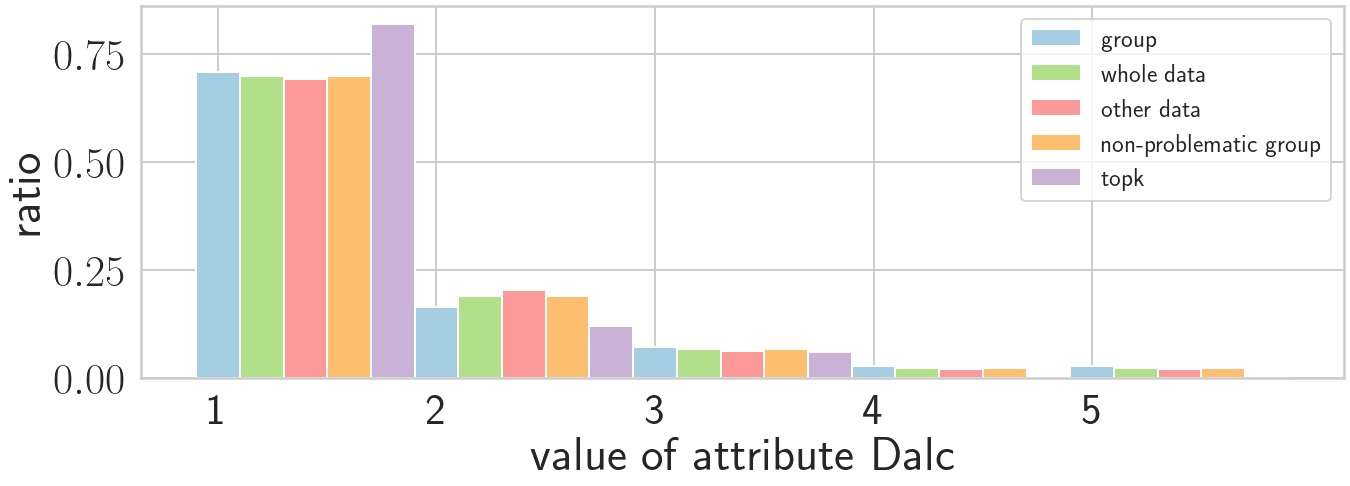

[1 2 3 4 5]


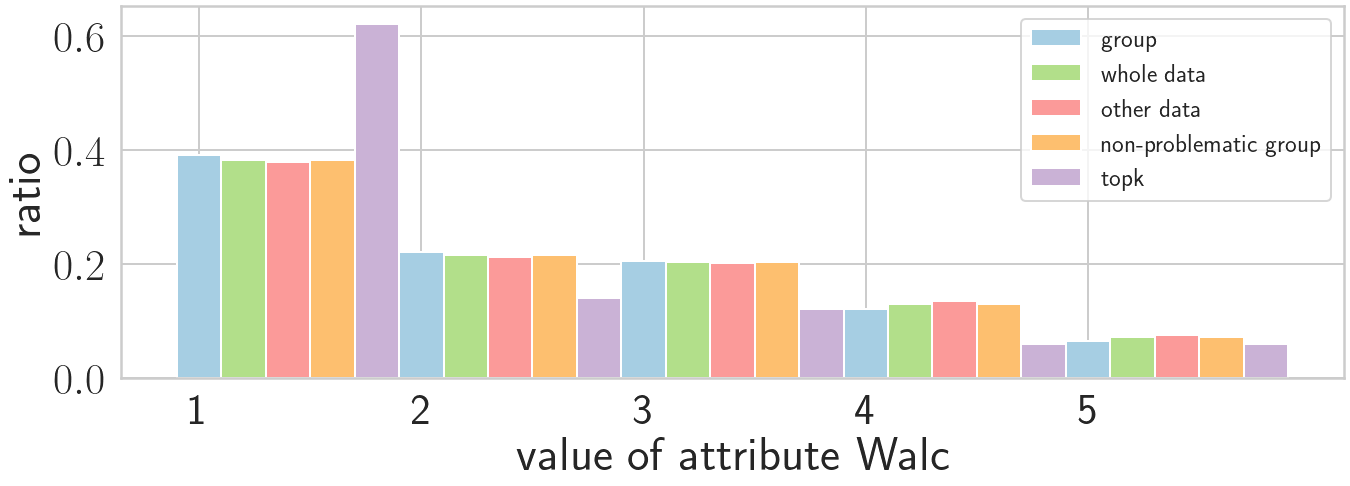

[1 2 3 4 5]


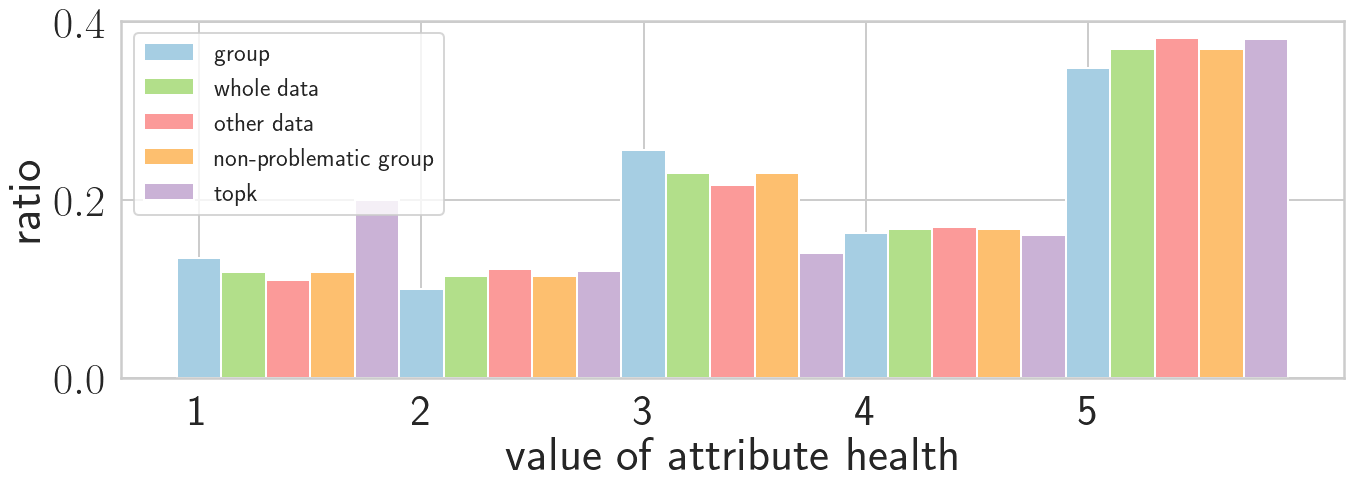

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 28 30 38 40 54 56 75]


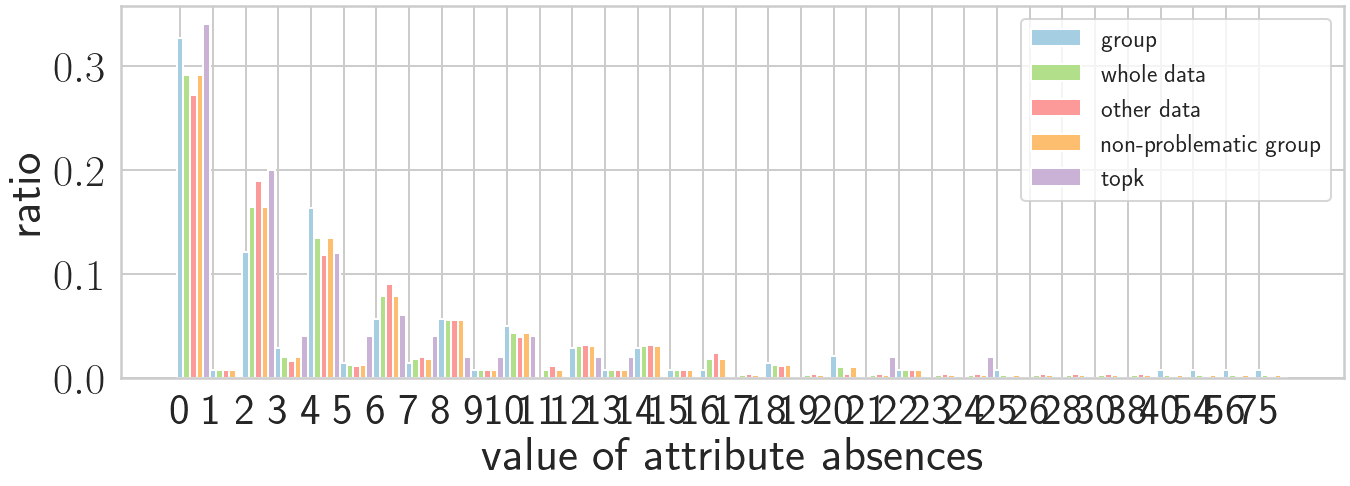

[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


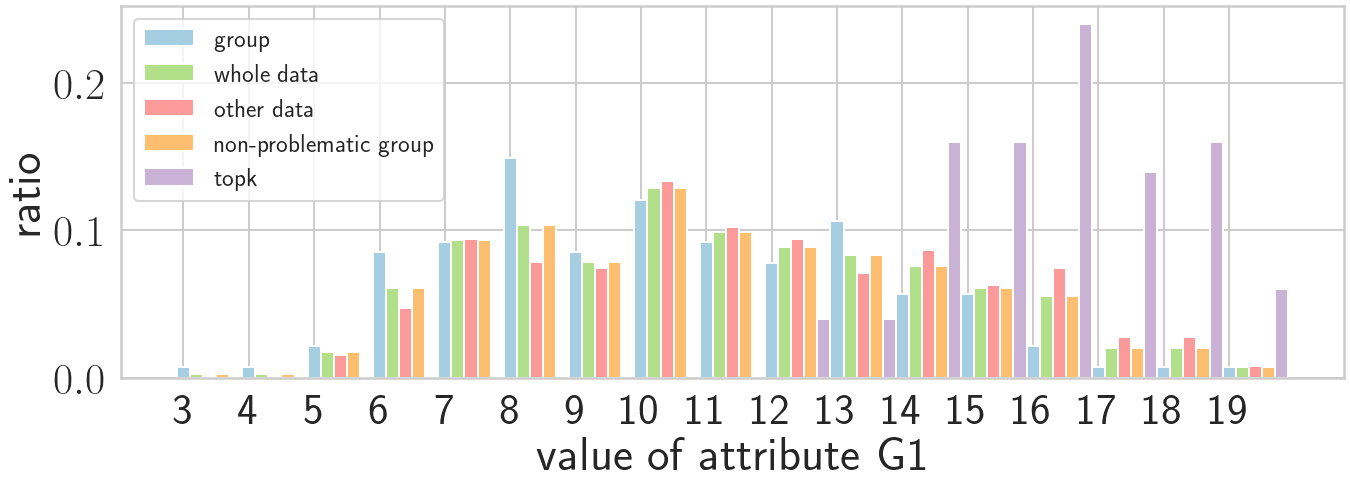

[ 0  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


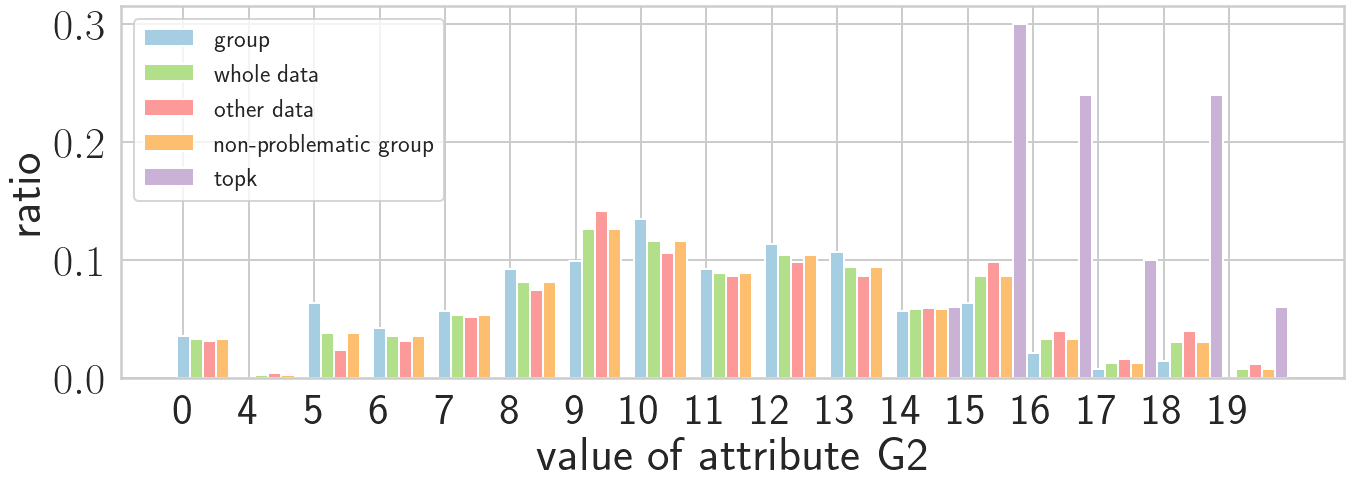

[ 0  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


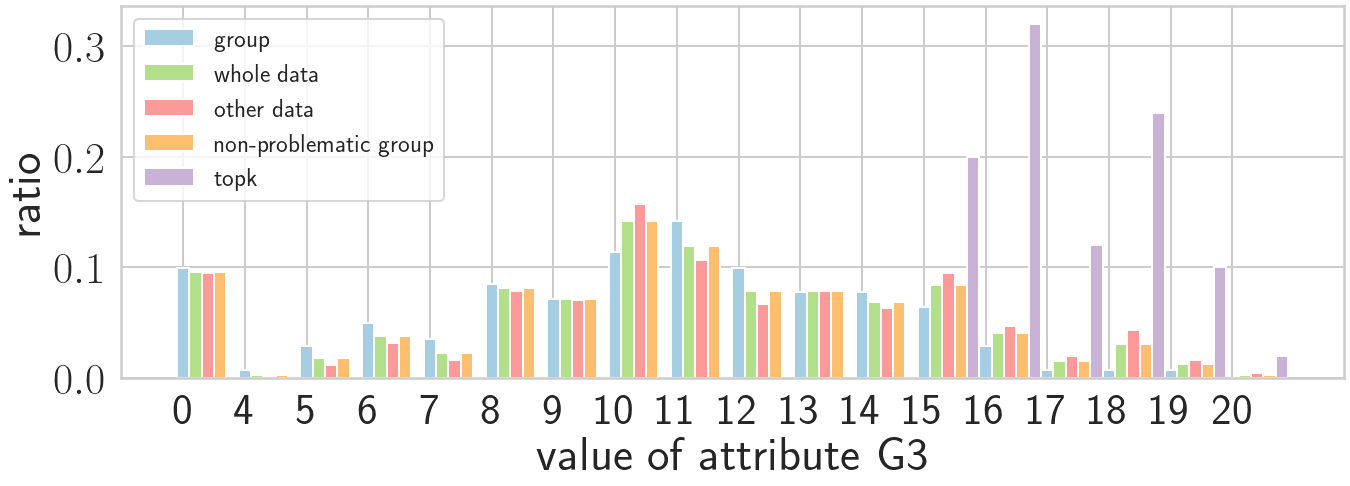

In [40]:

another_group = [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
print(check_another_group_prop_bounds(another_group, ranked_data, selected_attributes, thc, alpha, k))
for att in all_attributes_original:
    plot_distribution_ratio(ranked_data, att, groups_prop_bounds[6], another_group, k)

